In [8]:
%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt
import os
import sys
import pandas as pd
from collections import Counter
import pickle
import json
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt 
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib.colors as colors
import matplotlib.cm as cm
import warnings
from matplotlib.lines import Line2D
from Bio import SeqIO, AlignIO, pairwise2

from ete3 import Tree, SeqMotifFace, TreeStyle, add_face_to_node, RectFace, NodeStyle, TextFace, AttrFace, EvolTree

yeast_esr_flag = input("Use yeast_esr_expression functions? (Y/n)")

if yeast_esr_flag=='Y':
    yeast_esr_exp_path = os.path.normpath('C:/Users/heineib/Documents/GitHub/yeast_esr_expression_analysis') + os.sep
    #io_library_path_core = io_library_path + 'core' + os.sep
    if not(yeast_esr_exp_path in sys.path):
        sys.path.append(yeast_esr_exp_path)
        print("Added " + yeast_esr_exp_path + " to path" )
    import yeast_esr_exp
    yeast_esr_exp.base_dir = yeast_esr_exp_path
    yeast_esr_exp.data_processing_dir = yeast_esr_exp_path + os.path.normpath('expression_data') + os.sep
    
base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')
divyeast_dir = os.path.normpath('C:/Users/bheineike/Documents/GitHub/diverse_yeast')
y1000plus_dir = os.path.normpath('C:/Users/bheineike/Documents/GitHub/y1000plus_tools') + os.sep
genomes_dir = os.path.normpath('G:/My Drive/Crick_LMS/external_data/genomes')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#Conservation data is in
scores_mapped = pd.read_table(base_dir + os.sep + os.path.normpath('Output/Matrices/Scores_Mapped.tsv'), index_col = 0)
params_to_plot_mapped = ['Mean(Conservation Rate) [ALL]', 'CV(Type Conservation Rate) [ALL]', 'Mean(Type Conservation Rate) [ALL]', 'CV(Conservation Rate) [ALL]']
scores_mapped_subset = scores_mapped.loc[:,params_to_plot_mapped]

scores_exp = pd.read_table(base_dir + os.sep + os.path.normpath('Output/Matrices/Scores_Experimental.tsv'), index_col = 0)#
params_to_plot_exp = ['Mean(log2(Abundances)) 10 Sp [EXP]','Median(log2(Abundances)) 10 Sp [EXP]','Std(log2(Abundances)) 10 Sp [EXP]','1k_Mean_log2_Abundances [EXP]']
scores_exp_subset = scores_exp.loc[:,params_to_plot_exp]

scores_data = scores_mapped_subset.merge(scores_exp_subset, how = 'outer', left_index=True, right_index=True)

#Load my YN00 Data
dnds_yn00 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00_maxdS_10.csv'), index_col=0)

#Load M0 Data
dnds_m0 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0.csv'), index_col = 0 )

#Load Nielsen Lab files 
dnds_nl_with_SCE = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_OG_with_SCE.csv'), index_col=0)
dnds_nl_with_SCE['og'] = [og_label.split('.')[0] for og_label in dnds_nl_with_SCE['OG']]
dnds_nl_with_SCE.drop(columns = 'OG', inplace=True)
dnds_nl_with_SCE.rename(columns= {'dN_dS': 'dN_dS_nielsen_SCE'}, inplace=True)

dnds_nl_03_02 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/from_nielsen_lab/gene_dn_ds_03_02.csv'), index_col=0)
dnds_nl_03_02['og'] =  [og_label.split('.')[0] for og_label in dnds_nl_03_02['OG']]
dnds_nl_03_02.drop(columns = 'OG', inplace=True)
dnds_nl_03_02.rename(columns= {'dN_dS': 'dN_dS_nielsen_03_02'}, inplace=True)
                         
#merge structural data with m0 data
m0_col_rename = {col : col + '_m0' for col in dnds_m0.columns}
dnds_m0_for_merge = dnds_m0.rename(columns = m0_col_rename)
dnds_struct_data = dnds_m0_for_merge.merge(scores_data, how='outer', left_index=True, right_index=True)

#merge yn00 data
yn00_col_rename = {col:col +'_yn00' for col in dnds_yn00.columns}
dnds_yn00_for_merge = dnds_yn00.rename(columns = yn00_col_rename)
dnds_struct_data = dnds_struct_data.merge(dnds_yn00_for_merge, how='outer', left_index=True, right_index=True)
dnds_struct_data['og_ref'] = dnds_struct_data.index

#Merge nielsen lab data
dnds_struct_data = dnds_struct_data.merge(dnds_nl_with_SCE, how='left', left_on = 'og_m0', right_on='og')
dnds_struct_data = dnds_struct_data.merge(dnds_nl_03_02, how='left', left_on = 'og_m0', right_on='og')
dnds_struct_data.set_index('og_ref', inplace=True)


#Load ETC_proteins_clustered data
etc_proteins_clustered = pd.read_csv(base_dir + os.sep + os.path.normpath('examples/etc/etc_table.csv'), index_col=0)


## Construct YN00 and M0 matrices after calculations have been done

Conducted DN/DS calculations with shell scripts and python scripts on singularity environment. 

Prepare Alignments: 
    diverse_yeast/20221206_struct_align_dnds_preps.sh
        diverse_yeast/20221206_struct_align_dnds_msas.py
        diverse_yeast/20221206_struct_align_dnds_trees.py (for M0, run on cluster)

YN00 calculations:
    diverse_yeast/20221207_run_yn00.sh

M0 Calculations: 
    diverse_yeast/20221214_run_m0.sh

## Issues in YN00 calculations

### dNdS > 50 (filtered that value out and calculated with rest)
    OG1115_REF_Scer_AF-P06208-F1-model_v2
    OG1364_REF_Scer_AF-P27796-F1-model_v2

### Don't have value: 
    No DS values passed the DS filter (between 0.005, above 3.0): 
        OG2129_REF_Scer_AF-P06785-F1-model_v2
        OG1785_REF_Scer_AF-P25578-F1-model_v2
        OG1394_REF_Scer_AF-Q12069-F1-model_v2
        OG1329_REF_Scer_AF-P17709-F1-model_v2
        OG1603_REF_Scer_AF-P16120-F1-model_v2
        OG3767_REF_Scer_AF-P39683-F1-model_v2
        OG2677_REF_Scer_AF-P28834-F1-model_v2
        OG1060_REF_Scer_AF-P06169-F1-model_v2
        OG1060_REF_Scer_AF-P50873-F1-model_v2
        OG2357_REF_Scer_AF-P33734-F1-model_v2
        OG2348_REF_Scer_AF-Q06625-F1-model_v2
        OG2214_REF_Scer_AF-P13259-F1-model_v2
        OG1473_REF_Scer_AF-P53204-F1-model_v2
        OG1021_REF_Scer_AF-P40047-F1-model_v2
        OG1659_REF_Scer_AF-P32775-F1-model_v2
        OG1622_REF_Scer_AF-P15274-F1-model_v2
        OG1714_REF_Scer_AF-P07702-F1-model_v2
        OG2588_REF_Scer_AF-P38063-F1-model_v2

    yn00 did not run (like OG2645 below, before switching the Pombe sequences) likely because of mismatch between CDS and protein sequence in one of the sequences): 
        OG1054_REF_Scer_AF-P16861-F1-model_v2  komagataella_pastoris__OG1054__52_3574.pdb	OG1054_25
        OG2960_REF_Scer_AF-P16622-F1-model_v2  Spom_AF-O59786-F1-model_v2.pdb	OG2960_2


### OG2645 error: 
    Stop codon in seq OG2645_2 (Spom_AF-O74827-F1-model_v2.pdb


    The CDS is not mapping to the protein sequence: 
    CDS Mapps to SPBC337.16: https://www.pombase.org/gene/SPBC337.16

    Protein sequence should be: 

    SPBC337.16.1:pep cho1|phosphatidyl-N-dimethylethanolamine N-methyltransferase
    MAIFEINNSFLICAVSIALNPLLWNIAARSEYNHKTLTKLANGDSKKACYMLAACIFVAG
    IVRDLIYQNALKQQPTLGIFMNPLVQGIAKLIFCFGSVLVLSSMYKLGLVGTYLGDYFGF
    LLPERVSGFPFNVNDNPMYNGSTLCFLSTALRYGKVAGLLLTLEVFFVYRIALKFEEPFT
    AKIYAARDSKQAKKSE*

    In Nir's sequence there was: 

    Spom_AF-O74827-F1-model_v2.pdb	L=221	d0=5.52	seqID=0.451	TM-score=0.85202
    M-------------------------SLILYPKPTSYLYQPFIKAYFS----------------------------------------------------LN-MAIFEI-N---------NSFLICAVSIALNPLLWNIAARSEYNHKTLTKLANGDSKKACYMLAACIFVAGIVRD-------------------LIYQNA-LKQQPT-LGIFM---NPLV-QGIAKLIFCFGSVLVLSSMYKLGLVGTYLGDYFGFLLPERVSGFPFNVNDNPMYNGSTLCFLSTALRYGKVAGLLLTLEVFFVYRIALKFEEPFTAKIYAARDSKQAKK--------------------------------S--E----------------------------------------------------------------------------------------------------------------------

    Which looks like it starts with a different M

    That is what is present in Uniprot: 
    MSLILYPKPTSYLYQPFIKAYFSLNMAIFEINNSFLICAVSIALNPLLWNIAARSEYNHKTLTKLANGDSKKACYMLAACIFVAGIVRDLIYQNALKQQPTLGIFMNPLVQGIAKLIFCFGSVLVLSSMYKLGLVGTYLGDYFGFLLPERVSGFPFNVNDNPMYNGSTLCFLSTALRYGKVAGLLLTLEVFFVYRIALKFEEPFTAKIYAARDSKQAKKSE

    https://www.uniprot.org/uniprotkb/O74827/entry#sequences


### The following had a * in the name after a tab: 
    >ascoidea_rubescens__OG2645__6_4396.pdb	L=217	d0=5.48	seqID=0.549	TM-score=0.92699
    I removed that


### After changing coding sequence import for S. pombe to uniprot (as opposed to pombase), ran again and now OG2960 had a problem.  The protein sequence in alphafold matched more closely to the Pombase sequence!!

    - Current Solution
        Remove problem OGs from alignments. 

    - Ideal solution: 
        Identify and flag problem proteins
        Remove problem proteins from alignments / Manually repair problem alignments
        Recalculate


In [12]:
#Select OGS for dN/dS data

tm_align_cluster_list = []
for fname in os.listdir(base_dir+os.sep+os.path.normpath('msas/structural/tm_align/fasta_renamed')): 
    tm_align_cluster_list.append(fname.split('.')[0])

tm_align_post_trim_filter_list = [] #list of og_ref names that survive the filter for 
for fname in os.listdir(base_dir+os.sep+os.path.normpath('msas/structural/tm_align/cds_aln')): 
    tm_align_post_trim_filter_list.append(fname.split('.')[0])

print('OGs filtered out whose strict trimming is too short. If the strict trimming MSA length is less than .25 * median sequence length, the OG is removed.') 

print(set(tm_align_cluster_list) - set(tm_align_post_trim_filter_list))

# yn00_out_og_reflist = []
# for dirname in os.listdir(base_dir+os.sep+os.path.normpath('selection_calculations/yn00')): 
#     if len(dirname.split('_'))==5:
#         yn00_out_og_reflist.append(dirname)
        
        
#OG1306: Had zero length strictly trimmed sequence ')
#OG2147: Had strictly trimmed sequence length of around 240, but each protein was 1000 residues or more.  
#OG1746: Had strictly trimmed sequence length of 53, but each protein was round 250 residues


OGs filtered out whose strict trimming is too short. If the strict trimming MSA length is less than .25 * median sequence length, the OG is removed.
{'OG1746_REF_Scer_AF-P32642-F1-model_v2', 'OG1306_REF_Scer_AF-P38298-F1-model_v2', 'OG2228_geotrichum_candidum__OG2228__43_6293'}


In [13]:
#Extract YN00 data

selected_ogs_dict = {og_ref.split('_')[0]:og_ref for og_ref in tm_align_post_trim_filter_list}
#struct_data_dnds = struct_data_to_plot_df[struct_data_to_plot_df['og'].isin(selected_ogs_dict.keys())].copy()


dN_dS_struct = []
dN_struct = []
dS_struct = []
og_list = []
og_ref_list = []

for og_ref in tm_align_post_trim_filter_list:
    og = og_ref.split('_')[0]
    og_ref_list.append(og_ref)
    og_list.append(og)
    #print(og_ref)
    yn00_dir = base_dir + os.sep + os.path.normpath('selection_calculations/yn00/' + og_ref) + os.sep
    output_file = yn00_dir + 'yn00.csv'
    paml_gene_dn_ds_file = yn00_dir +  'yn00.out'
    (dN_dS, dN, dS) = dyt.calMean_dN_dS_yn00(paml_gene_dn_ds_file, output_file, method="median dN_dS, dN, dS")
    #print((dN_dS, dN, dS))
    dN_dS_struct.append(dN_dS)
    dN_struct.append(dN)
    dS_struct.append(dS)

#struct_data_dnds = pd.DataFrame.from_dict({'dN_dS_struct': dN_dS_struct, 'dN_struct': dN_struct, 'dS_struct': dS_struct, 'og': og_list, 'og_ref': og_ref_list})

dnds_yn00 = pd.DataFrame.from_dict({'og_ref': og_ref_list,'og': og_list, 'dN_dS_struct': dN_dS_struct, 'dN_struct': dN_struct, 'dS_struct': dS_struct})
dnds_yn00.set_index('og_ref', inplace=True)
dnds_yn00.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00.csv'))


FileNotFoundError: [Errno 2] No such file or directory: 'G:\\My Drive\\Crick_LMS\\projects\\diverse_yeasts\\alphafold\\selection_calculations\\yn00\\OG1451_REF_Scer_AF-P38998-F1-model_v2\\yn00.out'

In [46]:
#Extract DN/DS values from M0 calculations
m0_base =  base_dir + os.sep + os.path.normpath('selection_calculations/m0/') + os.sep
m0_data_df = dyt.load_m0_data(m0_base)
m0_data_df.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0.csv'))


convergence issue in OG4021_REF_Scer_AF-P38242-F1-model_v2
convergence issue in OG4010_REF_Scer_AF-P50861-F1-model_v2
convergence issue in OG4008_REF_Scer_AF-Q12676-F1-model_v2
convergence issue in OG3877_REF_Scer_AF-P05374-F1-model_v2
convergence issue in OG3767_REF_Scer_AF-P39683-F1-model_v2
convergence issue in OG3679_REF_Scer_AF-Q12051-F1-model_v2
convergence issue in OG3638_REF_Scer_AF-P53868-F1-model_v2
convergence issue in OG3581_REF_Scer_AF-P41835-F1-model_v2
convergence issue in OG3525_REF_Scer_AF-Q01802-F1-model_v2
convergence issue in OG3488_REF_Scer_AF-P53184-F1-model_v2
convergence issue in OG3445_REF_Scer_AF-P08432-F1-model_v2
convergence issue in OG3443_REF_Scer_AF-P42941-F1-model_v2
convergence issue in OG3413_REF_Scer_AF-P32452-F1-model_v2
convergence issue in OG3350_REF_Scer_AF-P38332-F1-model_v2
convergence issue in OG3313_REF_Scer_AF-P38342-F1-model_v2
convergence issue in OG3241_REF_Scer_AF-P40363-F1-model_v2
convergence issue in OG3108_REF_Scer_AF-P00937-F1-model_

In [47]:
#Extract DN/DS values from M0 calculations using alternative control file

#Used the following which was the example in Alvares Carretero et al 2023
#       seqfile = aln.phy
#      treefile = tree.treefile
#       outfile = m0.out

#         noisy = 3   * 0,1,2,3,9: how much rubbish on the screen
#       verbose = 1   * 1: detailed output, 0: concise output
#       seqtype = 1
#         ndata = 1
#         icode = 0
#     cleandata = 0
     
#         model = 0
#       NSsites = 0
#     CodonFreq = 7
#       estFreq = 0   * goes with CodonFreq=7 per Alverez Carretero et al. 
#         clock = 0   * 0: no clock, unrooted tree, 1: clock, rooted tree
#     fix_omega = 0   * 1: omega or omega_1 fixed, 0: estimate 
#         omega = 0.4   * initial or fixed omega, for codons or codon-transltd AAs.  Changed from 2 to 0.4 as 0.4 is default and Alvarez Carretero et al had 0.5. 


m0_v2_base =  base_dir + os.sep + os.path.normpath('selection_calculations/m0_v2/') + os.sep
m0_v2_data_df = load_m0_data(m0_v2_base)
m0_v2_data_df.to_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_v2/m0_v2.csv'))


convergence issue in OG1052_REF_Scer_AF-P07245-F1-model_v2
convergence issue in OG1030_REF_Scer_AF-P37291-F1-model_v2
convergence issue in OG1012_REF_Scer_AF-P08004-F1-model_v2
convergence issue in OG1004_REF_Scer_AF-P15938-F1-model_v2


In [2]:
#Load dnds data
#Load M0 Data
m0_data_df = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0.csv'), index_col = 0 )
m0_v2_data_df = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0_v2/m0_v2.csv'), index_col = 0 )


#merge dnds data
dnds_merged = m0_data_df.merge(m0_v2_data_df, how='inner', left_index = True, right_index=True, suffixes=['_m0', '_m0_v2'])

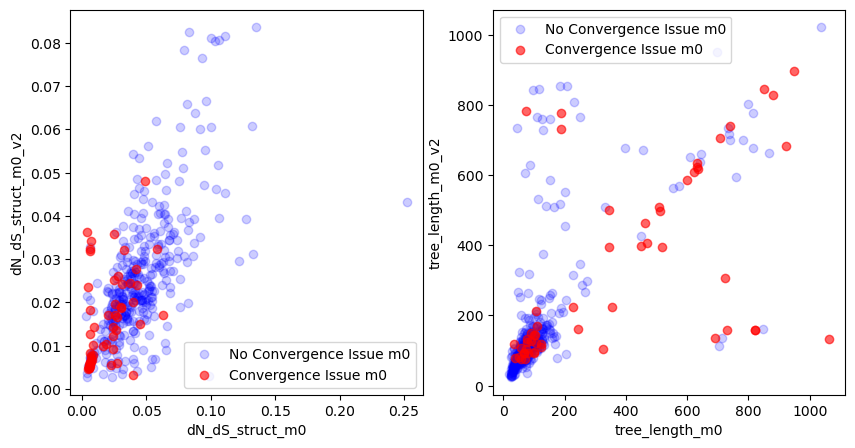

In [4]:
fig, axarr = plt.subplots(1,2, figsize=(10,5))

#xlim = (-0.2,1.2)

x_values = ['dN_dS_struct_m0', 'tree_length_m0'] #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_values = ['dN_dS_struct_m0_v2', 'tree_length_m0_v2'] #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


dnds_struct_data = dnds_merged


for jj, x_value in enumerate(x_values): 
    ax = axarr[jj]
    y_value = y_values[jj]
    
    
    dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue m0')
    dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue m0')  #(dnds_struct_data, 'b',0.2,'') 
    

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        # ax.set_ylim(xlim)
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

# Extract DN/DS from Hyphy Busted

In [2]:
hyphy_base = base_dir + os.sep + os.path.normpath('selection_calculations/hyphy_busted/') + os.sep

In [3]:
# def load_hyphy_busted_data(hyphy_base):
#     # #Extracts hyphy busted containing folders with output from m0 calculations. 
#     og_list = []
#     og_ref_list = []
#     hyphy_data_out = {}
#     partitions = ['0','1','2']
#     partition_label = {'0':'low', '1':'med', '2': 'high'}

#     for og_ref in next(os.walk(hyphy_base))[1]:    #next(os.walk(m0_base))[0] gets just directories - https://stackoverflow.com/questions/141291/how-to-list-only-top-level-directories-in-python
#         #og_ref = 'OG1299_REF_Scer_AF-P00549-F1-model_v2'
#         og = og_ref.split('_')[0]
#         og_ref_list.append(og_ref)
#         og_list.append(og)
#         #print(og_ref)
#         hyphy_dir = hyphy_base + og_ref + os.sep

#         hyphy_json = hyphy_dir + 'hyphy_busted.json'
        
#         try: 
#             with open(hyphy_json, 'r') as f:
#                 hyphy_data = json.load(f) 

#             average_omega = 0
#             average_rate = 0

#             unconstrained_model_data = hyphy_data['fits'][ 'Unconstrained model']['Rate Distributions']

#             output_data = {}
#             for partition in partitions: 
#                 output_data['omega_' + partition_label[partition]] = unconstrained_model_data['Test'][partition]['omega']
#                 output_data['omega_' + partition_label[partition] + '_proportion'] = unconstrained_model_data['Test'][partition]['proportion']
#                 output_data['rate_' + partition_label[partition]] = unconstrained_model_data['Synonymous site-to-site rates'][partition]['rate']
#                 output_data['rate_' + partition_label[partition] + '_proportion'] = unconstrained_model_data['Synonymous site-to-site rates'][partition]['proportion']
#                 output_data['pvalue'] = hyphy_data['test results']['p-value']
#                 average_omega = average_omega + output_data['omega_' + partition_label[partition]]*output_data['omega_' + partition_label[partition] + '_proportion']
#                 average_rate = average_rate + output_data['rate_' + partition_label[partition]]*output_data['rate_' + partition_label[partition] + '_proportion']

#             output_data['omega_avg']=average_omega
#             output_data['rate_avg']= average_rate

#             hyphy_data_out[og_ref] = output_data
        
#         except FileNotFoundError:
#             print(og_ref + ' has no hyphy BUSTED output')
            

#     hyphy_data_df = pd.DataFrame.from_dict(hyphy_data_out, orient='index')

# return hyphy_data_df

hyphy_data_df = dyt.load_hyphy_busted_data(hyphy_base)

# OG1054_REF_Scer_AF-P16861-F1-model_v2 has no hyphy BUSTED output
# OG2960_REF_Scer_AF-P16622-F1-model_v2 has no hyphy BUSTED output
# OG4755_kluyveromyces_marxianus__OG4755__51_759 has no hyphy BUSTED output
# Error:The input alignment must have the number of sites that is divisible by 3 and must not contain stop codons in call to assert(busted.codon_filter.sites*3==busted.codon_data.sites, error_msg);
# The input alignment must have the number of sites that is divisible by 3 and must not contain stop codons in call to assert(busted.codon_filter.sites*3==busted.codon_data.sites, error_msg);


OG1054_REF_Scer_AF-P16861-F1-model_v2 has no hyphy BUSTED output
OG2960_REF_Scer_AF-P16622-F1-model_v2 has no hyphy BUSTED output
OG4755_kluyveromyces_marxianus__OG4755__51_759 has no hyphy BUSTED output


In [5]:
#Make hyphy function
#save hyphy data_df
hyphy_data_df.to_csv(hyphy_base + 'hyphy_busted.csv')

In [7]:
#Load M0 Data
m0_data_df = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0.csv'), index_col = 0 )

dnds_merged_hyphy = m0_data_df.merge(hyphy_data_df, how='inner', left_index = True, right_index=True, suffixes=['_m0', '_hyphy_busted'])



In [8]:
pseudocount = 1e-15
dnds_merged_hyphy['-log10(pval)'] = -np.log10(dnds_merged_hyphy['pvalue'] + pseudocount)

NameError: name 'etc_proteins_clustered' is not defined

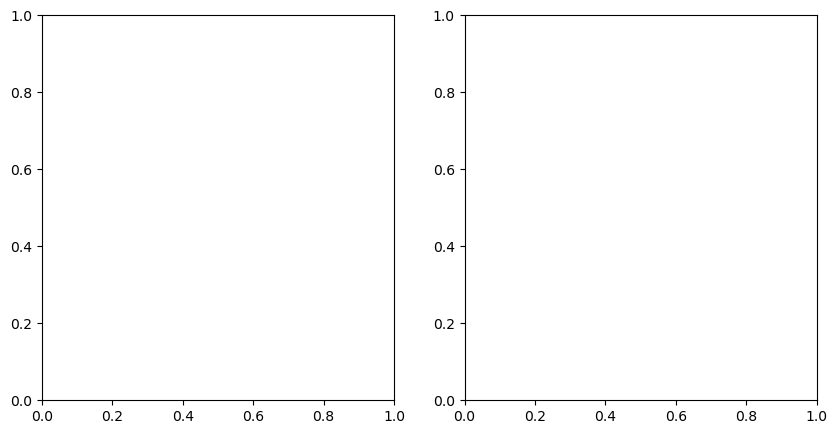

In [9]:
fig, axarr = plt.subplots(1,2, figsize=(10,5))

#xlim = (-0.2,1.2)
ylims = {'omega_avg': (-0.05, 0.9), 
         '-log10(pval)': (-0.5,15.5)
        }

x_values = ['Median(log2(Abundances)) 10 Sp [EXP]','Median(log2(Abundances)) 10 Sp [EXP]']  # ['dN_dS_struct', 'dN_dS_struct'] #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_values = ['omega_avg', '-log10(pval)'] #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


dnds_struct_data = dnds_merged_hyphy

etc_ids = etc_proteins_clustered[etc_proteins_clustered['og_retained']]['primary_id']


for jj, x_value in enumerate(x_values): 
    ax = axarr[jj]
    y_value = y_values[jj]
    
    
    #dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue']==True], 'r',0.6,'Convergence Issue m0')
    #dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue']==False], 'b',0.2,'No Convergence Issue m0')  #(dnds_struct_data, 'b',0.2,'') 
    
    dnds_foreground = (dnds_struct_data.loc[etc_ids,:], 'r',0.6,'ETC Proteins')
    dnds_background = (dnds_struct_data.loc[list(set(dnds_struct_data.index)-set(list(etc_ids))),:], 'b',0.2,'')  #(dnds_struct_data, 'b',0.2,'') 
    

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        ax.set_ylim(ylims[y_value])
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

In [25]:
#omega avg vs YN00
#Load my YN00 Data
yn00_data_df = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00_maxdS_10.csv'), index_col=0)

dnds_merged_hyphy_yn00 = yn00_data_df.merge(hyphy_data_df, how='inner', left_index = True, right_index=True, suffixes=['_yn00', '_hyphy_busted'])

pseudocount = 1e-15
dnds_merged_hyphy_yn00['-log10(pval)'] = -np.log10(dnds_merged_hyphy_yn00['pvalue'] + pseudocount)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


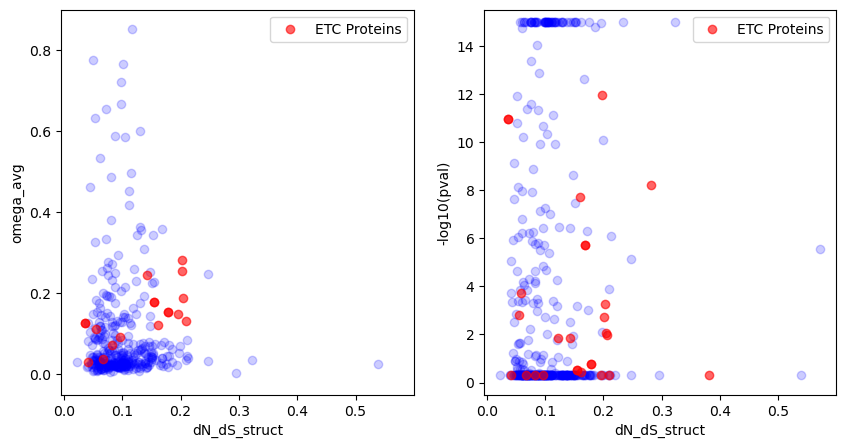

In [26]:
fig, axarr = plt.subplots(1,2, figsize=(10,5))

#xlim = (-0.2,1.2)
ylims = {'omega_avg': (-0.05, 0.9), 
         '-log10(pval)': (-0.5,15.5)
        }

x_values = ['dN_dS_struct', 'dN_dS_struct'] #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_values = ['omega_avg', '-log10(pval)'] #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


dnds_struct_data = dnds_merged_hyphy_yn00

etc_ids = etc_proteins_clustered[etc_proteins_clustered['og_retained']]['primary_id']


for jj, x_value in enumerate(x_values): 
    ax = axarr[jj]
    y_value = y_values[jj]
    
    
    #dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue']==True], 'r',0.6,'Convergence Issue m0')
    #dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue']==False], 'b',0.2,'No Convergence Issue m0')  #(dnds_struct_data, 'b',0.2,'') 
    
    dnds_foreground = (dnds_struct_data.loc[etc_ids,:], 'r',0.6,'ETC Proteins')
    dnds_background = (dnds_struct_data.loc[list(set(dnds_struct_data.index)-set(list(etc_ids))),:], 'b',0.2,'')  #(dnds_struct_data, 'b',0.2,'') 
    

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        ax.set_ylim(ylims[y_value])
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

# DN/DS Comparisons



In [ ]:
#Compare YN00, values from Nielsen Paper to M0

In [64]:
dnds_struct_data.columns

Index(['og_m0', 'tree_length_m0', 'kappa_m0', 'dN_dS_struct_m0',
       'tree_length_dN_m0', 'tree_length_dS_m0',
       'Mean(Conservation Rate) [ALL]', 'CV(Type Conservation Rate) [ALL]',
       'Mean(Type Conservation Rate) [ALL]', 'CV(Conservation Rate) [ALL]',
       'Mean(log2(Abundances)) 10 Sp [EXP]',
       'Median(log2(Abundances)) 10 Sp [EXP]',
       'Std(log2(Abundances)) 10 Sp [EXP]', '1k_Mean_log2_Abundances [EXP]',
       'og_yn00', 'dN_dS_struct_yn00', 'dN_struct_yn00', 'dS_struct_yn00',
       'dN_dS_nielsen_SCE', 'og_x', 'dN_dS_nielsen_03_02', 'og_y'],
      dtype='object')

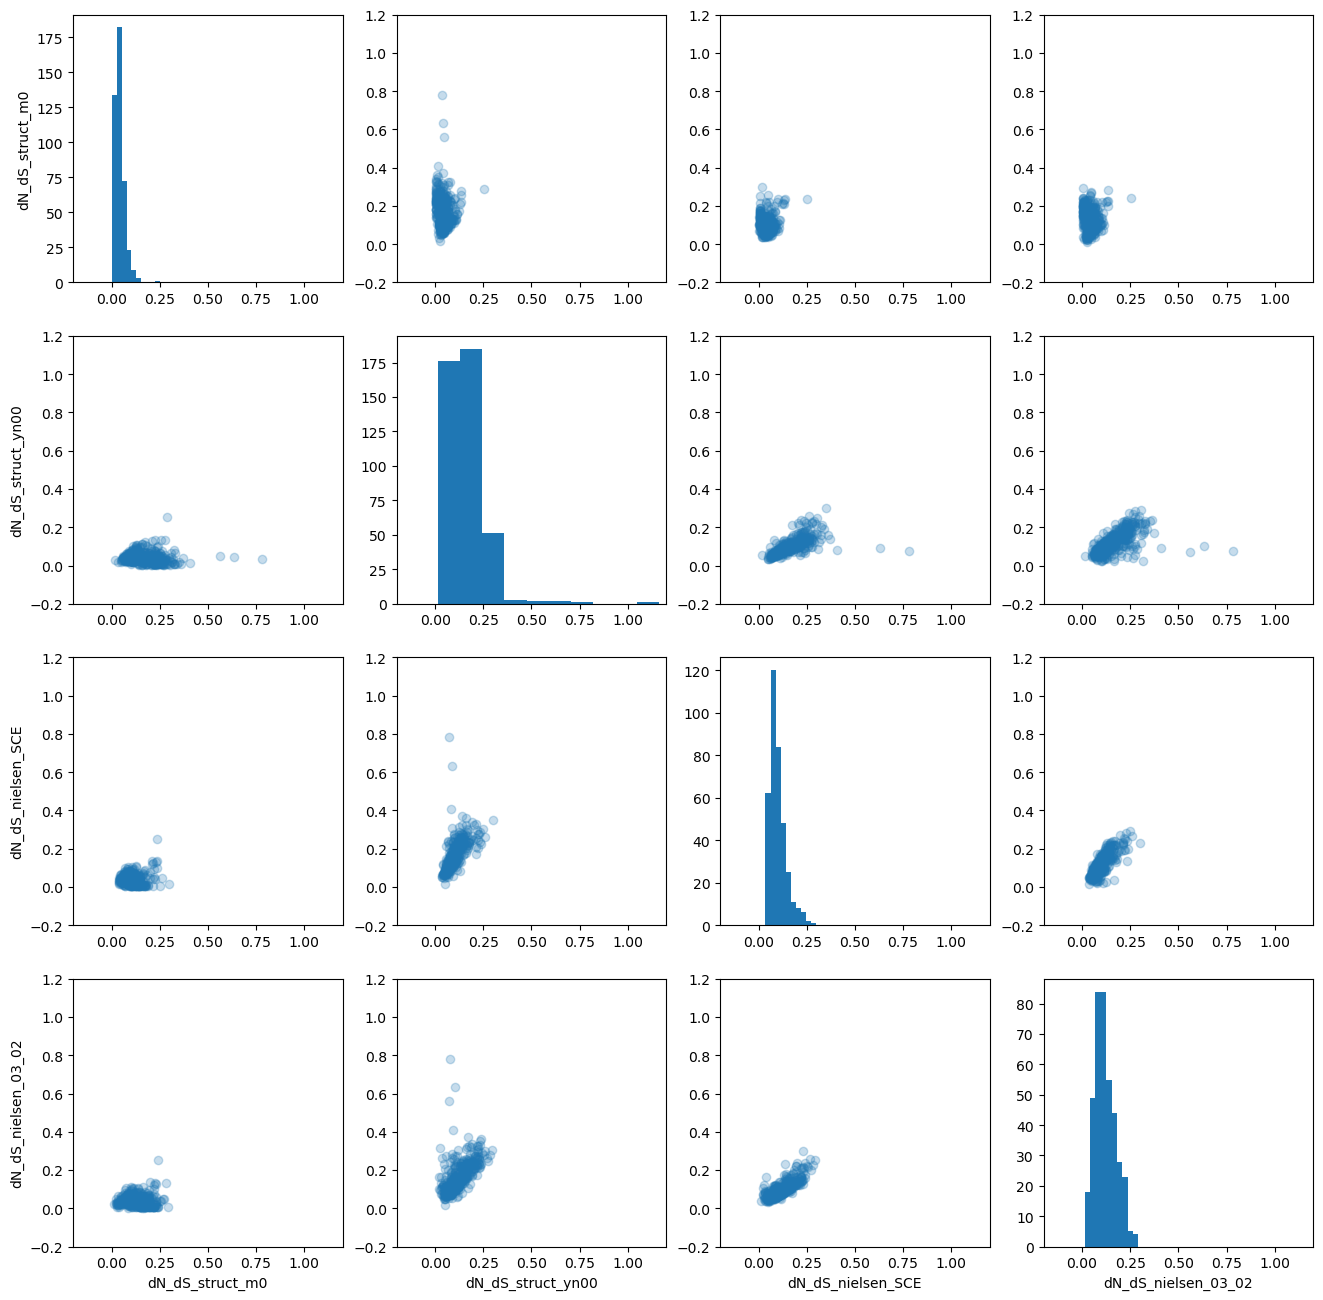

In [72]:
dnds_cols = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, axarr = plt.subplots(len(dnds_cols),len(dnds_cols), figsize=(4*len(dnds_cols),4*(len(dnds_cols))))

xlim = (-0.2,1.2)

#good to quantify r2 here

for jj, dnds_col_jj in enumerate(dnds_cols):
    for kk, dnds_col_kk in enumerate(dnds_cols):
        ax = axarr[jj][kk]
        if jj == kk: 
            ax.hist(dnds_struct_data[dnds_col_jj])
            ax.set_xlim(xlim)
        else: 
            ax.scatter(dnds_struct_data[dnds_col_jj], dnds_struct_data[dnds_col_kk], alpha = 0.25)
            ax.set_xlim(xlim)
            ax.set_ylim(xlim)
        if kk==0: 
            ax.set_ylabel(dnds_col_jj)
        if jj == (len(dnds_cols)-1):
            ax.set_xlabel(dnds_col_kk)



our YN00 DNds and Nielsen Lab dnds are very correlated (apart from outliers with large values).  M0 is smaller and not well correlated with those. 

In [73]:
dnds_struct_data[dnds_struct_data['dN_dS_struct_yn00']>0.4]

,og_m0,tree_length_m0,kappa_m0,dN_dS_struct_m0,tree_length_dN_m0,tree_length_dS_m0,Mean(Conservation Rate) [ALL],CV(Type Conservation Rate) [ALL],Mean(Type Conservation Rate) [ALL],CV(Conservation Rate) [ALL],...,Std(log2(Abundances)) 10 Sp [EXP],1k_Mean_log2_Abundances [EXP],og_yn00,dN_dS_struct_yn00,dN_struct_yn00,dS_struct_yn00,dN_dS_nielsen_SCE,og_x,dN_dS_nielsen_03_02,og_y
og_ref,,,,,,,,,,,,,,,,,,,,,
OG1115_REF_Scer_AF-P06208-F1-model_v2,OG1115,123.617376,1.22458,0.04777,7.1403,149.4628,0.719437,0.073847,0.815603,0.103942,...,0.972957,9.341119,OG1115,0.56150,0.50180,0.91650,NaN,NaN,0.07050,OG1115
OG1230_REF_Scer_AF-P29465-F1-model_v2,OG1230,101.431756,1.23787,0.03595,4.8284,134.3010,0.675546,0.040949,0.804715,0.075825,...,0.772046,4.230896,OG1230,0.78170,1.83330,2.33980,0.0741,OG1230,0.07645,OG1230
OG1254_REF_Scer_AF-P40395-F1-model_v2,OG1254,266.608591,1.79811,0.01443,5.1339,355.7696,0.354468,0.168250,0.572760,0.290056,...,2.029057,NaN,OG1254,0.40765,0.77905,2.04350,0.0807,OG1254,0.09200,OG1254
OG1364_REF_Scer_AF-P27796-F1-model_v2,OG1364,81.567434,1.08378,0.04205,3.9993,95.1127,0.650851,0.056970,0.772934,0.083224,...,1.132560,NaN,OG1364,0.63280,0.54450,0.89970,0.0892,OG1364,0.10130,OG1364
OG1603_REF_Scer_AF-P25632-F1-model_v2,NaN,NaN,NaN,NaN,NaN,NaN,0.245098,0.000000,0.421569,0.000000,...,1.068788,8.788087,OG1603,0.66540,1.70570,2.56350,NaN,NaN,NaN,NaN
OG4312_REF_Scer_AF-P38280-F1-model_v2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,OG4312,1.16070,2.22240,1.91470,NaN,NaN,NaN,NaN
OG5722_alloascoidea_hylecoeti__OG5722__0_1167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,OG5722,0.48000,0.90770,1.86915,NaN,NaN,NaN,NaN


Ouliers of YN00.  Includes RIC1 cluster from the RIC1/COX12 subcluster.  

## M0 check importance of initial omega and CodonFreq=7, estFreq=0

## YN00 and M0 vs Abundance

In [3]:
dnds_struct_data.columns

Index(['og_m0', 'tree_length_m0', 'kappa_m0', 'dN_dS_struct_m0',
       'tree_length_dN_m0', 'tree_length_dS_m0', 'convergence_issue_m0',
       'Mean(Conservation Rate) [ALL]', 'CV(Type Conservation Rate) [ALL]',
       'Mean(Type Conservation Rate) [ALL]', 'CV(Conservation Rate) [ALL]',
       'Mean(log2(Abundances)) 10 Sp [EXP]',
       'Median(log2(Abundances)) 10 Sp [EXP]',
       'Std(log2(Abundances)) 10 Sp [EXP]', '1k_Mean_log2_Abundances [EXP]',
       'og_yn00', 'dN_dS_struct_yn00', 'dN_struct_yn00', 'dS_struct_yn00',
       'dN_dS_nielsen_SCE', 'og_x', 'dN_dS_nielsen_03_02', 'og_y'],
      dtype='object')

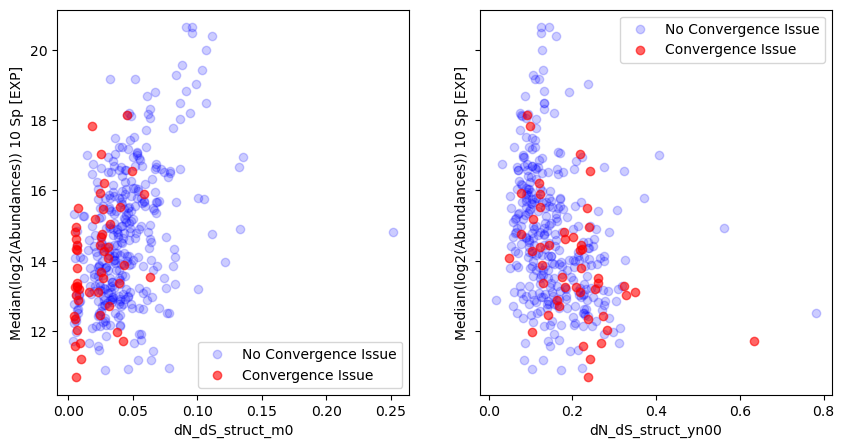

In [10]:
#plot YN00 and M0 vs Abundance
fig, axarr = plt.subplots(1,2, sharey=True, figsize=(10,5))

#xlim = (-0.2,1.2)

x_values = ['dN_dS_struct_m0', 'dN_dS_struct_yn00'] #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'Median(log2(Abundances)) 10 Sp [EXP]' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


for jj, x_value in enumerate(x_values): 
    ax = axarr[jj]
    
    
    dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
    dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')  #(dnds_struct_data, 'b',0.2,'') 
    

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        # ax.set_ylim(xlim)
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

In [ ]:
#plot YN00 and M0 vs conservation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


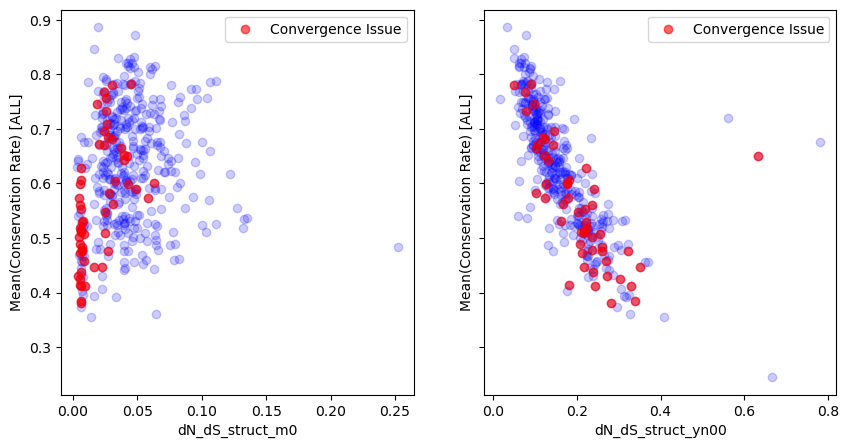

In [9]:
#plot YN00 and M0 vs Abundance
fig, axarr = plt.subplots(1,2, sharey=True, figsize=(10,5))

#xlim = (-0.2,1.2)

x_values = ['dN_dS_struct_m0', 'dN_dS_struct_yn00'] #'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'


for jj, x_value in enumerate(x_values): 
    ax = axarr[jj]
    
    
    dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
    dnds_background = (dnds_struct_data, 'b',0.2,'') #(dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')
    (data_to_plot, color, alpha, label) = dnds_background

    #good to quantify r2 here
    for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
        ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
        # ax.set_xlim(xlim)
        # ax.set_ylim(xlim)
        ax.set_ylabel(y_value)
        ax.set_xlabel(x_value)
        ax.legend()

In [ ]:
#Load YN00 and M0
#Load Abundance

## Many of the DN/DS values changed between YN00 and M0 - why? 

- Which OGs changed the most? 
- Of these, which are very abundant?

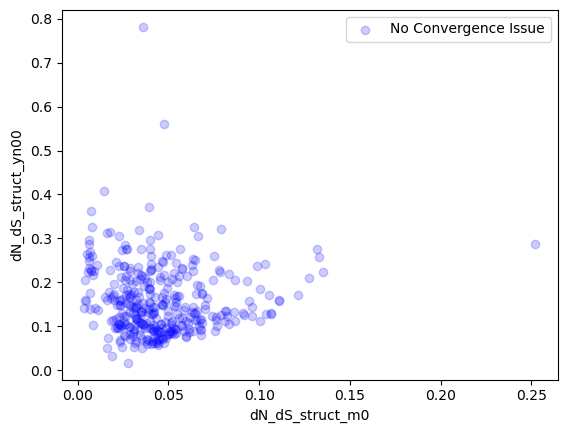

In [3]:
color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_yn00' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

#dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')

(data_to_plot, color, alpha, label) = dnds_background

#good to quantify r2 here
#for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
# ax.set_xlim(xlim)
# ax.set_ylim(xlim)
ax.set_ylabel(y_value)
ax.set_xlabel(x_value)
ax.legend()

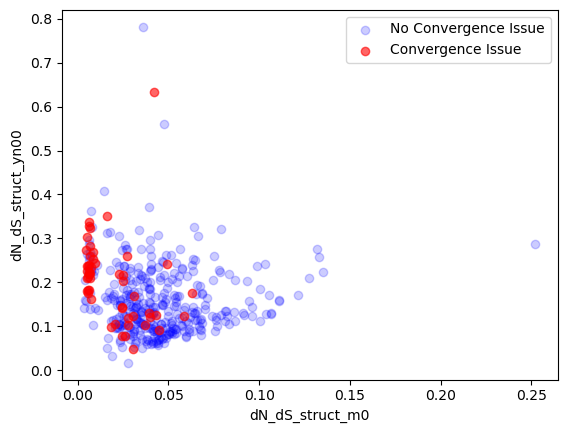

In [15]:
color_col = [ 'dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']

fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value = 'dN_dS_struct_m0'#'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_yn00' #'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')


#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
# ax.set_xlim(xlim)
# ax.set_ylim(xlim)
ax.set_ylabel(y_value)
ax.set_xlabel(x_value)
ax.legend()


- What are the larger YN00 values that are close to 0 for the M0 calculations? 
These seem to have 'convergence issues'

- What are the yn00 outliers that are much smaller for M0
These seem to have bad sequences that cause excessive trimming in yn00

Some of the small ones (OG1273) didn't converge - the branch lengths of the tree in the rub file seem to be balooning. 

In [12]:
#dnds_struct_data[(dnds_struct_data['dN_dS_struct_m0']<0.03)&(dnds_struct_data['dN_dS_struct_yn00']>0.2)].sort_values(by = 'dN_dS_struct_yn00', ascending=False)

OG1230
YN00:  2604 sites
M0: 834 sites
    
    
OG1364
YN00: 12 sites
M0: 1137 sites
    
This could be why my DN/DS Values differ so much between YN00 and M0

In [76]:
col_to_view = ['dN_dS_struct_m0','dN_dS_struct_yn00','dN_dS_nielsen_SCE', 'dN_dS_nielsen_03_02']
dnds_struct_data.loc[['OG1273_REF_Scer_AF-P40012-F1-model_v2','OG3104_REF_Scer_AF-P53954-F1-model_v2'],col_to_view]

,dN_dS_struct_m0,dN_dS_struct_yn00,dN_dS_nielsen_SCE,dN_dS_nielsen_03_02
og_ref,,,,
OG1273_REF_Scer_AF-P40012-F1-model_v2,0.00614,0.32840,0.2126,0.2346
OG3104_REF_Scer_AF-P53954-F1-model_v2,0.00518,0.20875,0.1254,0.2071


That threshold was too high (I did m0 < 0.1 and YN00 > 0.3) - these ones were those with the highest YN00

I changed to m0<0.03 and YN00 > 0.2 and picked a few in the middle of that to understand this cloud which shrunk the most. 

OG1273_REF_Scer_AF-P40012-F1-model_v2
YN00


OG3104_REF_Scer_AF-P53954-F1-model_v2


Both of those have 'Check Convergence in the M0 calculation' 

In [9]:
#OG1299 looks 'normal' in terms of M0 and YN00
dnds_struct_data[(dnds_struct_data['dN_dS_struct_m0']>0.025)&(dnds_struct_data['og_m0']=='OG1299')]

,og_m0,tree_length_m0,kappa_m0,dN_dS_struct_m0,tree_length_dN_m0,tree_length_dS_m0,convergence_issue_m0,Mean(Conservation Rate) [ALL],CV(Type Conservation Rate) [ALL],Mean(Type Conservation Rate) [ALL],...,Std(log2(Abundances)) 10 Sp [EXP],1k_Mean_log2_Abundances [EXP],og_yn00,dN_dS_struct_yn00,dN_struct_yn00,dS_struct_yn00,dN_dS_nielsen_SCE,og_x,dN_dS_nielsen_03_02,og_y
og_ref,,,,,,,,,,,,,,,,,,,,,
OG1299_REF_Scer_AF-P00549-F1-model_v2,OG1299,35.541141,1.33863,0.0832,3.1528,37.8925,False,0.758158,0.053904,0.853132,...,2.395779,15.117014,OG1299,0.1063,0.1579,1.49275,0.0796,OG1299,0.1723,OG1299


In [ ]:
#Check OG1273's tree and OG1299's tree

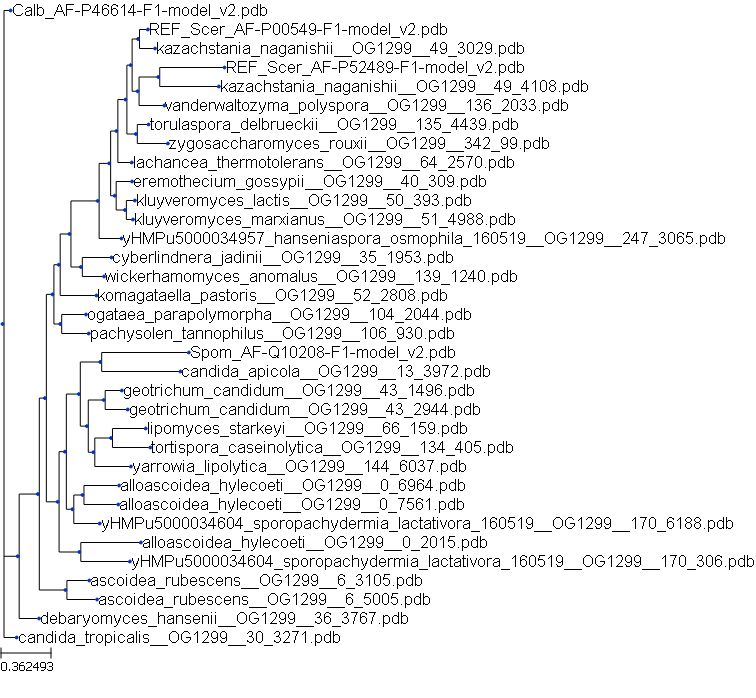

In [13]:
tree_fname_base = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
og_ref = 'OG1299_REF_Scer_AF-P00549-F1-model_v2'

fname_tree = tree_fname_base + os.sep + og_ref + '.tm.fasta.clipkit.treefile'

t = Tree(fname_tree, format=1)  
t.ladderize
t.render('%%inline')

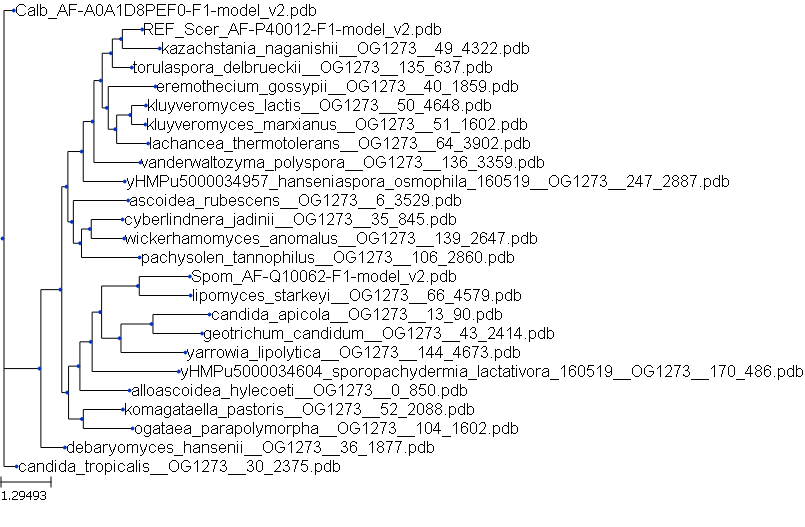

In [12]:
#Tree for 1273
tree_fname_base = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
og_ref = 'OG1273_REF_Scer_AF-P40012-F1-model_v2'

fname_tree = tree_fname_base + os.sep + og_ref + '.tm.fasta.clipkit.treefile'

t = Tree(fname_tree, format=1)  
t.ladderize
t.render('%%inline')

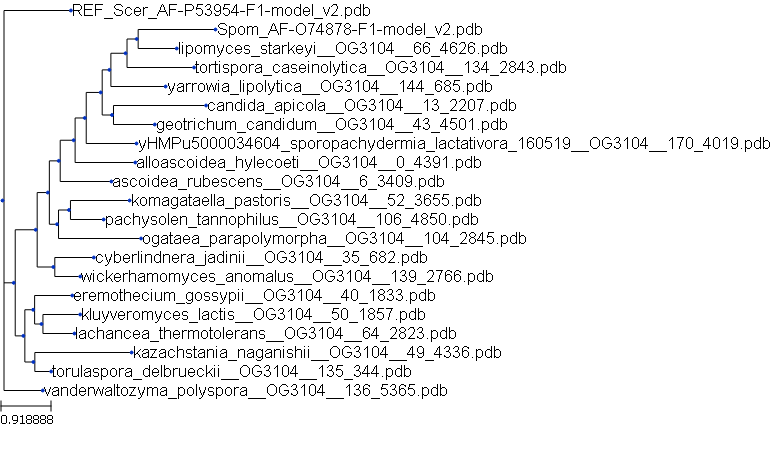

In [14]:
#Tree for OG3104
tree_fname_base = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
og_ref = 'OG3104_REF_Scer_AF-P53954-F1-model_v2'

fname_tree = tree_fname_base + os.sep + og_ref + '.tm.fasta.clipkit.treefile'

t = Tree(fname_tree, format=1)  
t.ladderize
t.render('%%inline')

,og_m0,tree_length_m0,kappa_m0,dN_dS_struct_m0,tree_length_dN_m0,tree_length_dS_m0,convergence_issue_m0,Mean(Conservation Rate) [ALL],CV(Type Conservation Rate) [ALL],Mean(Type Conservation Rate) [ALL],...,Std(log2(Abundances)) 10 Sp [EXP],1k_Mean_log2_Abundances [EXP],og_yn00,dN_dS_struct_yn00,dN_struct_yn00,dS_struct_yn00,dN_dS_nielsen_SCE,og_x,dN_dS_nielsen_03_02,og_y
og_ref,,,,,,,,,,,,,,,,,,,,,
OG1103_REF_Scer_AF-P47771-F1-model_v2,OG1103,243.163964,1.26457,0.02524,7.6592,303.4033,True,0.548045,0.088189,0.703572,...,1.586885,5.434599,OG1103,0.20250,0.46775,2.30740,NaN,NaN,NaN,NaN
OG1168_REF_Scer_AF-P32528-F1-model_v2,OG1168,228.416543,1.18857,0.00543,1.7010,313.3773,True,0.413832,0.159550,0.590165,...,1.139182,NaN,OG1168,0.18190,0.48800,2.68425,NaN,NaN,NaN,NaN
OG1273_REF_Scer_AF-P40012-F1-model_v2,OG1273,949.771126,1.29963,0.00614,7.9935,1301.3071,True,0.412810,0.092045,0.598231,...,0.627241,NaN,OG1273,0.32840,0.82220,2.38190,0.2126,OG1273,0.23460,OG1273
OG1364_REF_Scer_AF-P27796-F1-model_v2,OG1364,81.567434,1.08378,0.04205,3.9993,95.1127,True,0.650851,0.056970,0.772934,...,1.132560,NaN,OG1364,0.63280,0.54450,0.89970,0.0892,OG1364,0.10130,OG1364
OG1471_REF_Scer_AF-P33333-F1-model_v2,OG1471,822.236092,1.71437,0.00632,6.6484,1051.5854,True,0.514380,0.076896,0.693459,...,0.802437,7.618378,OG1471,0.21850,0.48590,2.15070,0.1448,OG1471,0.13990,OG1471
OG1556_REF_Scer_AF-P32895-F1-model_v2,OG1556,66.553253,1.20629,0.03066,2.6312,85.8256,True,0.780882,0.045694,0.870499,...,0.808581,7.975216,OG1556,0.04880,0.10160,2.08360,0.0434,OG1556,0.05130,OG1556
OG1630_REF_Scer_AF-P50264-F1-model_v2,OG1630,343.422486,1.28485,0.01624,7.3593,453.0662,True,0.447118,0.118472,0.625970,...,1.876720,NaN,OG1630,0.35000,0.82430,2.38740,0.2997,OG1630,0.23190,OG1630
OG1659_REF_Scer_AF-P32775-F1-model_v2,OG1659,58.398288,1.24569,0.02647,2.1805,82.3682,True,0.708529,0.061661,0.812432,...,0.700993,6.841240,OG1659,NaN,NaN,NaN,0.0517,OG1659,0.03520,OG1659
OG1665_REF_Scer_AF-P10869-F1-model_v2,OG1665,103.626764,1.25756,0.03032,3.8804,127.9598,True,0.681910,0.061217,0.800257,...,0.887801,9.566026,OG1665,0.12290,0.27220,2.39550,0.0685,OG1665,0.07650,OG1665


In [26]:
#As these trees seem 'longer' is this something general about the ogs that were hard to calculate? 

#Use phykit to calculate various quantities

# Use from call_code_singularity_bens_cpu.sh to call 20230317_calculate_tree_quantities.sh

tree_quantities = pd.read_csv(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees/tree_data.csv'),index_col=0)
dnds_struct_data_tree = dnds_struct_data.merge(tree_quantities.loc[:,['total_tree_length']], how='left', left_index = True, right_index=True)
dnds_struct_data_tree = dnds_struct_data.merge(tree_quantities.loc[:,'total_tree_length'], how='left', left_index = True, right_index=True)

tree_len_conv = dnds_struct_data_tree[dnds_struct_data_tree['convergence_issue_m0']==False]['total_tree_length']
tree_len_no_conv = dnds_struct_data_tree[dnds_struct_data_tree['convergence_issue_m0']==True]['total_tree_length']

plt.boxplot([tree_len_conv, tree_len_no_conv], labels=['no convergence issue','convergence issue'])

In [35]:
dnds_struct_data_tree = dnds_struct_data.merge(tree_quantities.loc[:,['total_tree_length']], how='left', left_index = True, right_index=True)


{'whiskers': [<matplotlib.lines.Line2D at 0x2edb7c99188>,
 'caps': [<matplotlib.lines.Line2D at 0x2edb7c99b48>,
 'boxes': [<matplotlib.lines.Line2D at 0x2edb7c96488>,
 'medians': [<matplotlib.lines.Line2D at 0x2edb7ca2848>,
 'fliers': [<matplotlib.lines.Line2D at 0x2edb7ca2b48>,
 'means': []}

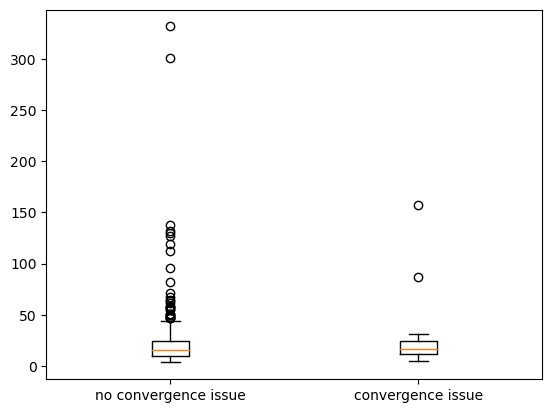

In [39]:
dnds_struct_data_tree = dnds_struct_data.merge(tree_quantities.loc[:,'total_tree_length'], how='left', left_index = True, right_index=True)

tree_len_conv = dnds_struct_data_tree[dnds_struct_data_tree['convergence_issue_m0']==False]['total_tree_length']
tree_len_no_conv = dnds_struct_data_tree[dnds_struct_data_tree['convergence_issue_m0']==True]['total_tree_length']

plt.boxplot([tree_len_conv, tree_len_no_conv], labels=['no convergence issue','convergence issue'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2edb7e5d8c8>,
 'caps': [<matplotlib.lines.Line2D at 0x2edb7e627c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2edb7e5ac48>,
 'medians': [<matplotlib.lines.Line2D at 0x2edb7e6b088>,
 'fliers': [<matplotlib.lines.Line2D at 0x2edb7e6ba88>,
 'means': []}

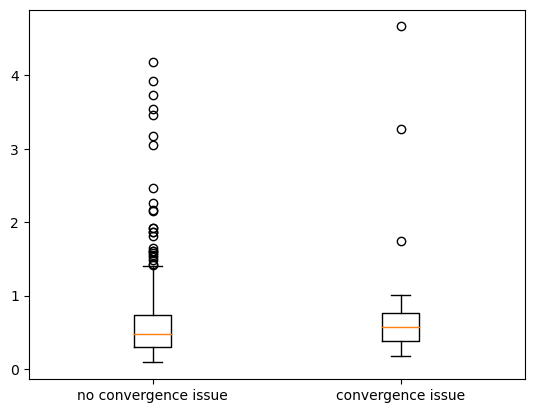

In [41]:
tree_quantities = pd.read_csv(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees/tree_data.csv'),index_col=0)

quantity_of_interest = 'mean_term_branches'

dnds_struct_data_tree = dnds_struct_data.merge(tree_quantities.loc[:,quantity_of_interest], how='left', left_index = True, right_index=True)
dnds_struct_data_tree = dnds_struct_data.merge(tree_quantities.loc[:,quantity_of_interest], how='left', left_index = True, right_index=True)

tree_len_conv = dnds_struct_data_tree[dnds_struct_data_tree['convergence_issue_m0']==False][quantity_of_interest]
tree_len_no_conv = dnds_struct_data_tree[dnds_struct_data_tree['convergence_issue_m0']==True][quantity_of_interest]

plt.boxplot([tree_len_conv, tree_len_no_conv], labels=['no convergence issue','convergence issue'])

1) Can YN00 use cleandata = 1? 

ran with 20230301_run_yn00_test_cleandata.sh (via call_code_singularity_bens_cpu.sh)

NO: I get this error

YN00 in paml version 4.10.6, November 2022

Reading options from /home/heineike_wsl2/alphafold/selection_calculations/m0_yn00_comparison/yn00/OG1364_REF_Scer_AF-P27796-F1-model_v2/yn00.ctl.

option cleandata in /home/heineike_wsl2/alphafold/selection_calculations/m0_yn00_comparison/yn00/OG1364_REF_Scer_AF-P27796-F1-model_v2/yn00.ctl


2) Calculate YN00 for OG1230 and OG1364 after deleting the two trouble sequences

In [69]:
#Ran 20230301_struct_align_dnds_msas_yn00_filter.py from call_code_singularity_bens_cpu.sh

alignment = 'OG1230_REF_Scer_AF-P29465-F1-model_v2'#'OG1364_REF_Scer_AF-P27796-F1-model_v2'
yn00_dir = base_dir + os.sep + os.path.normpath('selection_calculations/m0_yn00_comparison/yn00/' + alignment + '_filtered') + os.sep
output_file = yn00_dir + 'yn00.csv'
paml_gene_dn_ds_file = yn00_dir +  'yn00.out'
(dN_dS, dN, dS) = dyt.calMean_dN_dS_yn00(paml_gene_dn_ds_file, output_file, method="median dN_dS, dN, dS")
print((dN_dS, dN, dS))
#dN_dS_struct.append(dN_dS)
#dN_struct.append(dN)
#dS_struct.append(dS)

(0.0908, 0.2375, 2.6158)


3) Plot M0 for OG1230, OG1364, and also two that had a convergence warning (OG1273 and OG3104) when I remove the trouble sequences. 

On my computer run '20230307_struct_align_dnds_msas_m0_filter.py' via call_code_singularity
On the server run 


In [22]:
alignment = 'OG1273_REF_Scer_AF-P40012-F1-model_v2'

tree_orig = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees/' + alignment + '.tm.fasta.clipkit.treefile')
tree_renamed = tree_orig+'.renamed'

tree_filtered = tree_orig + '.filtered'
full_tree = Tree(tree_renamed, format=1) #Using flexible with internal node names as support is not in the right format to load with format = 0
full_tree.prune(list(aln_len_df_filt['seq_id']))
full_tree.write(format=5, outfile = tree_filtered)



In [11]:
seq_filt_thresh = 0.85
msa_cds_trimmed = base_dir + os.sep +  os.path.normpath('msas/structural/tm_align/cds_trim_strict/' + alignment +  '.tm.fasta.clipkit.cds')
msa_cds_trimmed_renamed = msa_cds_trimmed+'.renamed' 
msa_cds_trimmed_seqs = SeqIO.parse(msa_cds_trimmed_renamed, 'fasta')

seq_ids = []
aln_len_sq = [] 

for record in msa_cds_trimmed_seqs: 
    seq_ids.append(record.id)
    seq_squeezed = len([res for res in record.seq if res!='-'])
    aln_len_sq.append(seq_squeezed)
aln_len = len(record.seq)

aln_len_df = pd.DataFrame.from_dict({'seq_id': seq_ids,'seq_len_squeeze':aln_len_sq})
aln_len_df['seq_len_pct'] = aln_len_df['seq_len_squeeze']/aln_len

aln_len_df_filt = aln_len_df[aln_len_df['seq_len_pct']>seq_filt_thresh]


In [12]:
aln_len_df_filt

,seq_id,seq_len_squeeze,seq_len_pct
0,OG1273_0,1359,0.993421
1,OG1273_1,1368,1.000000
2,OG1273_2,1320,0.964912
3,OG1273_3,1323,0.967105
4,OG1273_4,1365,0.997807
5,OG1273_5,1350,0.986842
6,OG1273_6,1359,0.993421
7,OG1273_7,1362,0.995614
8,OG1273_8,1365,0.997807
9,OG1273_9,1368,1.000000


In [16]:
list(aln_len_df_filt['seq_id'])

['OG1273_0',
 'OG1273_1',
 'OG1273_2',
 'OG1273_3',
 'OG1273_4',
 'OG1273_5',
 'OG1273_6',
 'OG1273_7',
 'OG1273_8',
 'OG1273_9',
 'OG1273_10',
 'OG1273_11',
 'OG1273_12',
 'OG1273_13',
 'OG1273_14',
 'OG1273_15',
 'OG1273_16',
 'OG1273_17',
 'OG1273_18',
 'OG1273_19',
 'OG1273_20',
 'OG1273_21',
 'OG1273_22',
 'OG1273_24']

In [19]:
full_tree.write()

'(OG1273_0:0.2155,((((((((OG1273_1:0.47461,OG1273_11:0.92992)1:0.18165,OG1273_19:0.46494)1:0.1845,(OG1273_9:1.18155,((OG1273_12:0.33395,OG1273_13:0.31556)1:0.3092,OG1273_15:0.77596)1:0.1396)1:0.07844)1:0.13681,OG1273_20:1.16236)1:0.19948,OG1273_23:1.03685)1:0.32019,(OG1273_4:1.38141,((OG1273_7:0.7726,OG1273_21:0.81301)1:0.17383,OG1273_18:1.46625)1:0.13402)1:0.06383)1:0.08058,(((((OG1273_2:1.27297,OG1273_16:1.29017)1:0.89732,((OG1273_5:1.42549,OG1273_10:1.23312)1:0.75056,OG1273_24:1.62813)1:0.42354)1:0.16783,OG1273_22:2.20712)1:0.23916,OG1273_3:1.24811)1:0.21627,(OG1273_14:0.98736,OG1273_17:1.23495)1:0.30455)1:0.09799)1:0.46325,OG1273_8:0.58424)1:0.87764,OG1273_6:0.28767);'

In [23]:
full_tree.write(format=5)

'(OG1273_0:0.2155,((((((((OG1273_1:0.47461,OG1273_11:0.92992):0.18165,OG1273_19:0.46494):0.1845,(OG1273_9:1.18155,((OG1273_12:0.33395,OG1273_13:0.31556):0.3092,OG1273_15:0.77596):0.1396):0.07844):0.13681,OG1273_20:1.16236):0.19948,OG1273_23:1.03685):0.32019,(OG1273_4:1.38141,((OG1273_7:0.7726,OG1273_21:0.81301):0.17383,OG1273_18:1.46625):0.13402):0.06383):0.08058,(((((OG1273_2:1.27297,OG1273_16:1.29017):0.89732,((OG1273_5:1.42549,OG1273_10:1.23312):0.75056,OG1273_24:1.62813):0.42354):0.16783,OG1273_22:2.20712):0.23916,OG1273_3:1.24811):0.21627,(OG1273_14:0.98736,OG1273_17:1.23495):0.30455):0.09799):0.46325,OG1273_8:0.58424):0.87764,OG1273_6:0.28767);'


4) Calculate the trimming ratios for YN00 and M0, plot these
    A) Is the correspondence for M0 and YN00 better when there is not as much trimming in YN00? 

In [ ]:
for jj, dnds_col in enumerate(dnds_cols):
    for kk, param_to_plot in enumerate(params_to_plot):
        ax = axarr[jj][kk]
        ax.scatter(struct_data_to_plot_df[param_to_plot], struct_data_to_plot_df[dnds_col], alpha = 0.25)
        ax.set_ylabel(dnds_col)
        ax.set_xlabel(param_to_plot)

## What are the high abundance, high dnds(M0) orthogroups? 

They aren't the ETC Proteins



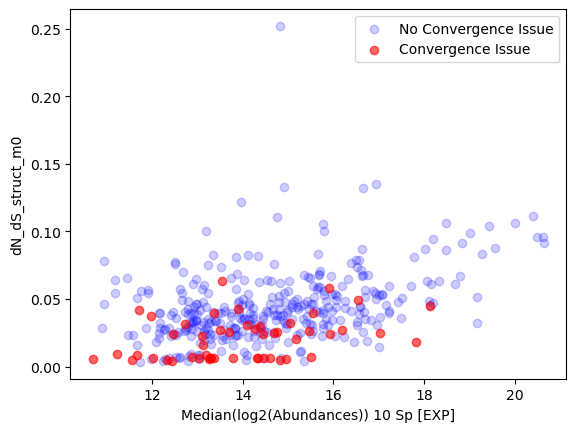

In [13]:
fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

x_value =  'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0'#'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_foreground = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==True], 'r',0.6,'Convergence Issue')
dnds_background = (dnds_struct_data[dnds_struct_data['convergence_issue_m0']==False], 'b',0.2,'No Convergence Issue')


#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], color = color, alpha = alpha, label=label)
# ax.set_xlim(xlim)
# ax.set_ylim(xlim)
ax.set_ylabel(y_value)
ax.set_xlabel(x_value)
ax.legend()

In [27]:
cols_to_view = ['dN_dS_struct_m0','Median(log2(Abundances)) 10 Sp [EXP]', 'dN_dS_struct_yn00']
dnds_struct_data[(dnds_struct_data['dN_dS_struct_m0']>0.075)&(dnds_struct_data['Median(log2(Abundances)) 10 Sp [EXP]']>17)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,cols_to_view]

,dN_dS_struct_m0,Median(log2(Abundances)) 10 Sp [EXP],dN_dS_struct_yn00
og_ref,,,
OG1145_REF_Scer_AF-P00358-F1-model_v2,0.11116,20.400527,0.16000
OG1193_REF_Scer_AF-P00924-F1-model_v2,0.10633,20.009531,0.12785
OG1208_REF_Scer_AF-P04806-F1-model_v2,0.10633,18.490435,0.13105
OG1813_REF_Scer_AF-P05694-F1-model_v2,0.10394,19.429356,0.12870
OG1631_REF_Scer_AF-P22217-F1-model_v2,0.09900,19.017555,0.23670
OG1432_REF_Scer_AF-P14540-F1-model_v2,0.09617,20.489390,0.12420
OG1424_REF_Scer_AF-P00560-F1-model_v2,0.09583,20.637585,0.14455
OG1112_REF_Scer_AF-P23254-F1-model_v2,0.09457,18.206976,0.15710
OG2794_REF_Scer_AF-P00950-F1-model_v2,0.09144,20.648300,0.12540


In [ ]:
Many of these appeared to be paralogs. 

OG1145 TDH3 - paralogs
OG1193 ENO1/ERR3/ERR2/ENO2/ERR1 - Paralogs
OG1208 HXK1/2 - paralogs
OG1813 Met6 (a paralog in species 43)
OG1631: TRX1/TRX2 - paralogs
OG1432: FBA1 -(paralogs but not in SC)
OG1424: PGK1 (paralog in species 43, species 49)
OG1112: TKL1/TKL2 - paralogs
OG2794: GPM1 - paralogs in species 0, 6
OG1892: GDH1/GDH3
OG1060: THI3/PDC1/PDC5/PDC6/MRK1 - paralogs
OG3063: YNK1 - NO paralogs
OG1835: MDH1 - paralogs in speies 6
OG1299: PYK1/PYK2 - paralogs
OG1016: ADH1/ADH2/ADH3/ADH5 - Paralogs

In [78]:
paralog_data =[]
proteome_dir = base_dir + os.sep + os.path.normpath('selected_proteins/og_sequences/proteome_tm')
for proteome_file in os.listdir(proteome_dir):
    #proteome_file =  base_dir + os.sep +  os.path.normpath('selected_proteins/og_sequences/proteome_tm/OG1004_REF_Scer_AF-P15938-F1-model_v2.pep.fasta')

    og_ref = proteome_file.split('.')[0]

    proteome_seqs = SeqIO.parse(proteome_dir + os.sep + proteome_file, format='fasta')
    specs = []
    for record in proteome_seqs:
        spec = dyt.species_from_fasta_id(record.id)
        specs.append(spec)

    ngenes = len(specs)
    nspecs = len(set(specs))
    paralogs = (ngenes > nspecs)
    nparalogs = ngenes - nspecs
    spec_counts = Counter(specs)
    paralog_specs = [spec_count[0] for spec_count in spec_counts.items() if spec_count[1]>1]
    nparalog_specs = len(set(paralog_specs))
    paralog_pct = nparalog_specs/nspecs
    paralog_data.append((og_ref,specs, ngenes, nspecs, paralogs,nparalogs,paralog_specs, nparalog_specs, paralog_pct))

paralog_data_df = pd.DataFrame(paralog_data, columns = ['og_ref','species','ngenes','nspecies','paralogs','nparalogs','paralog_species','nparalog_species','paralog_pct'])
paralog_data_df.set_index('og_ref', inplace=True)
paralog_data_df.to_csv(base_dir + os.sep + os.path.normpath('selected_proteins/paralog_data.csv'))
#pd.read_csv(base_dir + os.sep + os.path.normpath('selected_proteins/paralog_data.csv'), index_col = 0)

Text(0.5, 0, 'Median(log2(Abundances)) 10 Sp [EXP]')

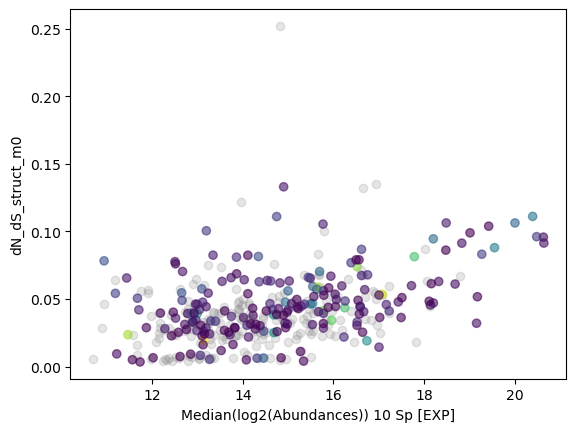

In [96]:
## Plot m0 vs abundance with paralog percentage as color
fig, ax = plt.subplots()

#xlim = (-0.2,1.2)

dnds_struct_data_paralogs = dnds_struct_data.merge(paralog_data_df.loc[:,['paralog_pct', 'paralogs']], left_index = True, right_index=True, how = 'left')

x_value =  'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0'#'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

dnds_foreground = (dnds_struct_data_paralogs[dnds_struct_data_paralogs['paralogs']==True], dnds_struct_data_paralogs[dnds_struct_data_paralogs['paralogs']==True]['paralog_pct'],0.6,'Paralogs')
dnds_background = (dnds_struct_data_paralogs[dnds_struct_data_paralogs['paralogs']==False], 'gray',0.2,'No Paralogs')


#good to quantify r2 here
for (data_to_plot, color, alpha, label) in [dnds_background, dnds_foreground]:
    ax.scatter(data_to_plot[x_value], data_to_plot[y_value], c = color, alpha = alpha, label=label)
# ax.set_xlim(xlim)
# ax.set_ylim(xlim)
ax.set_ylabel(y_value)
ax.set_xlabel(x_value)
#ax.legend()

## M0 vs abundance with ETC Enzymes highlighted

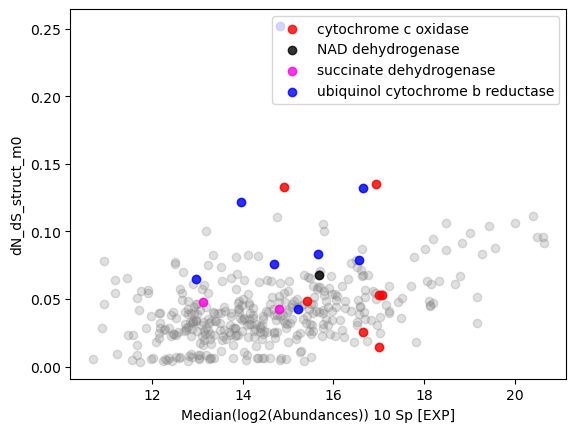

In [22]:
#Abundance and ETC enzymes colored in
fig, ax = plt.subplots(1,1)

enzymes = {'cytochrome c oxidase': 'r',
           'NAD dehydrogenase': 'k',
           'succinate dehydrogenase': '#fc03e3', 
           'ubiquinol cytochrome b reductase': 'b'
          }

x_value =  'Median(log2(Abundances)) 10 Sp [EXP]'#'Mean(Conservation Rate) [ALL]' #'dN_dS_struct_yn00'#'dN_dS_struct_m0'
y_value = 'dN_dS_struct_m0'#'dN_dS_struct_yn00' #'dN_dS_nielsen_SCE'#'dN_dS_struct_yn00'

ax.scatter(dnds_struct_data[x_value], dnds_struct_data[y_value], alpha = 0.25, c= 'grey')

legend_handles = []
legend_labels = []
for enzyme, color in enzymes.items(): 
    dnds_struct_data_subset = dnds_struct_data[dnds_struct_data.index.isin(etc_proteins_clustered[etc_proteins_clustered['enzyme']==enzyme]['og_ref'])]
    handle = ax.scatter(dnds_struct_data_subset[x_value], dnds_struct_data_subset[y_value],color=color ,alpha = 0.8)
    legend_handles.append(handle)
    legend_labels.append(enzyme)
    
ax.set_xlabel(x_value)
ax.set_ylabel(y_value)
ax.legend(legend_handles, legend_labels)

In [ ]:
# DN/DS vs Conservation Rate

In [213]:
#struct_data_to_plot_df[(struct_data_to_plot_df['Mean(Conservation rate AA)']<0.5)&(struct_data_to_plot_df['dN_dS_SCE']<0.15)]

In [214]:
#struct_data_to_plot_df[(struct_data_to_plot_df['Mean(Conservation rate AA)']<0.5)&(struct_data_to_plot_df['dN_dS_SCE']>0.20)]

In [218]:
# #Pick OGs that have higher dN/dS
# #4150, 2603, 
# #and lower: 
# #3677, 2845 
selected_og_refs = ['OG4150_REF_Scer_AF-P07256-F1-model_v2', 'OG2603_REF_Scer_AF-P50076-F1-model_v2', 'OG2845_REF_Scer_AF-P43577-F1-model_v2', 'OG3677_REF_Scer_AF-P47125-F1-model_v2', 'OG1299_REF_Scer_AF-P00549-F1-model_v2']
selected_ogs = [og_ref.split('_')[0] for og_ref in selected_og_refs]
struct_data_to_plot_df[struct_data_to_plot_df['og'].isin(selected_ogs)]

,og,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03
13,OG1299,OG1299_REF_Scer_AF-P00549-F1-model_v2,0.974529,0.735859,0.828039,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723
64,OG4150,OG4150_REF_Scer_AF-P07256-F1-model_v2,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,0.2826
374,OG2845,OG2845_REF_Scer_AF-P43577-F1-model_v2,0.897537,0.488116,0.615662,OG2845.out_yn00,0.1453,OG2845.out_yn00,0.1342
388,OG3677,OG3677_REF_Scer_AF-P47125-F1-model_v2,0.821292,0.494179,0.641265,OG3677.out_yn00,0.0904,OG3677.out_yn00,0.1178
405,OG2603,OG2603_REF_Scer_AF-P50076-F1-model_v2,0.806508,0.467627,0.656083,OG2603.out_yn00,0.2158,OG2603.out_yn00,0.2577
413,OG1299,OG1299_REF_Scer_AF-P52489-F1-model_v2,0.971635,0.637307,0.763982,OG1299.out_yn00,0.0796,OG1299.out_yn00,0.1723


In [13]:
struct_data_dnds

,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
0,OG4352,OG4352_REF_Scer_AF-P00127-F1-model_v2,0.515006,0.488312,0.583829,OG4352.out_yn00,0.0924,OG4352.out_yn00,0.11860,0.1301,0.30970,2.7347,OG4352
1,OG3208,OG3208_REF_Scer_AF-P00128-F1-model_v2,0.983085,0.577829,0.742639,OG3208.out_yn00,0.1655,OG3208.out_yn00,0.14910,0.2197,0.40350,1.8272,OG3208
2,OG1016,OG1016_REF_Scer_AF-P00330-F1-model_v2,0.954863,0.736954,0.817145,NaN,NaN,NaN,NaN,0.1130,0.19800,1.7722,OG1016
3,OG1016,OG1016_REF_Scer_AF-P00331-F1-model_v2,0.938285,0.737345,0.817970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OG1145,OG1145_REF_Scer_AF-P00358-F1-model_v2,0.994326,0.769694,0.856194,NaN,NaN,OG1145.out_yn00,0.09955,0.1600,0.18535,1.2456,OG1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,NaN,OG6290_eremothecium_gossypii__OG6290__40_1372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG6290
546,NaN,OG6574_eremothecium_gossypii__OG6574__40_137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2330,0.45360,1.9462,OG6574
547,NaN,OG6598_kazachstania_naganishii__OG6598__49_1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG6598
548,NaN,OG7278_kazachstania_naganishii__OG7278__49_2415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3026,0.67650,2.0996,OG7278


NameError: name 'selected_og_refs' is not defined

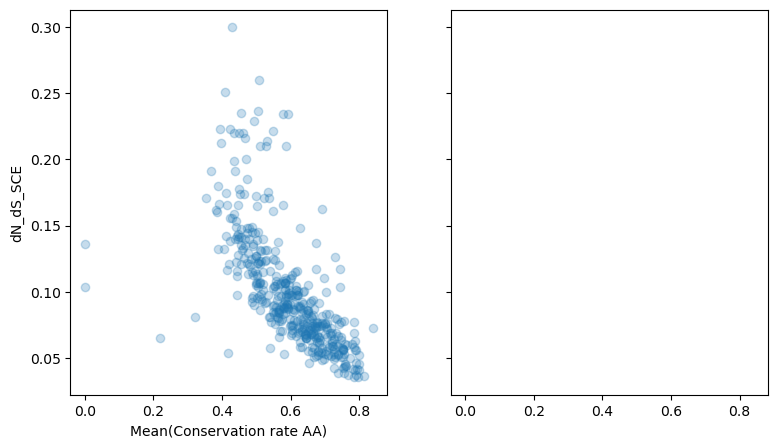

In [36]:
#Plot dN/dS for structural vs Neilsen

struct_data_dnds = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/yn00/yn00_struct_neilsen.csv'))

fig, axarr = plt.subplots(1,2, figsize=(9,5), sharex=True, sharey = True)
dnds_seq_cols = [ 'dN_dS_SCE', 'dN_dS_struct']

for jj, dnds_seq_col in enumerate(dnds_seq_cols):   
    ax = axarr[jj]
    ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds[dnds_seq_col], alpha = 0.25)
    ax.set_ylabel(dnds_seq_col)
    ax.set_xlabel('Mean(Conservation rate AA)')
    
    struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(selected_og_refs)]
    
    ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset[dnds_seq_col],color='r' ,alpha = 0.8)
    ax.set_ylabel(dnds_seq_col)
    ax.set_xlabel('Mean(Conservation rate AA)')
    

Analysis of outlier groups: 

In [18]:
struct_data_dnds[struct_data_dnds['dN_dS_struct']>0.35]

,Unnamed: 0,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
51,51,OG1115,OG1115_REF_Scer_AF-P06208-F1-model_v2,0.816146,0.699453,0.792947,NaN,NaN,OG1115.out_yn00,0.07050,0.56150,0.50180,0.91650,OG1115
175,175,OG1640,OG1640_REF_Scer_AF-P23501-F1-model_v2,0.777894,0.438573,0.628229,OG1640.out_yn00,0.1396,OG1640.out_yn00,0.17035,0.37080,0.71020,1.89560,OG1640
188,188,OG1603,OG1603_REF_Scer_AF-P25632-F1-model_v2,0.483782,0.219630,0.341672,OG1603.out_yn00,0.0652,OG1603.out_yn00,0.09690,0.66540,1.70570,2.56350,OG1603
195,195,OG1364,OG1364_REF_Scer_AF-P27796-F1-model_v2,0.875985,0.627606,0.745329,OG1364.out_yn00,0.0892,OG1364.out_yn00,0.10130,0.63280,0.54450,0.89970,OG1364
203,203,OG1230,OG1230_REF_Scer_AF-P29465-F1-model_v2,0.656116,0.647399,0.771185,OG1230.out_yn00,0.0741,OG1230.out_yn00,0.07645,0.78170,1.83330,2.33980,OG1230
289,289,OG3242,OG3242_REF_Scer_AF-P38179-F1-model_v2,0.810937,0.434906,0.639977,OG3242.out_yn00,0.1586,OG3242.out_yn00,0.23930,0.36230,0.75585,1.96445,OG3242
293,293,OG4312,OG4312_REF_Scer_AF-P38280-F1-model_v2,1.000000,0.000000,0.000000,OG4312.out_yn00,0.1359,OG4312.out_yn00,0.16775,1.16070,2.22240,1.91470,OG4312
347,347,OG1254,OG1254_REF_Scer_AF-P40395-F1-model_v2,0.606233,0.322243,0.520691,OG1254.out_yn00,0.0807,OG1254.out_yn00,0.09200,0.40765,0.77905,2.04350,OG1254
542,542,NaN,OG5722_alloascoidea_hylecoeti__OG5722__0_1167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48000,0.90770,1.86915,OG5722


In [ ]:
Has paralogs: 
    OG1115 (had dS > 50 )
    OG1603 (its paralog OG1603_REF_Scer_AF-P16120-F1-model_v2 failed dS filter)  #Check to see if I included the C0 clusters .  This one has a Pombe and a Sc cluster
    OG1640


No paralogs 
OG1364 (had dS > 50)
OG1230 
OG3242 (fairly high in both) 

In [16]:
struct_data_dnds[struct_data_dnds['og_x'].isin(struct_data_dnds[struct_data_dnds['dN_dS_struct']>0.35]['og_x'])]

,Unnamed: 0,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
51,51,OG1115,OG1115_REF_Scer_AF-P06208-F1-model_v2,0.816146,0.699453,0.792947,NaN,NaN,OG1115.out_yn00,0.07050,0.56150,0.50180,0.91650,OG1115
136,136,OG1603,OG1603_REF_Scer_AF-P16120-F1-model_v2,0.953019,0.673427,0.777066,OG1603.out_yn00,0.0652,OG1603.out_yn00,0.09690,NaN,NaN,NaN,OG1603
175,175,OG1640,OG1640_REF_Scer_AF-P23501-F1-model_v2,0.777894,0.438573,0.628229,OG1640.out_yn00,0.1396,OG1640.out_yn00,0.17035,0.37080,0.71020,1.89560,OG1640
188,188,OG1603,OG1603_REF_Scer_AF-P25632-F1-model_v2,0.483782,0.219630,0.341672,OG1603.out_yn00,0.0652,OG1603.out_yn00,0.09690,0.66540,1.70570,2.56350,OG1603
195,195,OG1364,OG1364_REF_Scer_AF-P27796-F1-model_v2,0.875985,0.627606,0.745329,OG1364.out_yn00,0.0892,OG1364.out_yn00,0.10130,0.63280,0.54450,0.89970,OG1364
203,203,OG1230,OG1230_REF_Scer_AF-P29465-F1-model_v2,0.656116,0.647399,0.771185,OG1230.out_yn00,0.0741,OG1230.out_yn00,0.07645,0.78170,1.83330,2.33980,OG1230
284,284,OG4312,OG4312_REF_Scer_AF-P38115-F1-model_v2,0.845155,0.490588,0.637199,OG4312.out_yn00,0.1359,OG4312.out_yn00,0.16775,0.25230,0.64240,2.69140,OG4312
289,289,OG3242,OG3242_REF_Scer_AF-P38179-F1-model_v2,0.810937,0.434906,0.639977,OG3242.out_yn00,0.1586,OG3242.out_yn00,0.23930,0.36230,0.75585,1.96445,OG3242
293,293,OG4312,OG4312_REF_Scer_AF-P38280-F1-model_v2,1.000000,0.000000,0.000000,OG4312.out_yn00,0.1359,OG4312.out_yn00,0.16775,1.16070,2.22240,1.91470,OG4312
347,347,OG1254,OG1254_REF_Scer_AF-P40395-F1-model_v2,0.606233,0.322243,0.520691,OG1254.out_yn00,0.0807,OG1254.out_yn00,0.09200,0.40765,0.77905,2.04350,OG1254


In [3]:
selected_og_refs = ['OG4150_REF_Scer_AF-P07256-F1-model_v2', 'OG2603_REF_Scer_AF-P50076-F1-model_v2', 'OG2845_REF_Scer_AF-P43577-F1-model_v2', 'OG3677_REF_Scer_AF-P47125-F1-model_v2', 'OG1299_REF_Scer_AF-P00549-F1-model_v2']
selected_ogs = [og_ref.split('_')[0] for og_ref in selected_og_refs]
struct_data_dnds[struct_data_dnds['og_x'].isin(selected_ogs)]

,Unnamed: 0,Unnamed: 0.1,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,...,dN_dS_struct,dN_struct,dS_struct,og_y,og,tree_length,kappa,dN_dS_struct_m0,tree_length_dS,tree_length_dS.1
13,13,13,OG1299,OG1299_REF_Scer_AF-P00549-F1-model_v2,0.974529,0.735859,0.828039,OG1299.out_yn00,0.0796,OG1299.out_yn00,...,0.1063,0.15790,1.49275,OG1299,OG1299,35.541141,1.33863,0.08320,3.1528,37.8925
64,64,64,OG4150,OG4150_REF_Scer_AF-P07256-F1-model_v2,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,...,0.2764,0.54320,1.81100,OG4150,OG4150,40.471574,1.15876,0.13195,5.0681,38.4103
374,374,374,OG2845,OG2845_REF_Scer_AF-P43577-F1-model_v2,0.897537,0.488116,0.615662,OG2845.out_yn00,0.1453,OG2845.out_yn00,...,0.1672,0.34990,2.31910,OG2845,OG2845,96.299127,1.33293,0.04244,5.0509,119.0216
388,388,388,OG3677,OG3677_REF_Scer_AF-P47125-F1-model_v2,0.821292,0.494179,0.641265,OG3677.out_yn00,0.0904,OG3677.out_yn00,...,0.1337,0.36390,2.56720,OG3677,OG3677,68.645225,1.30534,0.04969,4.0479,81.4599
405,405,405,OG2603,OG2603_REF_Scer_AF-P50076-F1-model_v2,0.806508,0.467627,0.656083,OG2603.out_yn00,0.2158,OG2603.out_yn00,...,0.2975,0.65965,2.11475,OG2603,OG2603,152.847089,1.53130,0.03992,6.9458,173.9918
413,413,413,OG1299,OG1299_REF_Scer_AF-P52489-F1-model_v2,0.971635,0.637307,0.763982,OG1299.out_yn00,0.0796,OG1299.out_yn00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


M0 Selection calculations for each orthogroup

NameError: name 'selected_og_refs' is not defined

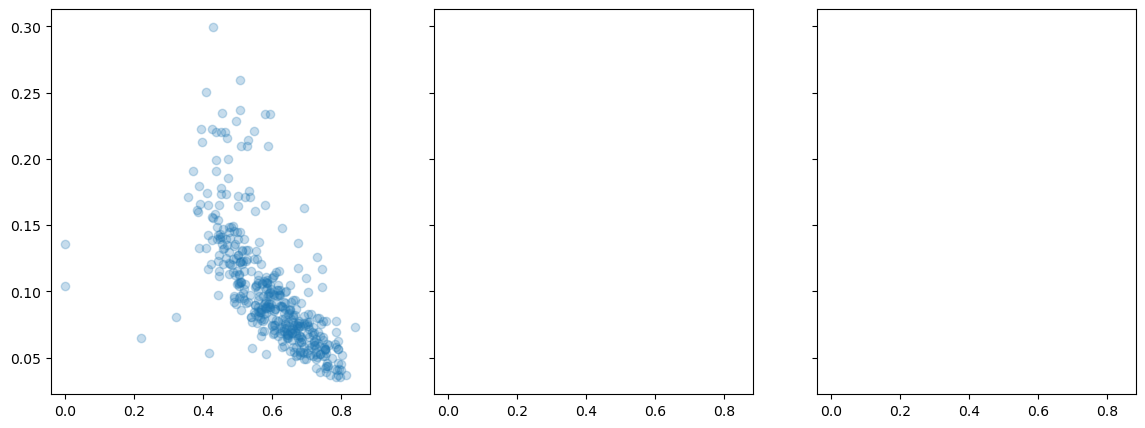

In [36]:
#Plot dN/dS for structural vs Neilsen

struct_data_dnds = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_struct_neilsen_yn00.csv'))

fig, axarr = plt.subplots(1,3, figsize=(14,5), sharex=True, sharey = True)
dnds_seq_cols = [ 'dN_dS_SCE', 'dN_dS_struct', 'dN_dS_struct_m0']

for jj, dnds_seq_col in enumerate(dnds_seq_cols):   
    ax = axarr[jj]
    ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds[dnds_seq_col], alpha = 0.25)
   
    struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(selected_og_refs)]
    
    ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset[dnds_seq_col],color='r' ,alpha = 0.8)
    ax.set_ylabel(dnds_seq_col)
    ax.set_xlabel('Mean(Conservation rate AA)')

Text(0.5, 0, 'Mean(Conservation rate AA)')

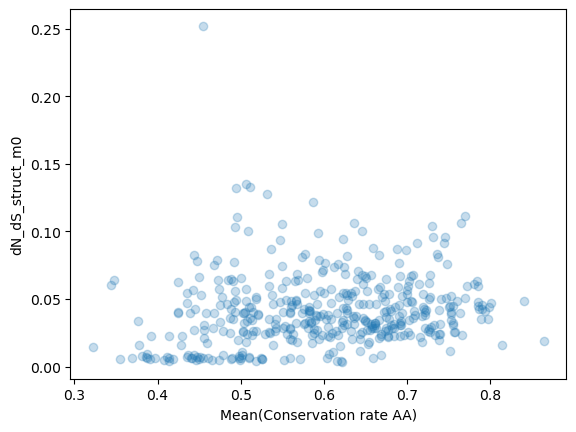

In [37]:
fig, ax = plt.subplots(1,1)

ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds['dN_dS_struct_m0'], alpha = 0.25)

#struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(selected_og_refs)]
#ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset['dN_dS_struct_m0'],color='r' ,alpha = 0.8)
ax.set_ylabel('dN_dS_struct_m0')
ax.set_xlabel('Mean(Conservation rate AA)')

In [ ]:
## Many of these values changed between YN00 and M0 - why

Text(0.5, 0, 'Mean(Conservation rate AA)')

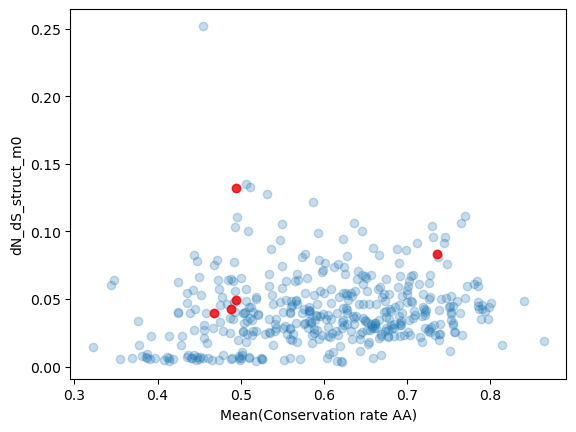

In [223]:
fig, ax = plt.subplots(1,1)

ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds['dN_dS_struct_m0'], alpha = 0.25)

struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(selected_og_refs)]

ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset['dN_dS_struct_m0'],color='r' ,alpha = 0.8)
ax.set_ylabel('dN_dS_struct_m0')
ax.set_xlabel('Mean(Conservation rate AA)')

In [41]:
struct_data_dnds.sort_values(by='dN_dS_struct_m0')

,Unnamed: 0,Unnamed: 0.1,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,...,dN_dS_struct,dN_struct,dS_struct,og_y,og,tree_length,kappa,dN_dS_struct_m0,tree_length_dS,tree_length_dS.1
266,266,266,OG3008,OG3008_REF_Scer_AF-P36076-F1-model_v2,0.391014,0.621655,0.765640,OG3008.out_yn00,0.0688,OG3008.out_yn00,...,0.14165,0.30875,2.18665,OG3008,OG3008,702.694735,1.36836,0.00354,3.3044,933.2096
378,378,378,OG2999,OG2999_REF_Scer_AF-P43636-F1-model_v2,0.795070,0.518443,0.663924,OG2999.out_yn00,0.1017,OG2999.out_yn00,...,0.20500,0.49610,2.46400,OG2999,OG2999,1037.138851,1.53711,0.00391,5.4388,1392.2430
517,517,517,OG1764,OG1764_REF_Scer_AF-Q12189-F1-model_v2,0.916595,0.620356,0.736102,OG1764.out_yn00,0.0978,OG1764.out_yn00,...,0.15965,0.34705,2.11815,OG1764,OG1764,848.177639,1.40233,0.00416,4.4265,1064.9058
354,354,354,OG1933,OG1933_REF_Scer_AF-P40545-F1-model_v2,0.920130,0.615480,0.724607,OG1933.out_yn00,0.1045,OG1933.out_yn00,...,0.15670,0.35105,2.45255,OG1933,OG1933,697.590301,1.33537,0.00434,4.1879,965.1963
304,304,304,OG3018,OG3018_REF_Scer_AF-P38635-F1-model_v2,0.877038,0.413258,0.588927,OG3018.out_yn00,0.1424,OG3018.out_yn00,...,0.27300,0.62865,2.30075,OG3018,OG3018,1064.056007,1.58679,0.00435,6.3933,1470.2429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,545,545,NaN,OG6290_eremothecium_gossypii__OG6290__40_1372,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,OG6290,NaN,NaN,NaN,NaN,NaN,NaN
546,546,546,NaN,OG6574_eremothecium_gossypii__OG6574__40_137,NaN,NaN,NaN,NaN,NaN,NaN,...,0.23300,0.45360,1.94620,OG6574,NaN,NaN,NaN,NaN,NaN,NaN
547,547,547,NaN,OG6598_kazachstania_naganishii__OG6598__49_1006,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,OG6598,NaN,NaN,NaN,NaN,NaN,NaN
548,548,548,NaN,OG7278_kazachstania_naganishii__OG7278__49_2415,NaN,NaN,NaN,NaN,NaN,NaN,...,0.30260,0.67650,2.09960,OG7278,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.09)&(struct_data_dnds['Mean(Conservation rate AA)']<0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]

,og_ref,og,dN_dS_struct_m0,Mean(Conservation rate AA)
276,OG4552_REF_Scer_AF-P37299-F1-model_v2,OG4552,0.25202,0.455022
247,OG4555_REF_Scer_AF-P32799-F1-model_v2,OG4555,0.13541,0.506526
7,OG4316_REF_Scer_AF-P00424-F1-model_v2,OG4316,0.13305,0.510637
64,OG4150_REF_Scer_AF-P07256-F1-model_v2,OG4150,0.13195,0.494113
105,OG4346_REF_Scer_AF-P10174-F1-model_v2,OG4346,0.12753,0.531120
88,OG4360_REF_Scer_AF-P08525-F1-model_v2,OG4360,0.12166,0.587126
16,OG5441_REF_Scer_AF-P00724-F1-model_v2,OG5441,0.11105,0.495190
419,OG1377_REF_Scer_AF-P53090-F1-model_v2,OG1377,0.10546,0.550098
257,OG2112_REF_Scer_AF-P33421-F1-model_v2,OG2112,0.10336,0.492917
122,OG1122_REF_Scer_AF-P13711-F1-model_v2,OG1122,0.10054,0.508399


In [62]:
list(set(list(etc_proteins_clustered['enzyme'])))

['cytochrome c oxidase',
 'NAD dehydrogenase',
 'succinate dehydrogenase',
 'ubiquinol cytochrome b reductase']

In [67]:
struct_data_dnds[struct_data_dnds['og_ref'].isin(etc_proteins_clustered[etc_proteins_clustered['enzyme']==enzyme]['og_ref'])]

,Unnamed: 0,Unnamed: 0.1,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,...,dN_dS_struct,dN_struct,dS_struct,og_y,og,tree_length,kappa,dN_dS_struct_m0,tree_length_dS,tree_length_dS.1
0,0,0,OG4352,OG4352_REF_Scer_AF-P00127-F1-model_v2,0.515006,0.488312,0.583829,OG4352.out_yn00,0.0924,OG4352.out_yn00,...,0.13010,0.3097,2.73470,OG4352,OG4352,33.684114,1.43708,0.06460,2.6508,41.0328
1,1,1,OG3208,OG3208_REF_Scer_AF-P00128-F1-model_v2,0.983085,0.577829,0.742639,OG3208.out_yn00,0.1655,OG3208.out_yn00,...,0.21970,0.4035,1.82720,OG3208,OG3208,54.335382,1.26238,0.08318,4.8548,58.3681
56,56,56,OG2248,OG2248_REF_Scer_AF-P07143-F1-model_v2,0.805705,0.790176,0.862447,OG2248.out_yn00,0.0462,OG2248.out_yn00,...,0.06630,0.1073,1.76920,OG2248,OG2248,36.063606,1.26135,0.04297,1.7977,41.8418
64,64,64,OG4150,OG4150_REF_Scer_AF-P07256-F1-model_v2,0.855788,0.494113,0.646492,OG4150.out_yn00,0.2287,OG4150.out_yn00,...,0.27640,0.5432,1.81100,OG4150,OG4150,40.471574,1.15876,0.13195,5.0681,38.4103
65,65,65,OG2006,OG2006_REF_Scer_AF-P07257-F1-model_v2,0.859501,0.471097,0.626659,OG2006.out_yn00,0.1999,OG2006.out_yn00,...,0.32255,0.6303,1.94075,OG2006,OG2006,85.816195,1.26877,0.07908,6.9683,88.1218
81,81,81,OG3575,OG3575_REF_Scer_AF-P08067-F1-model_v2,0.796899,0.748114,0.826812,OG3575.out_yn00,0.0658,OG3575.out_yn00,...,0.08840,0.1484,1.61560,OG3575,OG3575,24.577237,1.33301,0.07590,2.0340,26.7988
88,88,88,OG4360,OG4360_REF_Scer_AF-P08525-F1-model_v2,0.864742,0.587126,0.725837,OG4360.out_yn00,0.2101,OG4360.out_yn00,...,0.17170,0.3492,2.08780,OG4360,OG4360,28.447028,1.56897,0.12166,3.4444,28.3119
171,171,171,OG4744,OG4744_REF_Scer_AF-P22289-F1-model_v2,0.800866,0.547609,0.698766,OG4744.out_yn00,0.2211,OG4744.out_yn00,...,0.20385,0.3558,1.80320,OG4744,OG4744,81.672935,1.63435,0.09353,8.1023,86.6281
276,276,276,OG4552,OG4552_REF_Scer_AF-P37299-F1-model_v2,0.440031,0.455022,0.598244,OG4552.out_yn00,0.2350,OG4552.out_yn00,...,0.28830,0.5350,1.95820,OG4552,OG4552,24.663009,1.46351,0.25202,4.7162,18.7136


In [66]:
etc_proteins_clustered[etc_proteins_clustered['enzyme']==enzyme]['og_ref']

6     OG2006_REF_Scer_AF-P07257-F1-model_v2
9     OG2248_REF_Scer_AF-P07143-F1-model_v2
12    OG3208_REF_Scer_AF-P00128-F1-model_v2
14    OG3575_REF_Scer_AF-P08067-F1-model_v2
16    OG4150_REF_Scer_AF-P07256-F1-model_v2
20    OG4352_REF_Scer_AF-P00127-F1-model_v2
21    OG4360_REF_Scer_AF-P08525-F1-model_v2
22    OG4552_REF_Scer_AF-P37299-F1-model_v2
24    OG4744_REF_Scer_AF-P22289-F1-model_v2
27                                      NaN
Name: og_ref, dtype: object

cytochrome c oxidase
r
NAD dehydrogenase
k
succinate dehydrogenase
#fc03e3
ubiquinol cytochrome b reductase
b


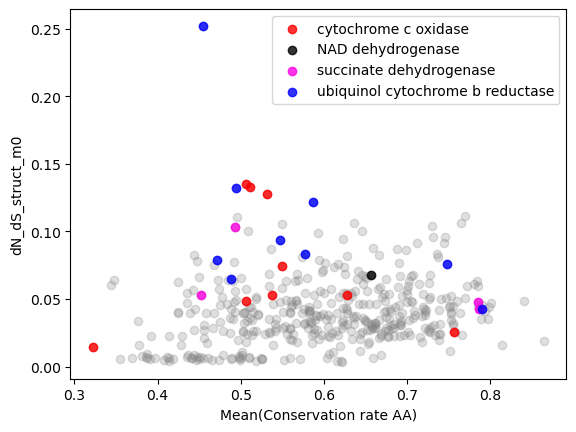

In [73]:
fig, ax = plt.subplots(1,1)

enzymes = {'cytochrome c oxidase': 'r',
           'NAD dehydrogenase': 'k',
           'succinate dehydrogenase': '#fc03e3', 
           'ubiquinol cytochrome b reductase': 'b'
          }

ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds['dN_dS_struct_m0'], alpha = 0.25, c= 'grey')

legend_handles = []
legend_labels = []
for enzyme, color in enzymes.items(): 
    print(enzyme)
    print(color)
    struct_data_dnds_subset = struct_data_dnds[struct_data_dnds['og_ref'].isin(etc_proteins_clustered[etc_proteins_clustered['enzyme']==enzyme]['og_ref'])]
    handle = ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset['dN_dS_struct_m0'],color=color ,alpha = 0.8)
    legend_handles.append(handle)
    legend_labels.append(enzyme)
    
ax.set_ylabel('dN_dS_struct_m0')
ax.set_xlabel('Mean(Conservation rate AA)')
ax.legend(legend_handles, legend_labels)

Text(0.5, 0, 'Mean(Conservation rate AA)')

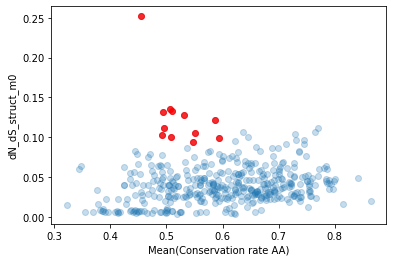

In [40]:
fig, ax = plt.subplots(1,1)

ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds['dN_dS_struct_m0'], alpha = 0.25)

struct_data_dnds_subset = struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.09)&(struct_data_dnds['Mean(Conservation rate AA)']<0.6)]

ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset['dN_dS_struct_m0'],color='r' ,alpha = 0.8)
ax.set_ylabel('dN_dS_struct_m0')
ax.set_xlabel('Mean(Conservation rate AA)')

In [47]:
struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.08)&(struct_data_dnds['Mean(Conservation rate AA)']>0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]

,og_ref,og,dN_dS_struct_m0,Mean(Conservation rate AA)
4,OG1145_REF_Scer_AF-P00358-F1-model_v2,OG1145,0.11116,0.769694
22,OG1193_REF_Scer_AF-P00924-F1-model_v2,OG1193,0.10633,0.765119
38,OG1208_REF_Scer_AF-P04806-F1-model_v2,OG1208,0.10633,0.636346
44,OG1813_REF_Scer_AF-P05694-F1-model_v2,OG1813,0.10394,0.729674
11,OG3185_REF_Scer_AF-P00447-F1-model_v2,OG3185,0.10029,0.645687
125,OG1432_REF_Scer_AF-P14540-F1-model_v2,OG1432,0.09617,0.730782
14,OG1424_REF_Scer_AF-P00560-F1-model_v2,OG1424,0.09583,0.745608
173,OG1112_REF_Scer_AF-P23254-F1-model_v2,OG1112,0.09457,0.622696
28,OG2794_REF_Scer_AF-P00950-F1-model_v2,OG2794,0.09144,0.744687
68,OG1892_REF_Scer_AF-P07262-F1-model_v2,OG1892,0.09138,0.712552


Text(0.5, 0, 'Mean(Conservation rate AA)')

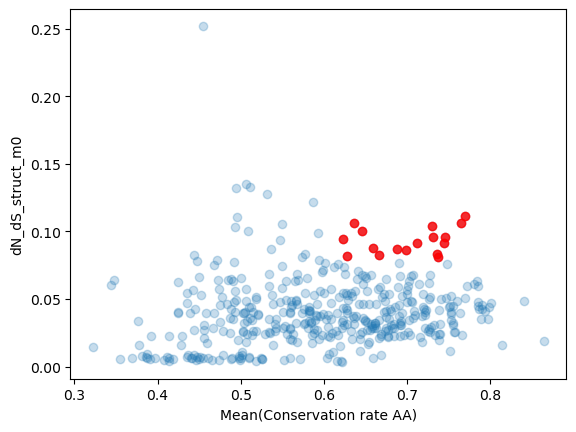

In [47]:
fig, ax = plt.subplots(1,1)

ax.scatter(struct_data_dnds['Mean(Conservation rate AA)'], struct_data_dnds['dN_dS_struct_m0'], alpha = 0.25)

struct_data_dnds_subset = struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.08)&(struct_data_dnds['Mean(Conservation rate AA)']>0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]

ax.scatter(struct_data_dnds_subset['Mean(Conservation rate AA)'], struct_data_dnds_subset['dN_dS_struct_m0'],color='r' ,alpha = 0.8)
ax.set_ylabel('dN_dS_struct_m0')
ax.set_xlabel('Mean(Conservation rate AA)')

1145: TDH3, TDH1,    
1193: ERR3, ERR2, ENO1, ERR1, ENO2,     
1208: HKX2, HKX1
1813: MET6
OG3185: SOD2
OG1432: FBA1
OG1424: PGK1
OG1112: TKL1, TKL2
OG2794: GPM1
OG1892: GDH1, GDH3


In [62]:
struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']<0.006)&(struct_data_dnds['Mean(Conservation rate AA)']<0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]

,og_ref,og,dN_dS_struct_m0,Mean(Conservation rate AA)
272,OG2262_REF_Scer_AF-P37254-F1-model_v2,OG2262,0.00599,0.488731
84,OG3445_REF_Scer_AF-P08432-F1-model_v2,OG3445,0.00593,0.571035
417,OG2228_REF_Scer_AF-P53037-F1-model_v2,OG2228,0.00572,0.525051
511,OG3679_REF_Scer_AF-Q12051-F1-model_v2,OG3679,0.00565,0.449906
73,OG3065_REF_Scer_AF-P07285-F1-model_v2,OG3065,0.00549,0.525262
239,OG1168_REF_Scer_AF-P32528-F1-model_v2,OG1168,0.00543,0.390285
292,OG4021_REF_Scer_AF-P38242-F1-model_v2,OG4021,0.00533,0.407698
140,OG1673_REF_Scer_AF-P16661-F1-model_v2,OG1673,0.00518,0.499541
441,OG3104_REF_Scer_AF-P53954-F1-model_v2,OG3104,0.00518,0.464948
318,OG3074_REF_Scer_AF-P38913-F1-model_v2,OG3074,0.00510,0.446412


In [7]:
struct_data_lc_hdnds = struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.09)&(struct_data_dnds['Mean(Conservation rate AA)']<0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]
struct_data_lc_ldnds = struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']<0.006)&(struct_data_dnds['Mean(Conservation rate AA)']<0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]
struct_data_hc_hdnds = struct_data_dnds[(struct_data_dnds['dN_dS_struct_m0']>0.08)&(struct_data_dnds['Mean(Conservation rate AA)']>0.6)].sort_values(by='dN_dS_struct_m0', ascending=False).loc[:,['og_ref','og','dN_dS_struct_m0', 'Mean(Conservation rate AA)']]

og_refs = {'low_cons_high_dn_ds': struct_data_lc_hdnds['og_ref'], 
           'low_cons_low_dn_ds': struct_data_lc_ldnds['og_ref'],
           'high_cons_high_dn_ds': struct_data_hc_hdnds['og_ref']
          }

## Site Model Analysis

Site Model calculations using Nsites 0, 1, 2 run using 20231010_run_site_model.sh on ms03 server. 



In [ ]:
#Load m0, nearly neutral , and  positive selection test results
site_model_base = base_dir + os.sep + os.path.normpath('selection_calculations/site_model') + os.sep

site_model_data_dfs = dyt.load_site_model_data(site_model_base, branch_table_out=False)

#Load original m0 calculations
m0_dS_filter = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_dS_filter_20231128.csv'), index_col=0)


Folder previous_calculations does not contain dnds calculation
Folder nsites_01278 does not contain dnds calculation
convergence issue in OG3774_REF_Scer_AF-P32377-F1-model_v2 for m0 test.
convergence issue in OG1537_REF_Scer_AF-P32288-F1-model_v2 for NearlyNeutral test.
convergence issue in OG1955_REF_Scer_AF-P32461-F1-model_v2 for m0 test.
convergence issue in OG2006_REF_Scer_AF-P07257-F1-model_v2 for PositiveSelection test.
convergence issue in OG2956_REF_Scer_AF-P08456-F1-model_v2 for PositiveSelection test.
convergence issue in OG5735_REF_Scer_AF-Q03579-F1-model_v2 for PositiveSelection test.
convergence issue in OG1445_REF_Scer_AF-P39522-F1-model_v2 for NearlyNeutral test.
convergence issue in OG1445_REF_Scer_AF-P39522-F1-model_v2 for PositiveSelection test.
convergence issue in OG1266_REF_Scer_AF-P23337-F1-model_v2 for m0 test.
convergence issue in OG1266_REF_Scer_AF-P23337-F1-model_v2 for PositiveSelection test.
Folder G3350_REF_Scer_AF-P38332-F1-model_v2 does not contain dnds 

In [69]:
all_present_in_both = {}
for test in ['m0', 'NearlyNeutral', 'PositiveSelection']: 
    all_present_in_both_test = set(site_model_data_dfs[test].loc[site_model_data_dfs[test]['dN_dS_found'],].index) & set(m0_dS_filter.index)
    print('{} og_refs present and calculated in both for {}'.format(len(all_present_in_both_test),test))
    all_present_in_both[test] = all_present_in_both_test

#set(site_model_data_dfs['m0'].loc[~site_model_data_dfs['m0']['convergence_issue'],].index) - set(m0_dS_filter.loc[m0_dS_filter['convergence_issue']==False,].index)

#OGs that had no convergence issue when ran alongside site model, but did the first time for m0
ogs_no_m0_conv_second_time_conv_issue_first_time = (set(site_model_data_dfs['m0'].loc[~site_model_data_dfs['m0']['convergence_issue'],].index) & all_present_in_both['m0']) - set(m0_dS_filter.loc[m0_dS_filter['convergence_issue']==False,].index)

print("{} ogs that had a convergence issue the first time, but did not the second time for M0".format(len(ogs_no_m0_conv_second_time_conv_issue_first_time)))
print(ogs_no_m0_conv_second_time_conv_issue_first_time)


#OGs with M0 that had no convergence issue the first time, but did the second time. 
no_M0_troubles_first_time = set(m0_dS_filter.loc[m0_dS_filter['convergence_issue']==False,].index)
M0_troubles_second_time = set(site_model_data_dfs['m0'].loc[site_model_data_dfs['m0']['convergence_issue'],].index) 

m0_trouble_second_time_not_first = (all_present_in_both['m0'] & no_M0_troubles_first_time) & M0_troubles_second_time

print("{} had m0 convergence issues the second time but not the first time".format(len(m0_trouble_second_time_not_first)))
print(m0_trouble_second_time_not_first)

#OGs with missing data and convergence issues for nearly neutral but not for m0
site_model_data_dfs['m0']

missing_nearly_neutral_not_m0 = set(site_model_data_dfs['m0'].loc[site_model_data_dfs['m0']['dN_dS_found'],].index)-set(site_model_data_dfs['NearlyNeutral'].loc[site_model_data_dfs['NearlyNeutral']['dN_dS_found'],].index)
print('There are {} ogs with missing data in nearly neutral but not for m0'.format(len(missing_nearly_neutral_not_m0)))
print(missing_nearly_neutral_not_m0)


missing_positive_selection_not_nearly_neutral = set(site_model_data_dfs['NearlyNeutral'].loc[site_model_data_dfs['NearlyNeutral']['dN_dS_found'],].index)-set(site_model_data_dfs['PositiveSelection'].loc[site_model_data_dfs['PositiveSelection']['dN_dS_found'],].index)
print('There are {} ogs with missing data in positive selection but not for nearly neutral'.format(len(missing_positive_selection_not_nearly_neutral)))
print(missing_positive_selection_not_nearly_neutral)



404 og_refs present and calculated in both for m0
398 og_refs present and calculated in both for NearlyNeutral
398 og_refs present and calculated in both for PositiveSelection
19 ogs that had a convergence issue the first time, but did not the second time for M0
{'OG1471_REF_Scer_AF-P33333-F1-model_v2', 'OG3443_REF_Scer_AF-P42941-F1-model_v2', 'OG3581_REF_Scer_AF-P41835-F1-model_v2', 'OG3350_REF_Scer_AF-P38332-F1-model_v2', 'OG3104_REF_Scer_AF-P53954-F1-model_v2', 'OG3488_REF_Scer_AF-P53184-F1-model_v2', 'OG3313_REF_Scer_AF-P38342-F1-model_v2', 'OG1357_REF_Scer_AF-P14742-F1-model_v2', 'OG3638_REF_Scer_AF-P53868-F1-model_v2', 'OG4758_REF_Scer_AF-P25372-F1-model_v2', 'OG3413_REF_Scer_AF-P32452-F1-model_v2', 'OG2868_REF_Scer_AF-P50107-F1-model_v2', 'OG2228_REF_Scer_AF-P53037-F1-model_v2', 'OG3445_REF_Scer_AF-P08432-F1-model_v2', 'OG4250_REF_Scer_AF-P35731-F1-model_v2', 'OG3018_REF_Scer_AF-P38635-F1-model_v2', 'OG1103_REF_Scer_AF-P47771-F1-model_v2', 'OG3525_REF_Scer_AF-Q01802-F1-model_v2'

In [10]:
#Run MLE tests

#Nearly Neutral vs M0:  Test against chi2_1_1pct = 6.63
#Positive Selection vs Nearly Neutral:  Test against chi2_2_5% = 5.99
#Need to do something about Multiple testing


neutral_v_m0_chi2 = []
neutral_v_m0_chi2_thresh = 6.63

positive_v_neutral_chi2 = []
positive_v_neutral_chi2_thresh = 5.99

og_refs = site_model_data_dfs['m0'].index

for og_ref in og_refs:
    mle_m0 = site_model_data_dfs['m0']['mle'][og_ref]
    mle_neutral = site_model_data_dfs['NearlyNeutral']['mle'][og_ref]
    mle_positive = site_model_data_dfs['PositiveSelection']['mle'][og_ref]

    neutral_v_m0_chi2.append(mle_neutral - mle_m0)
    positive_v_neutral_chi2.append(mle_positive-mle_neutral)



mle_tests = pd.DataFrame(data={'neutral_v_m0_chi2': neutral_v_m0_chi2, 'positive_v_neutral_chi2': positive_v_neutral_chi2}, index=og_refs)

#Filter out those that fail m0 filter



In [ ]:
set(mle_tests_subset.loc[mle_tests_subset['neutral_v_m0_chi2']<neutral_v_m0_chi2_thresh,].index)

,neutral_v_m0_chi2,positive_v_neutral_chi2
OG2084_REF_Scer_AF-P36024-F1-model_v2,4.043666,0.000001


399 og_refs present and calculated in all tests
1 orthogroups that did not have a better MLE in nearly neutral than in m0 (unadjusted threshold)
{'OG2084_REF_Scer_AF-P36024-F1-model_v2'}
5 orthogroups where positive selection passes chi2 threshold to be better than a nearly neutral model (unadjusted)
{'OG2197_REF_Scer_AF-P00942-F1-model_v2', 'OG1218_REF_Scer_AF-P08417-F1-model_v2', 'OG1145_REF_Scer_AF-P00358-F1-model_v2', 'OG3445_REF_Scer_AF-P08432-F1-model_v2', 'OG2603_REF_Scer_AF-P50076-F1-model_v2'}
7 orthogroups where positive selection is worse model than nearly neutral
{'OG3811_REF_Scer_AF-Q06490-F1-model_v2', 'OG2936_REF_Scer_AF-P00812-F1-model_v2', 'OG4008_REF_Scer_AF-Q12676-F1-model_v2', 'OG3714_REF_Scer_AF-Q03677-F1-model_v2', 'OG2057_REF_Scer_AF-P28789-F1-model_v2', 'OG4352_REF_Scer_AF-P00127-F1-model_v2', 'OG2738_REF_Scer_AF-P40351-F1-model_v2'}


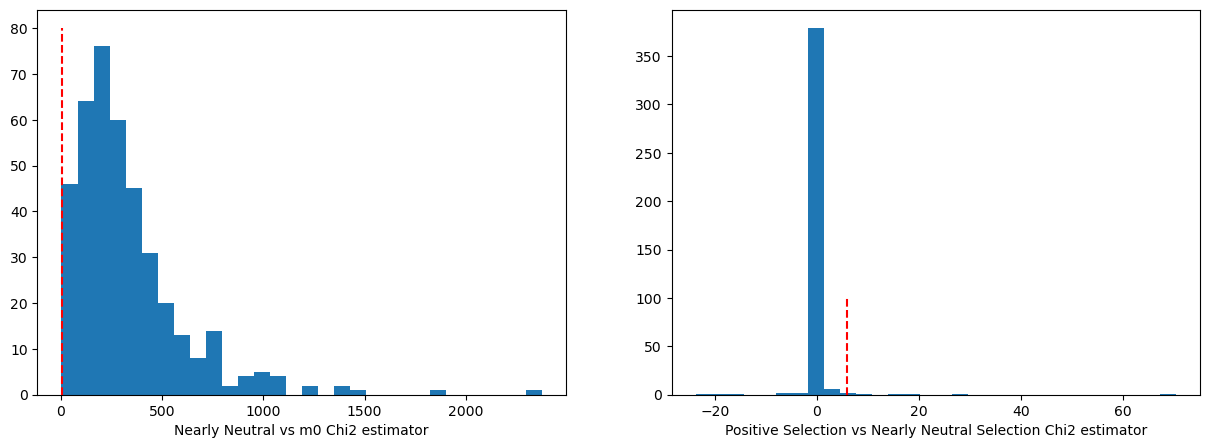

In [ ]:
#Check tests for all values calculated

og_refs_present_and_calculated_all_tests = set.intersection(*[set(site_model_data_dfs[test].loc[site_model_data_dfs[test]['dN_dS_found'],].index) for test in ['m0', 'NearlyNeutral','PositiveSelection']])

print("{} og_refs present and calculated in all tests".format(len(og_refs_present_and_calculated_all_tests)))

mle_tests_subset = mle_tests.loc[list(og_refs_present_and_calculated_all_tests),:]

nearly_neutral_below_threshold = set(mle_tests_subset.loc[mle_tests_subset['neutral_v_m0_chi2']<neutral_v_m0_chi2_thresh,].index)

print('{} orthogroups that did not have a better MLE in nearly neutral than in m0 (unadjusted threshold)'.format(len(nearly_neutral_below_threshold)))
print(nearly_neutral_below_threshold)

positive_selection_above_threshold = set(mle_tests_subset.loc[mle_tests_subset['positive_v_neutral_chi2']>positive_v_neutral_chi2_thresh,].index)
print('{} orthogroups where positive selection passes chi2 threshold to be better than a nearly neutral model (unadjusted)'.format(len(positive_selection_above_threshold)))
print(positive_selection_above_threshold)

positive_selection_below_0p1 = set(mle_tests_subset.loc[mle_tests_subset['positive_v_neutral_chi2']<-0.1,].index)
print('{} orthogroups where positive selection is worse model than nearly neutral(less than -0.1)'.format(len(positive_selection_below_0p1)))
print(positive_selection_below_0p1)

fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].hist(mle_tests_subset['neutral_v_m0_chi2'],bins=30)
ax[0].set_xlabel('Nearly Neutral vs m0 Chi2 estimator')
ax[0].vlines(neutral_v_m0_chi2_thresh, ymin=0,ymax=80, linestyles='--',colors='r')

ax[1].hist(mle_tests_subset['positive_v_neutral_chi2'],bins=30)
ax[1].set_xlabel('Positive Selection vs Nearly Neutral Selection Chi2 estimator')
ax[1].vlines(positive_v_neutral_chi2_thresh, ymin=0,ymax=100, linestyles='--',colors='r')

295 og_refs that have dS<3
369 og_refs that had no convergence issue on initial m0 run
275 og_refs that have ds<3 and no convergence issue on initial m0 run
270 og_refs pass filters and calculated for all tests
0 orthogroups that did not have a better MLE in nearly neutral than in m0 (unadjusted threshold)
set()
3 orthogroups where positive selection passes chi2 threshold to be better than a nearly neutral model (unadjusted)
{'OG1218_REF_Scer_AF-P08417-F1-model_v2', 'OG2197_REF_Scer_AF-P00942-F1-model_v2', 'OG1145_REF_Scer_AF-P00358-F1-model_v2'}
5 orthogroups where positive selection is worse model than nearly neutral(less than -0.1)
{'OG3811_REF_Scer_AF-Q06490-F1-model_v2', 'OG2936_REF_Scer_AF-P00812-F1-model_v2', 'OG3714_REF_Scer_AF-Q03677-F1-model_v2', 'OG2057_REF_Scer_AF-P28789-F1-model_v2', 'OG4352_REF_Scer_AF-P00127-F1-model_v2'}


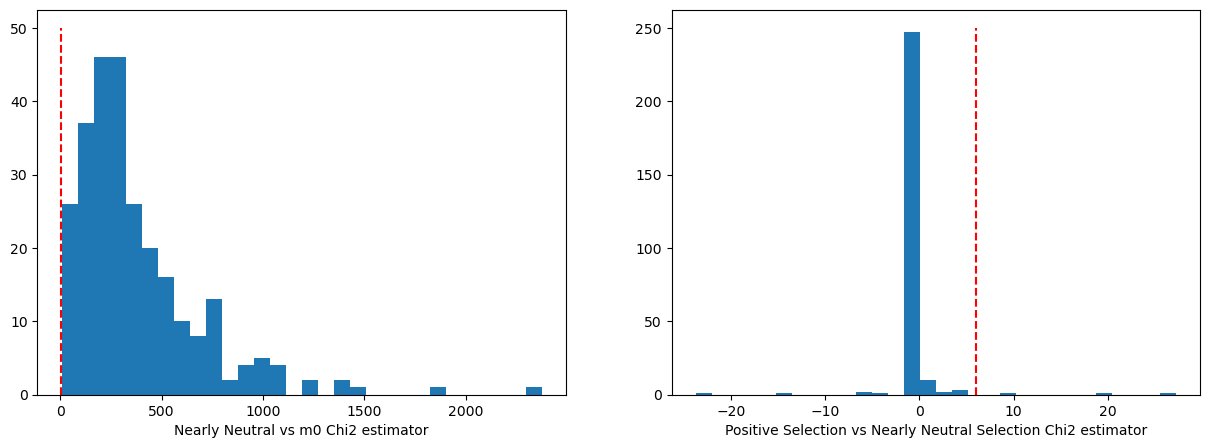

In [61]:
#Check tests for all values where 
#Original m0 converged
#dS from original calculation was < 3

#og_refs that pass filter: 
print("{} og_refs that have dS<3".format(len(m0_dS_filter.loc[~(m0_dS_filter['dS>3'].astype('bool')),:])))
print("{} og_refs that had no convergence issue on initial m0 run".format(len(m0_dS_filter.loc[~(m0_dS_filter['convergence_issue'].astype('bool')),:])))


og_refs_pass_filters = set(m0_dS_filter.loc[(~(m0_dS_filter['dS>3'].astype('bool')) & ~(m0_dS_filter['convergence_issue'].astype('bool'))),:].index)

print("{} og_refs that have ds<3 and no convergence issue on initial m0 run".format(len(og_refs_pass_filters)))

og_refs_present_and_calculated_all_tests = set.intersection(*[set(site_model_data_dfs[test].loc[site_model_data_dfs[test]['dN_dS_found'],].index) for test in ['m0', 'NearlyNeutral','PositiveSelection']])
og_refs_pass_filters_and_calculated_all_tests = og_refs_present_and_calculated_all_tests & og_refs_pass_filters

print("{} og_refs pass filters and calculated for all tests".format(len(og_refs_pass_filters_and_calculated_all_tests)))

mle_tests_subset = mle_tests.loc[list(og_refs_pass_filters_and_calculated_all_tests),:]

nearly_neutral_below_threshold = set(mle_tests_subset.loc[mle_tests_subset['neutral_v_m0_chi2']<neutral_v_m0_chi2_thresh,].index)

print('{} orthogroups that did not have a better MLE in nearly neutral than in m0 (unadjusted threshold)'.format(len(nearly_neutral_below_threshold)))
print(nearly_neutral_below_threshold)

positive_selection_above_threshold = set(mle_tests_subset.loc[mle_tests_subset['positive_v_neutral_chi2']>positive_v_neutral_chi2_thresh,].index)
print('{} orthogroups where positive selection passes chi2 threshold to be better than a nearly neutral model (unadjusted)'.format(len(positive_selection_above_threshold)))
print(positive_selection_above_threshold)

positive_selection_below_0p1 = set(mle_tests_subset.loc[mle_tests_subset['positive_v_neutral_chi2']<-0.1,].index)
print('{} orthogroups where positive selection is worse model than nearly neutral(less than -0.1)'.format(len(positive_selection_below_0p1)))
print(positive_selection_below_0p1)

fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].hist(mle_tests_subset['neutral_v_m0_chi2'],bins=30)
ax[0].set_xlabel('Nearly Neutral vs m0 Chi2 estimator')
ax[0].vlines(neutral_v_m0_chi2_thresh, ymin=0,ymax=50, linestyles='--',colors='r')

ax[1].hist(mle_tests_subset['positive_v_neutral_chi2'],bins=30)
ax[1].set_xlabel('Positive Selection vs Nearly Neutral Selection Chi2 estimator')
ax[1].vlines(positive_v_neutral_chi2_thresh, ymin=0,ymax=250, linestyles='--',colors='r')

In [62]:
#Not sure why pos selection test is so much worse than nearly neutral on some of these.  

mle_tests_subset[mle_tests_subset['positive_v_neutral_chi2']<-0.1]

,neutral_v_m0_chi2,positive_v_neutral_chi2
OG4352_REF_Scer_AF-P00127-F1-model_v2,19.262267,-4.574221
OG3811_REF_Scer_AF-Q06490-F1-model_v2,104.580077,-15.091399
OG3714_REF_Scer_AF-Q03677-F1-model_v2,119.523016,-23.776940
OG2936_REF_Scer_AF-P00812-F1-model_v2,170.394575,-5.788857
OG2057_REF_Scer_AF-P28789-F1-model_v2,203.594918,-6.319877


In [64]:
site_model_data_dfs['PositiveSelection'].loc[mle_tests[mle_tests['positive_v_neutral_chi2']<-1].index]
#site_model_data_dfs['NearlyNeutral'].loc[mle_tests[mle_tests['positive_v_neutral_chi2']<-1].index]

,og,mle,tree_length,kappa,p_1,dN_dS_1,p_2,dN_dS_2,p_3,dN_dS_3,convergence_issue,dN_dS_found
OG3714_REF_Scer_AF-Q03677-F1-model_v2,OG3714,-9958.814298,78.293851,1.13697,0.87937,0.04511,0.06096,1.0,0.05966,1.0,False,True
OG4352_REF_Scer_AF-P00127-F1-model_v2,OG4352,-3111.483383,29.074128,2.31840,0.66338,0.07264,0.26056,1.0,0.07606,1.0,False,True
OG3811_REF_Scer_AF-Q06490-F1-model_v2,OG3811,-18002.447004,94.064721,1.32260,0.86823,0.06668,0.13177,1.0,0.00000,1.0,False,True
OG2936_REF_Scer_AF-P00812-F1-model_v2,OG2936,-20381.190138,91.380388,1.14611,0.92493,0.04046,0.01880,1.0,0.05627,1.0,False,True
OG2057_REF_Scer_AF-P28789-F1-model_v2,OG2057,-20436.954015,76.964083,1.28137,0.86698,0.04854,0.00034,1.0,0.13268,1.0,False,True
OG2738_REF_Scer_AF-P40351-F1-model_v2,OG2738,-31844.478781,97.944108,1.44449,0.90012,0.04314,0.00003,1.0,0.09986,1.0,False,True
OG4008_REF_Scer_AF-Q12676-F1-model_v2,OG4008,-25432.722969,630.672643,1.38225,0.78808,0.00857,0.16275,1.0,0.04917,1.0,True,True


In [ ]:
mle_tests[mle_tests['positive_v_neutral_chi2']>positive_v_neutral_chi2_thresh]

,neutral_v_m0_chi2,positive_v_neutral_chi2
OG2197_REF_Scer_AF-P00942-F1-model_v2,426.526532,10.041989
OG1145_REF_Scer_AF-P00358-F1-model_v2,1092.043743,20.113660
OG3445_REF_Scer_AF-P08432-F1-model_v2,272.248130,15.562551
OG1218_REF_Scer_AF-P08417-F1-model_v2,712.121212,27.251337
OG2603_REF_Scer_AF-P50076-F1-model_v2,121.608429,70.374597


In [66]:
site_model_data_dfs['PositiveSelection'].loc[mle_tests[mle_tests['positive_v_neutral_chi2']>positive_v_neutral_chi2_thresh].index]
#site_model_data_dfs['NearlyNeutral'].loc[mle_tests[mle_tests['positive_v_neutral_chi2']>positive_v_neutral_chi2_thresh].index]

,og,mle,tree_length,kappa,p_1,dN_dS_1,p_2,dN_dS_2,p_3,dN_dS_3,convergence_issue,dN_dS_found
OG2197_REF_Scer_AF-P00942-F1-model_v2,OG2197,-13878.716257,149.532442,1.74371,0.71843,0.07158,0.27286,1.0,0.00871,302.71108,False,True
OG1145_REF_Scer_AF-P00358-F1-model_v2,OG1145,-20667.592996,26.254889,1.92868,0.77806,0.05740,0.21589,1.0,0.00606,7.11796,False,True
OG3445_REF_Scer_AF-P08432-F1-model_v2,OG3445,-22123.685173,434.539765,1.40666,0.89458,0.00732,0.02793,1.0,0.07749,1.00000,True,True
OG1218_REF_Scer_AF-P08417-F1-model_v2,OG1218,-28489.899876,40.577124,1.56335,0.86451,0.03977,0.13549,1.0,0.00000,7.96769,True,True
OG2603_REF_Scer_AF-P50076-F1-model_v2,OG2603,-28668.374811,126.484695,1.55985,0.88946,0.05419,0.00134,1.0,0.10920,1.00000,False,True


In [67]:
mle_tests_subset[mle_tests_subset['positive_v_neutral_chi2']>positive_v_neutral_chi2_thresh]

,neutral_v_m0_chi2,positive_v_neutral_chi2
OG2197_REF_Scer_AF-P00942-F1-model_v2,426.526532,10.041989
OG1218_REF_Scer_AF-P08417-F1-model_v2,712.121212,27.251337
OG1145_REF_Scer_AF-P00358-F1-model_v2,1092.043743,20.113660


In [71]:
site_model_data_dfs['PositiveSelection'].loc[mle_tests_subset[mle_tests_subset['positive_v_neutral_chi2']>positive_v_neutral_chi2_thresh].index]
site_model_data_dfs['NearlyNeutral'].loc[mle_tests_subset[mle_tests_subset['positive_v_neutral_chi2']>positive_v_neutral_chi2_thresh].index]

,og,mle,tree_length,kappa,p_1,dN_dS_1,p_2,dN_dS_2,convergence_issue,dN_dS_found
OG2197_REF_Scer_AF-P00942-F1-model_v2,OG2197,-13888.758246,32.345240,1.67286,0.72946,0.06982,0.27054,1.0,False,True
OG1218_REF_Scer_AF-P08417-F1-model_v2,OG1218,-28517.151213,38.040285,1.64364,0.85887,0.04253,0.14113,1.0,True,True
OG1145_REF_Scer_AF-P00358-F1-model_v2,OG1145,-20687.706656,25.138794,1.86747,0.78368,0.05757,0.21632,1.0,True,True


In [ ]:
#Analysis using nearly neutral model for orthogroups.  

#Extract site data from BEB tables and compare to conservation 

In [82]:
# Load NEB and BEB tables for each orthogroup.  If loading from raw files, save them as a .csv in appropriate og file. 

load_from_raw = False

site_model_base = base_dir + os.sep + os.path.normpath('selection_calculations/site_model') + os.sep

posterior_data = {}

for og_ref in next(os.walk(site_model_base))[1]:    #next(os.walk(m0_base))[0] gets just directories - https://stackoverflow.com/questions/141291/how-to-list-only-top-level-directories-in-python
    #         ##for og_ref in tm_align_post_trim_filter_list:
    #og_ref = 'OG4555_REF_Scer_AF-P32799-F1-model_v2'  #example
    og = og_ref.split('_')[0]
    if og[0:2] =='OG':

        if load_from_raw: 
            posterior_data_og = dyt.extract_posterior_values_site_model(og_ref, site_model_base, save_output=True)
        else:
            posterior_data_og = {}
            for site_class in ['NEB_2', 'NEB_3', 'BEB_3']:
                posterior_data_og[site_class] = pd.read_csv(site_model_base + os.sep + og_ref + os.sep + site_class + '.csv', index_col=0)
        posterior_data[og_ref] = posterior_data_og

In [83]:
m0_dS_filter = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_dS_filter_20231128.csv'), index_col=0)
site_model_data_dfs_neutral = site_model_data_dfs['NearlyNeutral'].copy()
site_model_data_dfs_neutral = site_model_data_dfs_neutral.loc[site_model_data_dfs_neutral['dN_dS_found'],:]

site_model_neutral_merged = site_model_data_dfs_neutral.merge(m0_dS_filter.loc[:,['tree_length','dN_dS_struct', 'Mean(Conservation Rate) [ALL]', 'Mean(log2(Abundances)) 10 Sp [EXP]', 'convergence_issue', 'dS>3']], left_index=True, right_index=True, how='inner', suffixes=['_NearlyNeutral', '_M0'])


# for each OG, extract percentage class 2.  Merge with conservation

neutral_pct = []

for og_ref in site_model_neutral_merged.index:    #next(os.walk(m0_base))[0] gets just directories - https://stackoverflow.com/questions/141291/how-to-list-only-top-level-directories-in-python
    neutral_count = Counter(posterior_data[og_ref]['NEB_2']['class'])
    neutral = neutral_count[2]
    purifying = neutral_count[1]
    if neutral+purifying==0:
        'error: ' + og_ref + ' no residues under purifying or neutral selection'
        neutral_pct.append(np.nan)
    else: 
        neutral_pct.append(neutral/(neutral+purifying))

site_model_neutral_merged['neutral_pct'] = neutral_pct

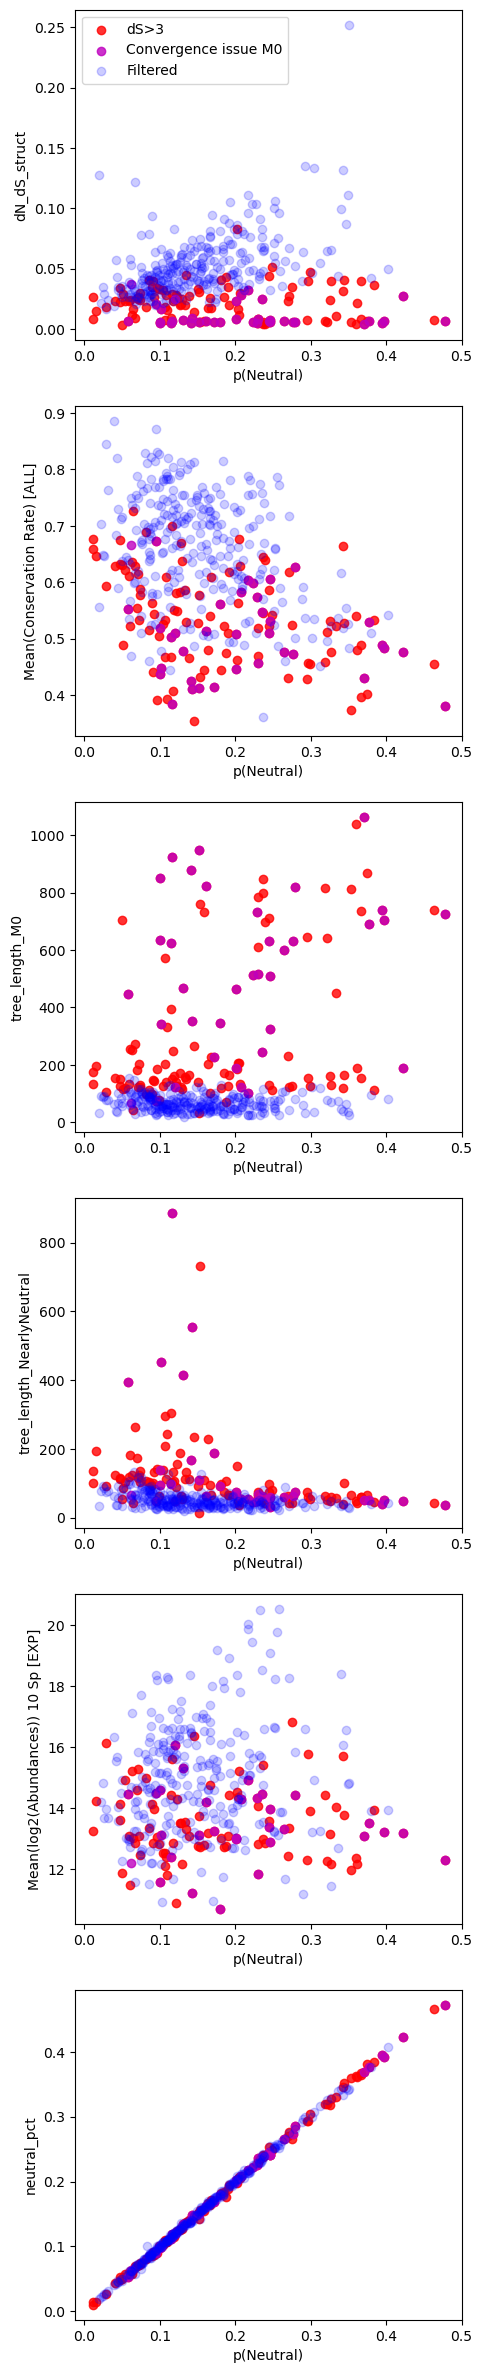

In [86]:

covariates = ['dN_dS_struct', 'Mean(Conservation Rate) [ALL]', 'tree_length_M0', 'tree_length_NearlyNeutral', 'Mean(log2(Abundances)) 10 Sp [EXP]', 'neutral_pct']

fix, axarr = plt.subplots(len(covariates),1,figsize=(5,5*len(covariates)))

data_to_plot = {}

#Mark those that should be filtered (m0 convergence issue, ds>3)

#correlation line for good data

site_model_neutral_merged_rm_na = site_model_neutral_merged.loc[~site_model_neutral_merged['dS>3'].isna(),:] # for some reason one og has M0 as NaN, but not site model OG1357_REF_Scer_AF-P14742-F1-model_v2

subsets = {'dS>3': {'data_subset' : site_model_neutral_merged_rm_na.loc[site_model_neutral_merged_rm_na['dS>3'],:], 
                    'color': 'r', 'alpha':0.8}, 
           'Convergence issue M0': {'data_subset': site_model_neutral_merged_rm_na.loc[site_model_neutral_merged_rm_na['convergence_issue_M0'],:],
                                    'color': 'm', 'alpha': 0.8},
           'Filtered': {'data_subset': site_model_neutral_merged_rm_na.loc[(~(site_model_neutral_merged_rm_na['dS>3'].astype('bool')) & ~(site_model_neutral_merged_rm_na['convergence_issue_M0'].astype('bool'))),:],
                        'color': 'b', 'alpha': 0.2}
           }

for jj,covariate in enumerate(covariates): 
    ax = axarr[jj]
    for subset_name, subset_dict in subsets.items():
        subset_data = subset_dict['data_subset']
        ax.scatter(subset_data['p_2'],subset_data[covariate], color=subset_dict['color'], alpha = subset_dict['alpha'],label=subset_name)
        ax.set_xlabel('p(Neutral)')
        ax.set_ylabel(covariate)
        if jj==0:
            ax.legend()

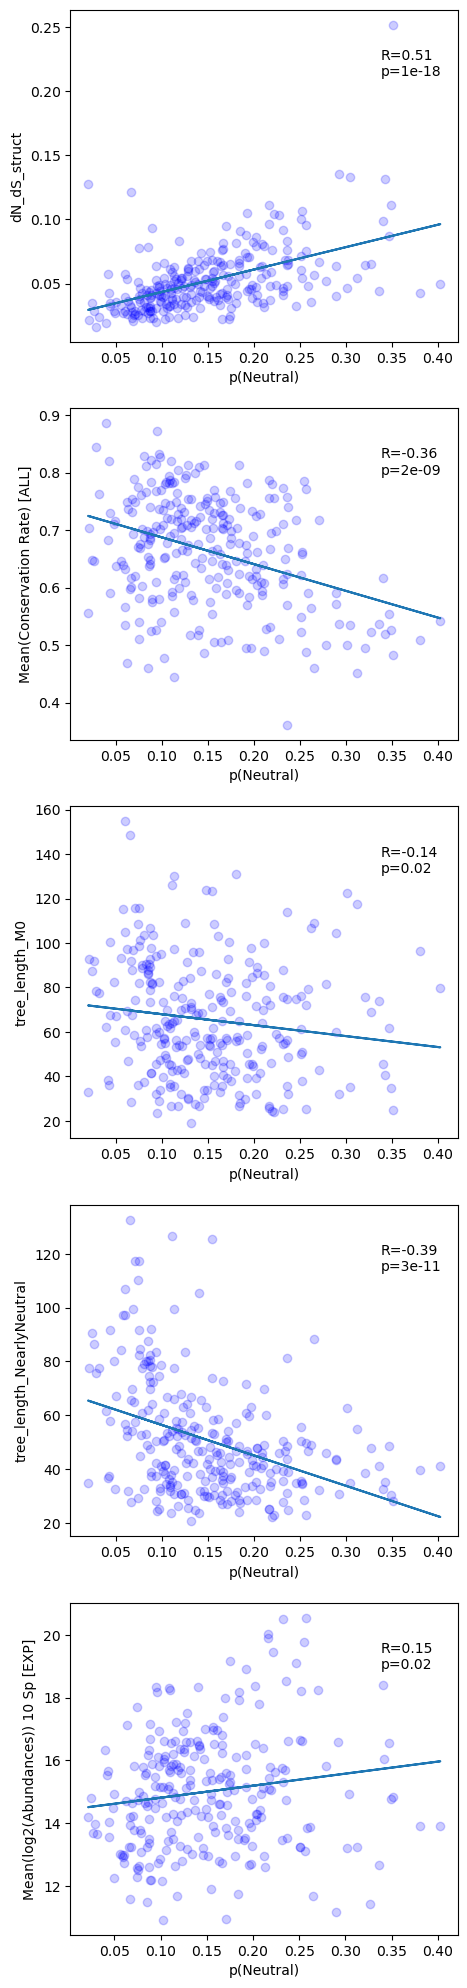

In [87]:
#Plot after filtering

covariates = ['dN_dS_struct', 'Mean(Conservation Rate) [ALL]', 'tree_length_M0', 'tree_length_NearlyNeutral', 'Mean(log2(Abundances)) 10 Sp [EXP]']

fix, axarr = plt.subplots(len(covariates),1,figsize=(5,5*len(covariates)))

data_to_plot = {}

#Mark those that should be filtered (m0 convergence issue, ds>3)

#correlation line for good data

site_model_neutral_merged_rm_na = site_model_neutral_merged.loc[~site_model_neutral_merged['dS>3'].isna(),:] # for some reason one og has M0 as NaN, but not site model OG1357_REF_Scer_AF-P14742-F1-model_v2

subset_dict = {'data_subset': site_model_neutral_merged_rm_na.loc[(~(site_model_neutral_merged_rm_na['dS>3'].astype('bool')) & ~(site_model_neutral_merged_rm_na['convergence_issue_M0'].astype('bool'))),:],
                        'color': 'b', 'alpha': 0.2}

for jj,covariate in enumerate(covariates): 
    ax = axarr[jj]
    
    subset_data = subset_dict['data_subset']

    x_data = subset_data['p_2']
    y_data = subset_data[covariate]

    ax.scatter(x_data,y_data, color=subset_dict['color'], alpha = subset_dict['alpha'],label=subset_name)
    ax.set_xlabel('p(Neutral)')
    ax.set_ylabel(covariate)

    #add linear regression line to scatterplot for background
    na_filt = x_data.notna() & y_data.notna()

    x_data = x_data[na_filt]
    y_data = y_data[na_filt]

    #m, b = np.polyfit(x_data, y_data, 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    ax.plot(list(x_data), list(slope*x_data+intercept))
    #ax.plot([min(x_data),max(x_data)],[min(x_data),max(x_data)], '--')
    ax.text(0.8, 0.8, 'R={:.2}\np={:.1}'.format(r_value, p_value),transform=ax.transAxes)


In [97]:
ref_res_of_int

['T29', 'N248']

In [ ]:
#paml_ref_residues = list(zip(posterior_data[og_ref]['NEB_2'].index, posterior_data[og_ref]['NEB_2']['residue_first_seq']))

[(28, 'K'), (247, 'L')]

In [96]:
og_ref = 'OG2197_REF_Scer_AF-P00942-F1-model_v2'
pos_sel_res_df = posterior_data[og_ref]['BEB_3'][posterior_data[og_ref]['BEB_3']['class']==3]

paml_ref_residues = list(zip(pos_sel_res_df.index, pos_sel_res_df['residue_first_seq']))
ref_res_of_int, aln_res_of_int, ref_seq = dyt.identify_ref_residue(og_ref, paml_ref_residues)
aln_res_of_int

['T295', 'N518']

In [100]:
#Map AA onto original ref sequence

ogs_of_interest = {'TPI1': 'OG2197_REF_Scer_AF-P00942-F1-model_v2', 
                   'TDH1/2/3': 'OG1145_REF_Scer_AF-P00358-F1-model_v2',
                   'FUM1': 'OG1218_REF_Scer_AF-P08417-F1-model_v2'
                  }

for og_ref_name, og_ref in ogs_of_interest.items(): 
    pos_sel_res_df = posterior_data[og_ref]['BEB_3'][posterior_data[og_ref]['BEB_3']['class']==3]
    paml_ref_residues = list(zip(pos_sel_res_df.index, pos_sel_res_df['residue_first_seq']))
    ref_res_of_int, aln_res_of_int, ref_seq = dyt.identify_ref_residue(og_ref, paml_ref_residues) 
    print('{}: {}'.format(og_ref_name,og_ref))
    for res in ref_res_of_int: 
        print(res)




#Get breakdown of class by surf/core/binding site / Binding site 5A
#This is done in m0 breakdown by features

TPI1: OG2197_REF_Scer_AF-P00942-F1-model_v2
T29
N248
TDH1/2/3: OG1145_REF_Scer_AF-P00358-F1-model_v2
Q22
L88
FUM1: OG1218_REF_Scer_AF-P08417-F1-model_v2
S26
S27
N191


## Branch Site Model analysis

First example POX1



In [3]:
#Import BEB data from file
og_ref = 'OG1122_REF_Scer_AF-P13711-F1-model_v2'

#G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG1122_REF_Scer_AF-P13711-F1-model_v2\A
bs_rst_file = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/' + og_ref + '/A/rst')

beb_vals = dyt.extract_beb_values(bs_rst_file)

In [6]:
tree_ids = {1: '41..42',
             2: '41..42 and below',
             3: '43..44',
             4: '44..45',
             5: '45..46', 
             6: '47..48',
             7: '47..48 and below',
             8: '57..60',
             9: '36..68'
            }



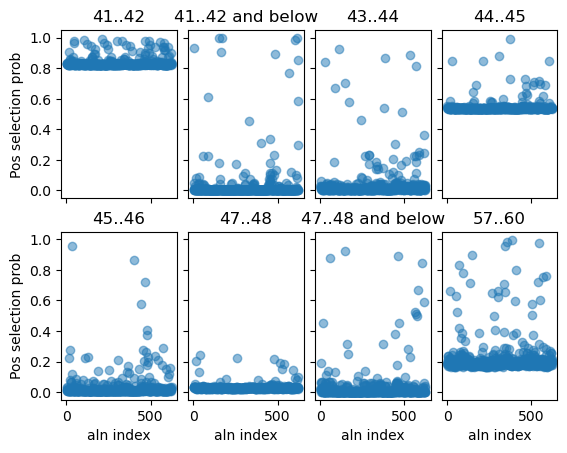

In [7]:
fig, axarr = plt.subplots(2,4, sharex=True, sharey=True)

trees_to_plot = [1,2,3,4,5,6,7, 8]

n_plot = 0

for jj, axarr_col in enumerate(axarr):
    for kk, ax in enumerate(axarr_col):
        if n_plot<len(trees_to_plot):
            tree_ind = trees_to_plot[n_plot]
            ax.scatter(beb_vals[tree_ind].index, beb_vals[tree_ind]['class_2'], alpha=0.5)
            ax.set_title(tree_ids[tree_ind])
            
            if jj == 1: 
                ax.set_xlabel('aln index')
            if kk == 0: 
                ax.set_ylabel('Pos selection prob')
            n_plot = n_plot + 1
        
fig.subplots_adjust(hspace=0.2, wspace=0.1)

Text(0, 0.5, 'Positive selection probability')

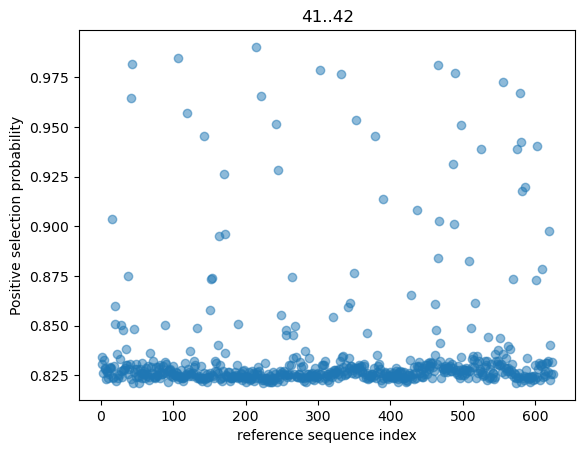

In [7]:
fig, ax = plt.subplots()

tree_ind = 1
ax.scatter(beb_vals[tree_ind].index, beb_vals[tree_ind]['class_2'], alpha=0.5)
ax.set_title(tree_ids[tree_ind])
 
ax.set_xlabel('reference sequence index')
ax.set_ylabel('Positive selection probability')


## Visualize trees with positive selection for Pox1



## Get list of ETC Proteins

From pathways: aerobic respiration, electron transport chain

Cytochrome C oxidase: 
Cox13, 12, 9, 8, 7, 6, 5A, 4, 3, 2, 1
COB (Mito), RIP1, CYT1, COR1, QCR22, QCR6, QCR7, QCR8, QCR9, QCR10

Succinate Dehydrogenase: 
SDH4, 3, 2, SDH9 , SDH1

YJL045W is the gene name of SDH9 and is what was listed

NADH Dehydrogenase
NDI1
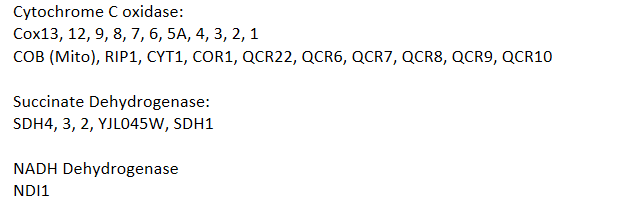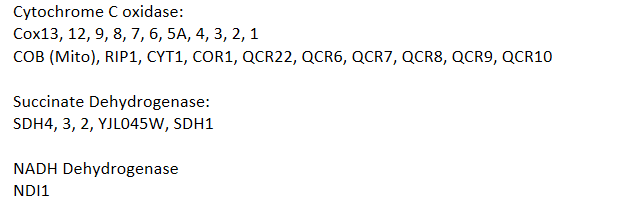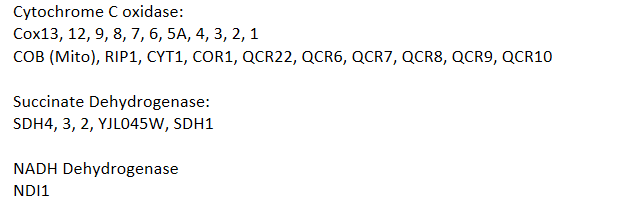

In [38]:
struct_data_dnds

,Unnamed: 0,og_x,og_ref,Mean(Mapping rate),Mean(Conservation rate AA),Mean(Conservation rate Type),OG_SCE,dN_dS_SCE,OG_nl_02_03,dN_dS_nl_02_03,dN_dS_struct,dN_struct,dS_struct,og_y
0,0,OG4352,OG4352_REF_Scer_AF-P00127-F1-model_v2,0.515006,0.488312,0.583829,OG4352.out_yn00,0.0924,OG4352.out_yn00,0.11860,0.1301,0.30970,2.7347,OG4352
1,1,OG3208,OG3208_REF_Scer_AF-P00128-F1-model_v2,0.983085,0.577829,0.742639,OG3208.out_yn00,0.1655,OG3208.out_yn00,0.14910,0.2197,0.40350,1.8272,OG3208
2,2,OG1016,OG1016_REF_Scer_AF-P00330-F1-model_v2,0.954863,0.736954,0.817145,NaN,NaN,NaN,NaN,0.1130,0.19800,1.7722,OG1016
3,3,OG1016,OG1016_REF_Scer_AF-P00331-F1-model_v2,0.938285,0.737345,0.817970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,OG1145,OG1145_REF_Scer_AF-P00358-F1-model_v2,0.994326,0.769694,0.856194,NaN,NaN,OG1145.out_yn00,0.09955,0.1600,0.18535,1.2456,OG1145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,545,NaN,OG6290_eremothecium_gossypii__OG6290__40_1372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG6290
546,546,NaN,OG6574_eremothecium_gossypii__OG6574__40_137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2330,0.45360,1.9462,OG6574
547,547,NaN,OG6598_kazachstania_naganishii__OG6598__49_1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OG6598
548,548,NaN,OG7278_kazachstania_naganishii__OG7278__49_2415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3026,0.67650,2.0996,OG7278


In [43]:
etc_pathways_list = {'cytochrome c oxidase': ['COX1', 'COX2', 'COX3', 'COX4', 'COX5A', 'COX6', 'COX7', 'COX8', 'COX9', 'COX12', 'COX13', 'COX26'],  #COX26 not present in pathways, but is a subunit
                 'ubiquinol cytochrome b reductase': ['COB', 'RIP1', 'CYT1', 'COR1', 'QCR2', 'QCR6', 'QCR7', 'QCR8', 'QCR9', 'QCR10'],
                 'succinate dehydrogenase': ['SDH4', 'SDH3', 'SDH2', 'SDH9', 'SDH1'], #SDH3 and #SDH9was not present in my version of the SGD name lookup
                 'NAD dehydrogenase': ['NDI1']
                }

mito_list = ['COB', 'COX1', 'COX2', 'COX3']

paralog_pairs = [('COX5B','COX5A'), ('SHH3','SDH3'),('SDH9', 'SDH1'),('SHH4','SDH4')]

paralog_lookup = {}
for p1,p2 in paralog_pairs: 
    paralog_lookup[p1] = p2
for p1,p2 in paralog_pairs: 
    paralog_lookup[p2] = p1

og_fname = base_dir + os.sep + os.path.normpath('selected_proteins/og_metadata.json')
with open(og_fname, 'r') as f:
    og_metadata = json.load(f) 

model_og_lookup = dyt.load_model_og_lookup()


etc_name_list = []
for enzyme, name_list in etc_pathways_list.items(): 
    etc_name_list = etc_name_list + name_list

etc_name_list = etc_name_list + [paralog for paralog in paralog_lookup.keys()]
etc_name_list = list(set(etc_name_list))
etc_orf_list = yeast_esr_exp.SC_orf_lookup_by_name(etc_name_list)

newer_genes = {'SDH3': 'YKL141W',
               'SDH9': 'YJL045W'
              }

etc_orf_list_updated = []
for orf in etc_orf_list: 
    if orf in newer_genes.keys(): 
        etc_orf_list_updated.append(newer_genes[orf])
    else: 
        etc_orf_list_updated.append(orf)     

etc_og_list = []

for gene_id in etc_orf_list_updated: 
    if gene_id in model_og_lookup['Scer'].keys():
        etc_og_list.append(model_og_lookup['Scer'][gene_id])
    else: 
        etc_og_list.append(None)

paralogs_col =[]
for name in etc_name_list: 
    if name in paralog_lookup.keys():
        paralogs_col.append(paralog_lookup[name])
    else: 
        paralogs_col.append(None)

#Check if the OG was selected
og_retained = []
for og in etc_og_list: 
    if og in og_metadata.keys(): 
        og_data = og_metadata[og]
        if og_data['pass_species_filter']: 
            og_retained.append(True)
        else: 
            og_retained.append(False)
    else: 
        og_retained.append(False)
        
#mitochondrial
mitochondrial = []
for gene_id in etc_orf_list_updated: 
    if gene_id[0]=='Q': 
        mitochondrial.append(True)
    else: 
        mitochondrial.append(False)
        
etc_proteins_df = pd.DataFrame.from_dict( {'name': etc_name_list, 
                         'gene_id': etc_orf_list_updated,
                         'og': etc_og_list, 
                         'paralog': paralogs_col,
                         'og_retained': og_retained, 
                         'mitochondrial': mitochondrial
                        })

#Check if any of these break apart in clusters and identify appropriate og_ref id
cluster_table = pd.read_csv(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/clustering/cluster_mapping.csv'))
cluster_table['og'] = [og_clust.split('_')[0] for og_clust in cluster_table['og_clust']]
cluster_table_subset = cluster_table[(cluster_table['cluster_rep']==1) & (cluster_table['og'].isin(etc_proteins_df['og']))]

etc_proteins_clustered = cluster_table_subset.merge(etc_proteins_df, how='outer', on='og').loc[:,['primary_id', 'og_clust', 'og', 'name', 'gene_id', 'paralog', 'og_retained', 'no_sc', 'mitochondrial']]

#assign enzyme_name

enzyme_lookup = {}
for enzyme, gene_list in etc_pathways_list.items(): 
    for gene in gene_list: 
        enzyme_lookup[gene] = enzyme
        
#assigns enzyme name to match paralog
for p1,p2 in paralog_lookup.items(): 
    if not(p1) in enzyme_lookup.keys(): 
        enzyme_lookup[p1] = enzyme_lookup[p2]

enzyme_col = []
for name in etc_proteins_clustered['name']: 
    if name in enzyme_lookup.keys(): 
        enzyme_col.append(enzyme_lookup[name])
    else: 
        enzyme_col.append(None)
        
etc_proteins_clustered['enzyme'] = enzyme_col

#Include conservation rate and DN_DS
struct_data_dnds = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_struct_neilsen_yn00.csv'), index_col=0)
etc_proteins_clustered = etc_proteins_clustered.merge(struct_data_dnds.loc[:,['og_ref', 'Mean(Conservation rate AA)', 'Mean(Mapping rate)', 'dN_dS_struct_m0']], how='left', left_on='primary_id', right_on='og_ref')

etc_proteins_clustered.to_csv(base_dir + os.sep + os.path.normpath('examples/etc/etc_table.csv'))

S.Cer orf for SDH9not found


## For a given set of og_ref which have had M1 analysis performed, generate trees to test. 
To be more comprehensive in the branch-site analysis, for the orthogroups of interest below, we did an m1 analysis to identify branches likely to be under positive selection, and then did branch-site tests on those branches.  

Also for those trees to test extracts information about the branches - which species and proteins are covered. 


In [ ]:
# new_etc = {'COX12': 'OG1254_REF_Scer_AF-Q01519-F1-model_v2', 
#                'SDH9_SDH1': 'OG1275_REF_Scer_AF-P47052-F1-model_v2',
#                'SHH4_SDH4': 'OG1287_REF_Scer_AF-P37298-F1-model_v2',
#                'QCR2': 'OG2006_REF_Scer_AF-P07257-F1-model_v2',
#                'CYT1': 'OG2248_REF_Scer_AF-P07143-F1-model_v2',
#                'SDH2': 'OG2704_REF_Scer_AF-P21801-F1-model_v2',
#                'COX6': 'OG2714_REF_Scer_AF-P00427-F1-model_v2',
#                'QCR7': 'OG3208_REF_Scer_AF-P00128-F1-model_v2',
#                'COX4': 'OG3505_REF_Scer_AF-P04037-F1-model_v2',
#                'RIP1': 'OG3575_REF_Scer_AF-P08067-F1-model_v2',
#                'COX9': 'OG4118_REF_Scer_AF-P07255-F1-model_v2',
#                'QCR6': 'OG4352_REF_Scejr_AF-P00127-F1-model_v2',
#                'COX8': 'OG4751_REF_Scer_AF-P04039-F1-model_v2',
#                'NDI1': 'OG5490_REF_Scer_AF-P32340-F1-model_v2',
#                'COX2': 'OG4755_kluyveromyces_marxianus__OG4755__51_759', #MItochondrial, shouldn't have been retained
#                'COB': 'OG5006_kluyveromyces_marxianus__OG5006__51_4218'
#           }

In [18]:
' '.join(new_etc.values())

'OG1254_REF_Scer_AF-Q01519-F1-model_v2 OG1275_REF_Scer_AF-P47052-F1-model_v2 OG1287_REF_Scer_AF-P37298-F1-model_v2 OG2006_REF_Scer_AF-P07257-F1-model_v2 OG2248_REF_Scer_AF-P07143-F1-model_v2 OG2704_REF_Scer_AF-P21801-F1-model_v2 OG2714_REF_Scer_AF-P00427-F1-model_v2 OG3208_REF_Scer_AF-P00128-F1-model_v2 OG3505_REF_Scer_AF-P04037-F1-model_v2 OG3575_REF_Scer_AF-P08067-F1-model_v2 OG4118_REF_Scer_AF-P07255-F1-model_v2 OG4352_REF_Scer_AF-P00127-F1-model_v2 OG4751_REF_Scer_AF-P04039-F1-model_v2 OG5490_REF_Scer_AF-P32340-F1-model_v2 OG4755_kluyveromyces_marxianus__OG4755__51_759 OG5006_kluyveromyces_marxianus__OG5006__51_4218'

In [37]:
#ETC og refs
og_refs = {'COX13': 'OG4555_REF_Scer_AF-P32799-F1-model_v2', #ones with higher positive selection and lower conservation
               'COX5A_COX5B': 'OG4316_REF_Scer_AF-P00424-F1-model_v2',
               'COR1': 'OG4150_REF_Scer_AF-P07256-F1-model_v2',
               'COX7': 'OG4346_REF_Scer_AF-P10174-F1-model_v2',
               'QCR8': 'OG4360_REF_Scer_AF-P08525-F1-model_v2',
               'SHH3_SDH3': 'OG2112_REF_Scer_AF-P33421-F1-model_v2',
               'QCR9': 'OG4744_REF_Scer_AF-P22289-F1-model_v2',
               'QCR10': 'OG4552_REF_Scer_AF-P37299-F1-model_v2',
               'COX12': 'OG1254_REF_Scer_AF-Q01519-F1-model_v2', #Others
               'SDH9_SDH1': 'OG1275_REF_Scer_AF-P47052-F1-model_v2',
               'SHH4_SDH4': 'OG1287_REF_Scer_AF-P37298-F1-model_v2',
               'QCR2': 'OG2006_REF_Scer_AF-P07257-F1-model_v2',
               'CYT1': 'OG2248_REF_Scer_AF-P07143-F1-model_v2',
               'SDH2': 'OG2704_REF_Scer_AF-P21801-F1-model_v2',
               'COX6': 'OG2714_REF_Scer_AF-P00427-F1-model_v2',
               'QCR7': 'OG3208_REF_Scer_AF-P00128-F1-model_v2',
               'COX4': 'OG3505_REF_Scer_AF-P04037-F1-model_v2',
               'RIP1': 'OG3575_REF_Scer_AF-P08067-F1-model_v2',
               'COX9': 'OG4118_REF_Scer_AF-P07255-F1-model_v2',
               'QCR6': 'OG4352_REF_Scer_AF-P00127-F1-model_v2',
               'COX8': 'OG4751_REF_Scer_AF-P04039-F1-model_v2',
               'NDI1': 'OG5490_REF_Scer_AF-P32340-F1-model_v2',
               #'COX2': 'OG4755_kluyveromyces_marxianus__OG4755__51_759', #MItochondrial, shouldn't have been retained
               #'COB': 'OG5006_kluyveromyces_marxianus__OG5006__51_4218'
}

#og_refs = {'POX1': 'OG1122_REF_Scer_AF-P13711-F1-model_v2'}

# og_refs = {'CDC19': 'OG1299_REF_Scer_AF-P00549-F1-model_v2' , 
#            'HSU1': 'OG1390_REF_Scer_AF-P47164-F1-model_v2'
#           }

# og_refs = {'TPI1': 'OG2197_REF_Scer_AF-P00942-F1-model_v2' , 
#            'TDH1_TDH2_TDH3': 'OG1145_REF_Scer_AF-P00358-F1-model_v2',
#            'FUM1': 'OG1218_REF_Scer_AF-P08417-F1-model_v2'
#            }

In [26]:
og_refs = {'HSU1': 'OG1390_REF_Scer_AF-P47164-F1-model_v2'
          }

dn_ds_thresh = 1.1 
max_branches_to_test = 17

hits_tables, branch_leaves, marked_tree_branch_info = dyt.m1_hits(og_refs, dn_ds_thresh, max_branches_to_test, save_results = False)

HSU1
Total branches above threshold: 17


In [ ]:
#After building tree files, run branch site analysis 

In [8]:
hits_tables['COX13']

,t,N,S,dN/dS,dN,dS,N*dN,S*dS,labelled_node
branch,,,,,,,,,
28..30,0.128,229.3,70.7,499.3492,0.0558,0.0001,12.8,0.0,30
30..31,0.169,229.3,70.7,388.2598,0.0735,0.0002,16.8,0.0,31
22..23,0.054,229.3,70.7,339.2067,0.0234,0.0001,5.4,0.0,23
27..33,0.151,229.3,70.7,329.9619,0.0657,0.0002,15.1,0.0,33
26..15,0.268,229.3,70.7,193.3380,0.1168,0.0006,26.8,0.0,15
27..28,0.240,229.3,70.7,1.6216,0.0879,0.0542,20.1,3.8,28


## Visualize Branches that are targets for branch site analysis

In [ ]:
og_refs = {'POX1': 'OG1122_REF_Scer_AF-P13711-F1-model_v2'}


In [110]:
dn_ds_thresh = 1.1 

#Visualize Omega for several trees
goi = 'POX1'
og_ref = og_refs[goi]

tree_fname = base_dir + os.sep + os.path.normpath("selection_calculations/m1/" + og_ref + "/m1.out")
gene_lookup_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/seq_name_map/' + og_ref + '.tm.tsv')
gene_lookup_df = pd.read_table(gene_lookup_fname)
gene_lookup = {}

for seq_no, seq_name_raw in zip(gene_lookup_df['seq_no'],gene_lookup_df['seq_name']):
    seq_name = dyt.protein_id_shorten(seq_name_raw.split('.')[0])
    gene_lookup[seq_no] = seq_name


with open(tree_fname) as f_in: 
    for line in f_in: 
        if line.strip() == 'w ratios as labels for TreeView:':
            tree = next(f_in)

#tree = '(OG1122_0 #0.163029 , ((((((((((((OG1122_1 #0.0270719 , (OG1122_15 #0.0126084 , OG1122_25 #0.117686 ) #254.02 ) #88.32 , OG1122_24 #0.0237027 ) #0.0563529 , OG1122_34 #0.0719369 ) #253.707 , OG1122_19 #0.00389742 ) #999 , (OG1122_16 #0.0305312 , OG1122_17 #0.0196626 ) #0.114995 ) #129.565 , OG1122_12 #0.00426301 ) #0.564374 , (OG1122_8 #0.0362459 , OG1122_26 #0.15259 ) #0.55835 ) #999 , OG1122_3 #0.142596 ) #0.643901 , ((((OG1122_2 #0.304313 , (OG1122_9 #0.0758783 , OG1122_27 #0.00228046 ) #0.0681672 ) #127.954 , ((OG1122_4 #0.00400082 , (OG1122_13 #0.0475127 , OG1122_14 #0.0889826 ) #95.6682 ) #105.858 , (((OG1122_28 #0.33902 , ((OG1122_30 #0.271117 , OG1122_32 #0.242208 ) #0.68121 , OG1122_31 #0.137292 ) #0.661779 ) #1.13358 , OG1122_29 #0.296291 ) #0.475717 , OG1122_33 #0.271958 ) #235.164 ) #0.000571889 ) #126.681 , (OG1122_20 #0.0103657 , OG1122_23 #0.00350454 ) #0.000662129 ) #999 , ((OG1122_18 #0.0526148 , OG1122_21 #0.0030032 ) #0.0306679 , OG1122_22 #0.13763 ) #631.908 ) #0.0884153 ) #0.376309 , OG1122_5 #0.412607 ) #0.48047 , (OG1122_7 #0.364691 , OG1122_11 #0.131504 ) #84.2544 ) #0.243941 , OG1122_10 #0.130136 ) #0.539976 , OG1122_6 #0.0889472 );' 
#'(OG4552_0 #0.033234 , (((((((OG4552_1 #1.19967 , OG4552_11 #0.00897308 ) #999 , OG4552_8 #0.0324229 ) #0.0411581 , (OG4552_9 #0.0304342 , OG4552_14 #2.49748 ) #0.0499443 ) #999 , OG4552_16 #0.216552 ) #1.89263 , (OG4552_10 #1.28001 , OG4552_12 #0.149252 ) #0.0694185 ) #999 , (((OG4552_2 #0.00914513 , OG4552_3 #0.212349 ) #999 , OG4552_13 #0.29135 ) #0.326615 , (OG4552_6 #0.203667 , OG4552_15 #0.36552 ) #1.42919 ) #999 ) #999 , (OG4552_4 #0.354171 , OG4552_7 #0.117535 ) #0.472012 ) #0.383123 , OG4552_5 #0.240703 );'
#'(OG4555_0 #0.371144 , (((((((OG4555_1 #0.0401007 , OG4555_14 #193.338 ) #0.0206283 , OG4555_9 #0.278729 ) #0.308471 , OG4555_15 #0.133923 ) #0.39652 , (((OG4555_2 #0.0396629 , OG4555_13 #0.00242407 ) #0.0216605 , (((OG4555_3 #0.0430765 , OG4555_11 #0.0430739 ) #0.170912 , OG4555_8 #0.416276 ) #388.26 , OG4555_4 #0.782766 ) #499.349 ) #1.62161 , (OG4555_16 #0.0438976 , OG4555_17 #0.538332 ) #329.962 ) #0.0414763 ) #339.207 , OG4555_7 #0.0748496 ) #0.148236 , (OG4555_10 #0.111478 , OG4555_12 #0.162628 ) #1.00136 ) #0.548781 , OG4555_6 #0.441593 ) #0.198348 , OG4555_5 #0.0503427 );'
t = Tree(tree, format=1)
for node in t.traverse():
    if not(node.is_leaf()):
        if len(node.name.strip())>0:
            node_val = float(node.name.split('#')[1])
            color = 'black'
            if node_val > dn_ds_thresh:
                color = 'red'
            node.add_face(TextFace(str(np.round(node_val,2)), fsize=8, fgcolor = color), column=0, position='branch-bottom')
    elif node.is_leaf(): 
        node.add_face(TextFace(gene_lookup[node.name.split()[0]]), column = 1, position = 'branch-right')

ts = TreeStyle()
ts.show_leaf_name = False
ts.show_scale = False
ts.scale = 20
t.ladderize
#t.render('%%inline', tree_style=ts)
t.render(base_dir + os.sep + os.path.normpath('examples/pox1/protein_tree_pos_sel.svg'), tree_style = ts)

{'nodes': [[0.5, 349.0, 4.5, 353.0, 0, None],
  [23.5, 9.0, 27.5, 13.0, 1, None],
  [32.5, 615.5234375, 36.5, 619.5234375, 2, None],
  [64.5, 562.046875, 68.5, 566.046875, 3, None],
  [96.5, 485.09375, 100.5, 489.09375, 4, None],
  [128.5, 361.1875, 132.5, 365.1875, 5, None],
  [160.5, 219.5859375, 164.5, 223.5859375, 6, None],
  [200.5, 190.171875, 204.5, 194.171875, 7, None],
  [232.5, 161.34375, 236.5, 165.34375, 8, None],
  [280.5, 133.6875, 284.5, 137.6875, 9, None],
  [320.5, 108.375, 324.5, 112.375, 10, None],
  [368.5, 87.75, 372.5, 91.75, 11, None],
  [400.5, 66.5, 404.5, 70.5, 12, None],
  [440.5, 44.0, 444.5, 48.0, 13, None],
  [463.5, 29.0, 467.5, 33.0, 14, None],
  [488.5, 59.0, 492.5, 63.0, 15, None],
  [511.5, 49.0, 515.5, 53.0, 16, None],
  [511.5, 69.0, 515.5, 73.0, 17, None],
  [423.5, 89.0, 427.5, 93.0, 18, None],
  [391.5, 109.0, 395.5, 113.0, 19, None],
  [343.5, 129.0, 347.5, 133.0, 20, None],
  [312.5, 159.0, 316.5, 163.0, 21, None],
  [335.5, 149.0, 339.5, 153.0

## Check Branch-Site Analysis results
Branch Site Analysis is then performed on those trees (on cluster) 

Extracts output data from the Branch Site Analysis results.

The output for each protein is a json file 

gene_name: 
    og_ref
    Tree_number: 
        branch_label: 
        labelled_node: 
        branch_site_stats: 
            m1_dnds: dnds value for the indicated branch from the m1 run
            m1_dn: dn value from m1 run
            m1_ds: ds value from m1 run
            mlA: Maximum Likelihood estimator for modelA
            mlAfix1: Maximum Likelihood estimator for modelA_fix1
            bs_stat: statistic for chi2 test, 2*(mlA-mlAfix1)
            sig_flag: If the statistic is above the chi2 threshold         
        site_data: 
            pos_sel_res_paml: identity and index of residues that pass the threshold from the PAML output - residue is from first sequence in alignment and index is from the strict trimming
            pos_sel_res_aln: identity and index of residues that pass the threshold from the alignment
            pos_sel_res_ref: identity and index of residues that pass the threshold from the reference protein from the alignment (usually SC)
            beb_score: beb score for residues that pass the threshold.  
        leaf_data: 
            leaves_short: a list of proteins (abbreviated name)
            leaves_long:  a list of proteins (full name)
            specs_unique: a list of species  
            paralogs_flag: true if there are paralogs in that branch

In [27]:
chi2_thresh = 3.84  # Chi2 with 50:50 mixture of point mass 0 has critical values of 5% at 2.71 and 5.41 at 1%.   (page 30 of manual)
                    # For this, a p-value is calculated by putting the test statistic into 1-CDF and dividing by two.  
                    # Normal Chi2 has critical values 3.84 and 5.99 this is what they recommend
                    # p_adj is obtained using stats.false_discovery_control for the p-values obtained for each orthogroup.  

beb_val_thresh = 0.95 #Bayes Empirical value for probability that a residue is positively selected.  Sometimes this value has a high baseline.  

p_adj_thresh = 0.05 # Adjusted p_value threshold

bs_analysis_data = dyt.parse_branch_site(og_refs, chi2_thresh, beb_val_thresh, p_adj_thresh, hits_tables, branch_leaves)


HSU1
check convergence flag, tree number 13 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG1390_REF_Scer_AF-P47164-F1-model_v2\A\BSA.out
check convergence flag, tree number 11 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG1390_REF_Scer_AF-P47164-F1-model_v2\Afix1\BSAfix1.out
check convergence flag, tree number 14 in G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\selection_calculations\branch_site\OG1390_REF_Scer_AF-P47164-F1-model_v2\Afix1\BSAfix1.out


In [28]:
# Save bs_analysis_data
bs_analysis_data_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/bs_analysis_hsu1.json')

with open(bs_analysis_data_fname, 'w') as f:
    json.dump(bs_analysis_data, f, sort_keys=True, indent=4 )

# Load Branch Site Analysis data and extract metadata

In [54]:
#Load etc branch site analysis data
bs_analysis_data_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_analysis.json')

with open(bs_analysis_data_fname, 'r') as f:
    bs_analysis_data = json.load(f)

In [55]:
#ETC og refs
og_refs = {'COX13': 'OG4555_REF_Scer_AF-P32799-F1-model_v2', #ones with higher positive selection and lower conservation
               'COX5A_COX5B': 'OG4316_REF_Scer_AF-P00424-F1-model_v2',
               'COR1': 'OG4150_REF_Scer_AF-P07256-F1-model_v2',
               'COX7': 'OG4346_REF_Scer_AF-P10174-F1-model_v2',
               'QCR8': 'OG4360_REF_Scer_AF-P08525-F1-model_v2',
               'SHH3_SDH3': 'OG2112_REF_Scer_AF-P33421-F1-model_v2',
               'QCR9': 'OG4744_REF_Scer_AF-P22289-F1-model_v2',
               'QCR10': 'OG4552_REF_Scer_AF-P37299-F1-model_v2',
               'COX12': 'OG1254_REF_Scer_AF-Q01519-F1-model_v2', #Others
               'SDH9_SDH1': 'OG1275_REF_Scer_AF-P47052-F1-model_v2',
               'SHH4_SDH4': 'OG1287_REF_Scer_AF-P37298-F1-model_v2',
               'QCR2': 'OG2006_REF_Scer_AF-P07257-F1-model_v2',
               'CYT1': 'OG2248_REF_Scer_AF-P07143-F1-model_v2',
               'SDH2': 'OG2704_REF_Scer_AF-P21801-F1-model_v2',
               'COX6': 'OG2714_REF_Scer_AF-P00427-F1-model_v2',
               'QCR7': 'OG3208_REF_Scer_AF-P00128-F1-model_v2',
               'COX4': 'OG3505_REF_Scer_AF-P04037-F1-model_v2',
               'RIP1': 'OG3575_REF_Scer_AF-P08067-F1-model_v2',
               'COX9': 'OG4118_REF_Scer_AF-P07255-F1-model_v2',
               'QCR6': 'OG4352_REF_Scer_AF-P00127-F1-model_v2',
               'COX8': 'OG4751_REF_Scer_AF-P04039-F1-model_v2',
               'NDI1': 'OG5490_REF_Scer_AF-P32340-F1-model_v2',
               #'COX2': 'OG4755_kluyveromyces_marxianus__OG4755__51_759', #MItochondrial, shouldn't have been retained
               #'COB': 'OG5006_kluyveromyces_marxianus__OG5006__51_4218'
}

In [63]:
#Check to see if any became unsignificant because of multiple hypothesis testing
for goi, og_ref in og_refs.items():
    for tree_no in bs_analysis_data[goi].keys():
        if ((bs_analysis_data[goi][tree_no]['branch_site_stats']['sig_flag_chi2']) & (not(bs_analysis_data[goi][tree_no]['branch_site_stats']['sig_flag_p_adj']))):
            print("No positive selection after adjusting for multiple hypothesis testing.  GOI: {}, tree_no: {}, p_adj: {}".format(goi,tree_no,bs_analysis_data[goi][tree_no]['branch_site_stats']['p_adj']))


No positive selection after adjusting for multiple hypothesis testing.  GOI: QCR9, tree_no: 2, p_adj: 0.07266767349303413
No positive selection after adjusting for multiple hypothesis testing.  GOI: QCR9, tree_no: 11, p_adj: 0.07266767349303413
No positive selection after adjusting for multiple hypothesis testing.  GOI: RIP1, tree_no: 1, p_adj: 0.06189198952975039
No positive selection after adjusting for multiple hypothesis testing.  GOI: COX8, tree_no: 2, p_adj: 0.07316084601645402
No positive selection after adjusting for multiple hypothesis testing.  GOI: COX8, tree_no: 6, p_adj: 0.07529087919169389
No positive selection after adjusting for multiple hypothesis testing.  GOI: COX8, tree_no: 9, p_adj: 0.06017186825371973


In [102]:
#For each ETC Protein, extract a list of positively selected values
#Only needs to be run once

pos_sel_res = {}

for goi, og_ref in og_refs.items(): 
    pos_sel_res_goi = {}
    pos_sel_res_goi['og_ref'] = og_ref
    pos_sel_res_goi_res = []
    
    bs_analysis_goi = bs_analysis_data[goi]
    for tree, bs_analysis_goi_tree in bs_analysis_goi.items():
        #if bs_analysis_goi_tree['branch_site_stats']['sig_flag']:
        if bs_analysis_goi_tree['branch_site_stats']['sig_flag_p_adj']:
            pos_sel_res_goi_res = pos_sel_res_goi_res + bs_analysis_goi_tree['site_data']['pos_sel_res_ref']
    pos_sel_res_goi['selected_residues'] = list(set(pos_sel_res_goi_res))
            
    pos_sel_res[goi] = pos_sel_res_goi

# Save bs_analysis_data
bs_analysis_selres_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_selected_res_fdr.json')

with open(bs_analysis_selres_fname, 'w') as f:
    json.dump(pos_sel_res, f, sort_keys=True, indent=4 )
    
    


In [104]:
#Load positively selected residues
bs_analysis_selres_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_selected_res_fdr.json')

with open(bs_analysis_selres_fname, 'r') as f:
    pos_sel_res = json.load(f)

#Plot each protein with total number of positively selected residues broken down in a stacked bar plot by branch. 

#Make a table with protein name, branch name, and number of positively selected residues

gois = []
branches = []
nres = []

for goi, og_ref in og_refs.items(): 
    bs_analysis_goi = bs_analysis_data[goi]
    for tree, bs_analysis_goi_tree in bs_analysis_goi.items():
        if bs_analysis_goi_tree['branch_site_stats']['sig_flag_p_adj']:
            gois.append(goi)
            branches.append(tree)
            nres.append(len(bs_analysis_goi_tree['site_data']['pos_sel_res_ref']))

#Convert the table to a list of arrays sorted from largest to smallest with one entry for each protein
sel_res_by_branch = pd.DataFrame({'goi': gois, 'branch': branches, 'n_selected_residues': nres})
sel_res_by_branch.sort_values(by=['goi', 'n_selected_residues'], ascending=False, inplace=True)

In [105]:
branch_counts = Counter(sel_res_by_branch['goi'])

print('between {} and {} branches that showed significant positive selection with an average of {} and up to {} positively selected residues'.format(branch_counts.most_common()[-1][1], branch_counts.most_common()[0][1], np.mean(sel_res_by_branch['n_selected_residues']), np.max(sel_res_by_branch['n_selected_residues'])))

between 1 and 11 branches that showed significant positive selection with an average of 2.3300970873786406 and up to 30 positively selected residues


In [106]:
highlight = {"Cyt c oxidase [C IV]":{"Indices":["OG1254_REF_Scer_AF-Q01519-F1-model_v2","OG2714_REF_Scer_AF-P00427-F1-model_v2","OG3505_REF_Scer_AF-P04037-F1-model_v2","OG4118_REF_Scer_AF-P07255-F1-model_v2","OG4316_REF_Scer_AF-P00424-F1-model_v2","OG4316_REF_Scer_AF-P00424-F1-model_v2","OG4346_REF_Scer_AF-P10174-F1-model_v2","OG4555_REF_Scer_AF-P32799-F1-model_v2","OG4751_REF_Scer_AF-P04039-F1-model_v2"],"Color":"C3"},
             "Suc dehydrogenase [C II]":{"Indices":["OG1275_REF_Scer_AF-P47052-F1-model_v2","OG1275_REF_Scer_AF-P47052-F1-model_v2","OG1287_REF_Scer_AF-P37298-F1-model_v2","OG1287_REF_Scer_AF-P37298-F1-model_v2","OG2112_REF_Scer_AF-P33421-F1-model_v2","OG2112_REF_Scer_AF-P33421-F1-model_v2","OG2704_REF_Scer_AF-P21801-F1-model_v2"],"Color":"C4"},
             "Cyt bc1 complex [C III]":{"Indices":["OG2006_REF_Scer_AF-P07257-F1-model_v2","OG2248_REF_Scer_AF-P07143-F1-model_v2","OG3208_REF_Scer_AF-P00128-F1-model_v2","OG3575_REF_Scer_AF-P08067-F1-model_v2","OG4150_REF_Scer_AF-P07256-F1-model_v2","OG4352_REF_Scer_AF-P00127-F1-model_v2","OG4360_REF_Scer_AF-P08525-F1-model_v2","OG4552_REF_Scer_AF-P37299-F1-model_v2","OG4744_REF_Scer_AF-P22289-F1-model_v2"],"Color":"#182877"},
             "NAD dehydrogenase":{"Indices":["OG5490_REF_Scer_AF-P32340-F1-model_v2"],"Color":"C7"},
             "acyl-CoA oxidase [POX1]":{"Indices":["OG1122_REF_Scer_AF-P13711-F1-model_v2"],"Color":"C1"}}

In [107]:
grouped=sel_res_by_branch.groupby('goi')

max_branches = max([int(branch_no) for branch_no in sel_res_by_branch['branch']])

count_mat = {jj:[] for jj in range(0,max_branches)}

goi_list = []

for goi, group in grouped: 
    goi_list.append(goi)
    for jj in range(0,len(group)): 
        count_mat[jj].append(group.iloc[jj,2])
    
    #pad with 0 if less than number of max branches
    for jj in range(len(group),max_branches):
        count_mat[jj].append(0)
        
count_mat_df = pd.DataFrame(count_mat)
#count_mat_df = count_mat_df.transpose()
count_mat_df['sum'] = count_mat_df.transpose().sum()
count_mat_df['goi'] = goi_list


name_change_dict = {orig_name : orig_name for orig_name in count_mat_df['goi']}
name_change_dict['COR1'] = 'QCR1'

alt_name = [name_change_dict[orig_name] for orig_name in count_mat_df['goi']]

count_mat_df['alt_name'] = alt_name


count_mat_df.sort_values(by='sum', ascending = False, inplace=True)

goi_list_sorted = count_mat_df['alt_name']

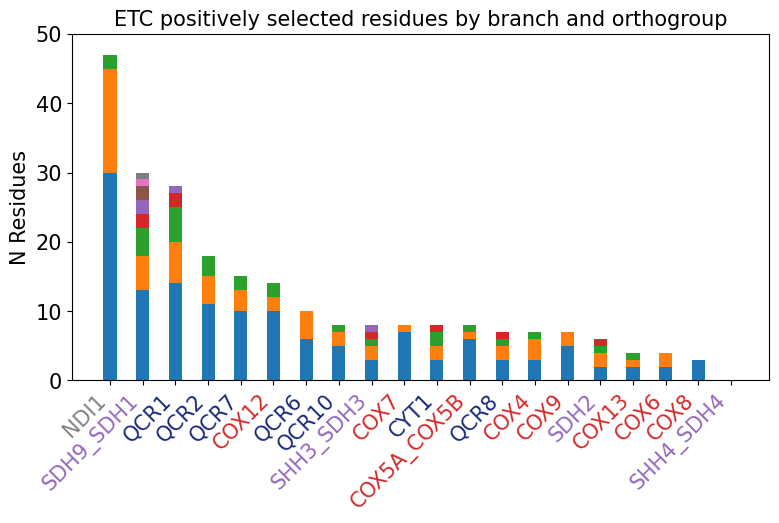

In [108]:
width = 0.4

fig, ax = plt.subplots(figsize = (9,4.5))

etc_table = pd.read_csv(base_dir + os.sep + os.path.normpath('examples/etc/etc_table.csv'), index_col=0)
enzyme_lookup = dict(zip(etc_table['alt_name'], etc_table['enzyme']))
enzyme_lookup['COX5A_COX5B'] = 'cytochrome c oxidase'
enzyme_lookup['SHH3_SDH3'] = 'succinate dehydrogenase'
enzyme_lookup['SHH4_SDH4'] = 'succinate dehydrogenase'
enzyme_lookup['SDH9_SDH1'] = 'succinate dehydrogenase'

subunit_lookup = {    'cytochrome c oxidase': ('cytochrome c oxidase [C IV]', "C3"),
    'succinate dehydrogenase': ('succinate dehydrogenase [C II]', "C4"),
    'ubiquinol:cytochrome bc oxidoreductase': ('cytochrome bc1 complex [CIII]',  "#182877"),
    'NAD dehydrogenase': ('NAD dehydrogenase',"C7")
}

bottom = np.zeros(len(goi_list_sorted))

for jj in range(0,max_branches):
    p = ax.bar(goi_list_sorted, count_mat_df[jj], width, label=str(jj), bottom=bottom)
    bottom += count_mat_df[jj]

ax.set_title("ETC positively selected residues by branch and orthogroup",  fontdict={'size':15})
#ax.legend([]) #loc="upper right")
ax.set_ylabel("N Residues",  fontdict={'size':15})
ax.set_ylim([0,50])

ax.set_xticks(list(range(0,len(goi_list_sorted))))
ax.set_xticklabels(goi_list_sorted, rotation=45, ha='right', fontdict={'size':15})

ax.tick_params(labelsize=15)

for xtick in ax.get_xticklabels():
    xtick.set_color(subunit_lookup[enzyme_lookup[xtick.get_text()]][1])


plt.show()
fig.savefig(base_dir + os.sep + os.path.normpath('examples/etc/etc_pos_sel.svg'))

In [112]:
#Normalize by length of protein

tm_align_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed') + os.sep

goi_mean_lengths = {}

for goi, og_ref in og_refs.items(): 
    
    og_ref_fname = tm_align_dir + og_ref + '.tm.fasta'
    
    records = SeqIO.parse(og_ref_fname, "fasta")
    
    lengths = []
    
    for record in records: 
        lengths.append(int( record.description.split()[1].split('L=')[1] ))
    
    goi_mean_lengths[goi] = np.mean(lengths)
    
    #G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\

In [113]:
count_mat_df['mean_length'] = [goi_mean_lengths[goi] for goi in count_mat_df['goi']]

count_mat_df_norm = count_mat_df.copy()

for jj in list(range(0,max_branches)): 
    count_mat_df_norm[jj] = count_mat_df_norm[jj]/count_mat_df_norm['mean_length']
    
count_mat_df_norm['sum_norm_pos_sel_res'] = count_mat_df_norm.loc[:,list(range(0,max_branches))].T.sum()

count_mat_df_norm.sort_values(by='sum_norm_pos_sel_res', ascending=False, inplace=True)


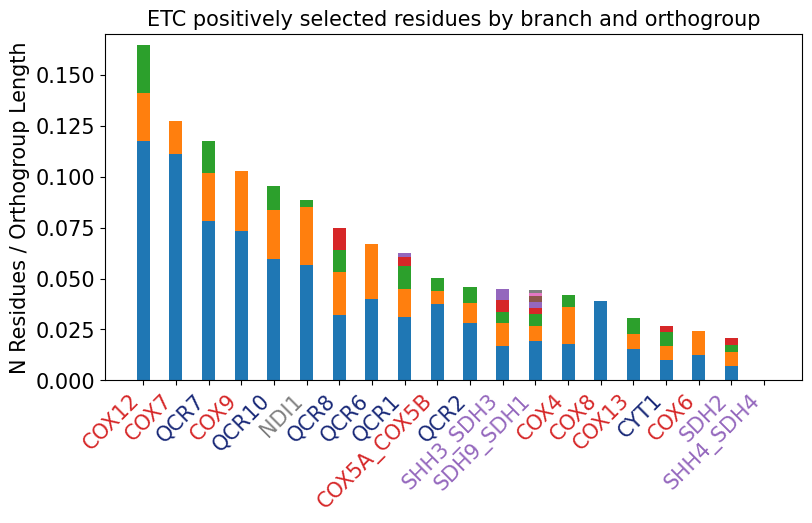

In [114]:
width = 0.4

etc_table = pd.read_csv(base_dir + os.sep + os.path.normpath('examples/etc/etc_table.csv'), index_col=0)
enzyme_lookup = dict(zip(etc_table['alt_name'], etc_table['enzyme']))
enzyme_lookup['COX5A_COX5B'] = 'cytochrome c oxidase'
enzyme_lookup['SHH3_SDH3'] = 'succinate dehydrogenase'
enzyme_lookup['SHH4_SDH4'] = 'succinate dehydrogenase'
enzyme_lookup['SDH9_SDH1'] = 'succinate dehydrogenase'

subunit_lookup = {    'cytochrome c oxidase': ('cytochrome c oxidase [C IV]', "C3"),
    'succinate dehydrogenase': ('succinate dehydrogenase [C II]', "C4"),
    'ubiquinol:cytochrome bc oxidoreductase': ('cytochrome bc1 complex [CIII]',  "#182877"),
    'NAD dehydrogenase': ('NAD dehydrogenase',"C7")
}

fig, ax = plt.subplots(figsize=(9,4.5))
bottom = np.zeros(len(goi_list_sorted))

for jj in range(0,max_branches):
    p = ax.bar(goi_list_sorted, count_mat_df_norm[jj], width, label=str(jj), bottom=bottom)
    bottom += count_mat_df_norm[jj]

ax.set_title("ETC positively selected residues by branch and orthogroup",  fontdict={'size':15})
#ax.legend([]) #loc="upper right")
ax.set_xticks(list(range(0,len(count_mat_df_norm['alt_name']))))
ax.set_xticklabels(count_mat_df_norm['alt_name'], rotation=45, ha='right',  fontdict={'size':15})

for xtick in ax.get_xticklabels():
    xtick.set_color(subunit_lookup[enzyme_lookup[xtick.get_text()]][1])

    
ax.tick_params(labelsize=15)
ax.set_ylabel("N Residues / Orthogroup Length",  fontdict={'size':15})
ax.set_ylim(0, 0.17)


fig.savefig(base_dir + os.sep + os.path.normpath('examples/etc/etc_pos_sel_norm.svg'))

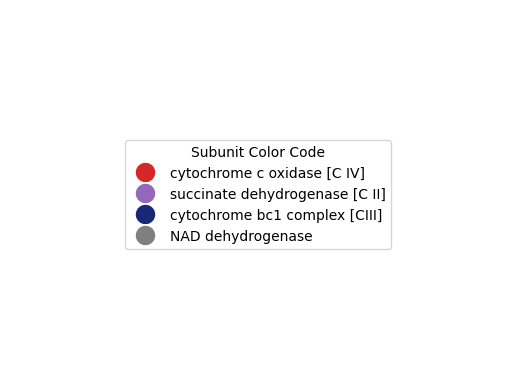

In [13]:
fig, ax = plt.subplots()
legend_elements = []
for subunit, (subunit_label, color) in subunit_lookup.items(): 
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=subunit_label,
                          markerfacecolor=color, markersize=15))
ax.set_axis_off()
ax.legend(handles=legend_elements, loc='center', title='Subunit Color Code')
fig.savefig(base_dir + os.sep + os.path.normpath('examples/etc/subunit_color_code.svg'))

In [ ]:
Number of positively selected residues for each orthogroup in the ETC.  Different colors represent different branches on which positive selection was identified via the branch-site test.  Branches are defined per orthogroup and are unlikely to correspond. 

## For a given Tree, extract residues of interest in terms of both the Ref sequence (usually S. cerevisiae) and Ref Sequence coordinates

In [18]:
og_ref = 'OG1122_REF_Scer_AF-P13711-F1-model_v2'
tree_no = 8
thresh = 0.90
beb_vals_tree = beb_vals[tree_no]
beb_vals_filt = beb_vals_tree[beb_vals_tree['class_2']>thresh]
residues_of_interest = list(zip(beb_vals_filt.index,beb_vals_filt['ref_AA']))

## Extract SC coordinates with coordinates from the trimmed alignment


ref_res_of_int, aln_res_of_int, ref_seq = dyt.identify_ref_residue(og_ref, residues_of_interest)
print(ref_res_of_int)
print(aln_res_of_int)


['Y408', 'A418', 'I452', 'F640']
['Y974', 'A984', 'I1022', 'F1229']


## ETC Sequence assignment for PDB chains


In [115]:
bs_analysis_selres_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_selected_res_fdr.json')

with open(bs_analysis_selres_fname, 'r') as f:
    pos_sel_res = json.load(f)

In [116]:
etc_complexes = ['1', '2']
etc_complex = etc_complexes[1]
pdb_chains_fname = base_dir + os.sep + os.path.normpath('examples/etc/Sequence_dict_one_letter_3_2_4_' + etc_complex + '.pkl')
with open(pdb_chains_fname, 'rb') as f_in:
        pdb_chains_ind = pickle.load(f_in)

In [117]:
pdb_chains_ind.keys()

dict_keys(['CYTB_C', 'RIP1_P', 'QCR10_U', 'COX9_u', 'COX26_x', 'COX2_b', 'QCR8_H', 'QCR10_J', 'COX5A_e', 'COX13_k', 'COX3_o', 'COX9_i', 'COX12_j', 'QCR2_M', 'COX1_a', 'COX26_l', 'COX6_r', 'QCR1 _A', 'COX6_f', 'QCR6_Q', 'COX1_m', 'QCR1 _L', 'CYTB_N', 'RIP1_E', 'COX4_d', 'QCR9_I', 'QCR8_S', 'COX7_g', 'COX8_h', 'COX13_w', 'CYT1_D', 'COX4_p', 'QCR7_G', 'QCR9_T', 'CYT1_O', 'QCR7_R', 'QCR6_F', 'QCR2_B', 'COX7_s', 'COX2_n', 'COX5A_q', 'COX8_t', 'COX12_v', 'COX3_c'])

In [120]:
etc_id_lookup

{'COX12': 'YLR038C',
 'SDH1': 'YKL148C',
 'SDH9': 'YJL045W',
 'SDH4': 'YDR178W',
 'SHH4': 'YLR164W',
 'QCR2': 'YPR191W',
 'SDH3': 'YKL141W',
 'SHH3': 'YMR118C',
 'CYT1': 'YOR065W',
 'SDH2': 'YLL041C',
 'COX6': 'YHR051W',
 'QCR7': 'YDR529C',
 'COX4': 'YGL187C',
 'RIP1': 'YEL024W',
 'COX9': 'YDL067C',
 'COR1': 'YBL045C',
 'COX5B': 'YIL111W',
 'COX5A': 'YNL052W',
 'COX7': 'YMR256C',
 'QCR6': 'YFR033C',
 'QCR8': 'YJL166W',
 'QCR10': 'YHR001W-A',
 'COX13': 'YGL191W',
 'QCR9': 'YGR183C',
 'COX8': 'YLR395C',
 'COX2': 'Q0250',
 'COB': 'Q0105',
 'NDI1': 'YML120C',
 'COX1': 'Q0045',
 'COX3': 'Q0275',
 'COX26': 'YDR119W-A'}

In [128]:
alns[0].seqB

'------------------------------KSTYRTPNFDDVLKENNDADKGRSYAYFMVGAMGLLSSAGAKSTVETFISSMTATADVLAMAKVEVNLAAIPLGKNVVVKWQGKPVFIRHRTPHEIQEANSVDMSALKDPQTDADRVKDPQWLIMLGICTHLGCVPIGEAGDFGGWFCPCHGSHYDISGRIRKGPAPLNLEIPAYEFDGDKVIVG'

In [134]:
bs_analysis_selres_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_selected_res_fdr.json')

with open(bs_analysis_selres_fname, 'r') as f:
    pos_sel_res = json.load(f)

etc_complexes = ['1', '2']

pdb_chains = {}
for etc_complex in etc_complexes:
    pdb_chains_fname = base_dir + os.sep + os.path.normpath('examples/etc/Sequence_dict_one_letter_3_2_4_' + etc_complex + '.pkl')
    with open(pdb_chains_fname, 'rb') as f_in:
        pdb_chains_ind = pickle.load(f_in)

        pdb_chains_ind['QCR1_A'] = pdb_chains_ind['QCR1 _A']
        pdb_chains_ind['QCR1_L'] = pdb_chains_ind['QCR1 _L']
        del pdb_chains_ind['QCR1 _A']
        del pdb_chains_ind['QCR1 _L']
    pdb_chains[etc_complex] = pdb_chains_ind
    
etc_proteins_clustered = pd.read_csv(base_dir + os.sep + os.path.normpath('examples/etc/etc_table.csv'), index_col=0)
etc_id_lookup = dict(zip(etc_proteins_clustered['name'], etc_proteins_clustered['gene_id']))
pdb_name_differences = {'CYTB': 'COB', 
                        'QCR1': 'COR1', 
                        'COX5A': 'COX5A_COX5B'}  #Would need to do other paralogs as well, 'SHH3_SDH3','SDH9_SDH1','SHH4_SDH4'

paralog_ref_seq = {'COX5A_COX5B': 'COX5A', 
                   'SHH3_SDH3': 'SDH3',
                   'SDH9_SDH1': 'SDH1',
                   'SHH4_SDH4': 'SDH4',
                  }

scer_protein_lookup = dyt.load_model_protein_dict('Scer')
    
#For each complex
#For each chain

pos_sel_res_complexes = {}

for etc_complex in etc_complexes: 

    pos_sel_res_chains = {}

    for chain, chain_seq_list in pdb_chains[etc_complex].items():
        print(chain)
        chain_seq = ''.join(chain_seq_list)
        gene_name, chain_id = chain.split('_')

        if gene_name in pos_sel_res.keys():     
            gene_name_ogs = gene_name
        elif gene_name in pdb_name_differences.keys(): 
            gene_name_ogs = pdb_name_differences[gene_name]
        else: 
            gene_name_ogs = gene_name  # No name difference, but not in pos_sel_res.keys
        
        
        if gene_name_ogs in pos_sel_res.keys():
            sel_res_orig = pos_sel_res[gene_name_ogs]['selected_residues'] 

            if gene_name_ogs in paralog_ref_seq.keys(): 
                gene_name_unique = paralog_ref_seq[gene_name_ogs]
            else:
                gene_name_unique = gene_name_ogs

            gene_id = etc_id_lookup[gene_name_unique]
            scer_seq = scer_protein_lookup[gene_id].strip('*') # remove stop codon annotation

            if chain_seq==scer_seq: 
                print( chain + ' is identical to ' + gene_name + ' gene sequence')

            #Choosing global alignment with a high gap penalty for the first sequence (the reference) and a lower gap penalty for the second species)
            alns = pairwise2.align.globalxd(scer_seq, chain_seq, extendA = -2, openA =-1, extendB=-0.5, openB=-1 )

            (seq_out, msa2input, input2msa, pair_mapping) = dyt.seq_squeeze(alns[0].seqB)
            #The seq_squeeze_reindex is 0-based


            sel_res_chain = [] 

            for res_ind in sel_res_orig: 
                res = res_ind[0]
                ind = int(res_ind[1:])

                #Chain ind is 0 based and res_ind is 1-based
                chain_ind_0 = msa2input[ind-1]

                if chain_ind_0==None:
                    print('Selected Residue not mapped to chain: ' + chain + ' ' + res_ind)
                else: 
                    sel_res_chain.append(res + str(chain_ind_0 + 1))
                    assert chain_seq[chain_ind_0]==res, 'Selected Residue mismatch: ' + res_ind + ' Residue different from chain in chain' + chain

            pos_sel_res_chains[chain] = sel_res_chain
        
        else: 
            print(gene_name_ogs + ' has no positively selected residues calculated')
    
    pos_sel_res_complexes[etc_complex] = pos_sel_res_chains

# Save pos_sel_res_data
etc_pos_sel_res_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/etc_bs_selected_res_chain.json')

with open(etc_pos_sel_res_fname, 'w') as f:
    json.dump(pos_sel_res_complexes, f, sort_keys=True, indent=4 )

#Pairwise blast of chain onto complex

CYTB_C
COB has no positively selected residues calculated
RIP1_P
QCR10_U
Selected Residue not mapped to chain: QCR10_U G63
Selected Residue not mapped to chain: QCR10_U L66
Selected Residue not mapped to chain: QCR10_U L62
Selected Residue not mapped to chain: QCR10_U L55
Selected Residue not mapped to chain: QCR10_U P72
Selected Residue not mapped to chain: QCR10_U N77
COX2_b
COX2 has no positively selected residues calculated
QCR8_H
COX5A_e
COX13_k
COX9_i
COX12_j
QCR2_M
COX1_a
COX1 has no positively selected residues calculated
COX6_f
Selected Residue not mapped to chain: COX6_f D45
COX26_m
COX26 has no positively selected residues calculated
QCR6_Q
CYTB_N
COB has no positively selected residues calculated
COX4_d
RIP1_E
COX7_g
COX8_h
QCR9_I
QCR8_S
QCR10_V
Selected Residue not mapped to chain: QCR10_V G63
Selected Residue not mapped to chain: QCR10_V L66
Selected Residue not mapped to chain: QCR10_V L62
Selected Residue not mapped to chain: QCR10_V P72
Selected Residue not mapped to c

These genes don't have selection calculations (they were filtered out - mostly mitochondrial - except for COX26) 
COX2, COX2, COX3, COX26, COB

## ETC Alignment Visualization

In [172]:
gois = ['COR1', 'QCR2', 'COX5A_COX5B']  #COR1 is also called QCR1

for goi in gois: 
    og_ref = og_refs[goi] #'OG1122_REF_Scer_AF-P13711-F1-model_v2'
    print('{}: {}'.format(goi,og_ref))
    orig_aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
    jalview_aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed_jalview/' + og_ref + '.tm.fasta')

    orig_aln = SeqIO.parse(orig_aln_fname, 'fasta')

    with open(jalview_aln_fname,'w') as f_out:
        for record in orig_aln: 
            f_out.write('>' + record.id + '\n')
            f_out.write(str(record.seq) + '\n')


COR1: OG4150_REF_Scer_AF-P07256-F1-model_v2
QCR2: OG2006_REF_Scer_AF-P07257-F1-model_v2
COX5A_COX5B: OG4316_REF_Scer_AF-P00424-F1-model_v2


In [11]:
y1000plus_dir 

'C:\\Users\\bheineike\\Documents\\GitHub\\y1000plus_tools\\data\\'

In [13]:
y1000_species = pd.read_csv( y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/y1000_species_table.csv"), index_col=0)

In [14]:
y1000_species

,original_genome_id,old_species_names,species_names_fig2,hex,id_table S1,Species name,Major clade,clade_order,Family,Genus,CUG usage,spec_og_id
ID,,,,,,,,,,,,
1,saprochaete_clavata,Saprochaete_clavata,Saprochaete_clavata,#FF2800,22,Saprochaete clavata,Dipodascaceae/Trichomonascaceae,3,Dipodascaceae,Saprochaete,Leu,118
2,yHMPu5000034974_deakozyma_indianensis_160519,yHMPu5000034974_Deakozyma_indianensis,Deakozyma_indianensis,#FF2800,39,Deakozyma indianensis,Dipodascaceae/Trichomonascaceae,3,Saccharomycetales incertae sedis,Deakozyma,Leu,251
3,clavispora_lusitaniae,Clavispora_lusitaniae,Clavispora_lusitaniae,#FFd200,135,Clavispora lusitaniae,CUG-Ser1,8,Metschnikowiaceae,Clavispora,Ser,32
4,yHMPu5000034999_cephaloascus_fragrans_160519,yHMPu5000034999_Cephaloascus_fragrans,Cephaloascus_fragrans,#FFd200,204,Cephaloascus fragrans,CUG-Ser1,8,Cephaloascaceae,Cephaloascus,Ser,258
5,yHMPu5000034998_cephaloascus_albidus_160519,yHMPu5000034998_Cephaloascus_albidus,Cephaloascus_albidus,#FFd200,205,Cephaloascus albidus,CUG-Ser1,8,Cephaloascaceae,Cephaloascus,Ser,257
...,...,...,...,...,...,...,...,...,...,...,...,...
339,Saitoella_complicata,Saitoella_complicata,Saitoella_complicata,#050f07,339,Saitoella complicata,outgroup,0,outgroup,outgroup,Leu,117
340,sclerotinia_sclerotiorum,Sclerotinia_sclerotiorum,Sclerotinia_sclerotiorum,#050f07,340,Sclerotinia sclerotiorum,outgroup,0,outgroup,outgroup,Leu,122
341,stagonospora_nodorum,Stagonospora_nodorum,Stagonospora_nodorum,#050f07,341,Stagonospora nodorum,outgroup,0,outgroup,outgroup,Leu,129


In [28]:
# For QCR2 Make tree to help with alignment visualization. 

tree_fname_base = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
og_ref = 'OG2006_REF_Scer_AF-P07257-F1-model_v2'

fname_tree = tree_fname_base + os.sep + og_ref + '.tm.fasta.clipkit.treefile'

t = Tree(fname_tree, format=1)  
t.ladderize()
ts = TreeStyle()
ts.show_leaf_name = False

#ts.mode = "c"
#ts.arc_start = -90
#ts.arc_span = 180

#Get sequence lists and color mapping given sets of ancestors

# ancestor_pairs = {'Scer': ['REF_Scer_AF-P13711-F1-model_v2.pdb','wickerhamomyces_anomalus__OG1122__139_4015.pdb'], 
#                   'Ylip': ['lipomyces_starkeyi__OG1122__66_2599.pdb','yarrowia_lipolytica__OG1122__144_365.pdb'], 
#                   'Ptan': ['pachysolen_tannophilus__OG1122__106_418.pdb', 'ogataea_parapolymorpha__OG1122__104_568.pdb']
#                  }

# set_lists = {}

# for spec_set_abbrev, anc_pair in ancestor_pairs.items(): 
#     t_sub = t.get_common_ancestor(anc_pair)
#     set_lists[spec_set_abbrev] = t_sub.get_leaf_names()
    
# set_lists['Calb'] = ['Calb_AF-Q5AJD9-F1-model_v2.pdb', 'candida_tropicalis__OG1122__30_22.pdb','debaryomyces_hansenii__OG1122__36_1303.pdb',
#                       'candida_tropicalis__OG1122__30_2842.pdb','debaryomyces_hansenii__OG1122__36_5580.pdb','candida_tropicalis__OG1122__30_1826.pdb']
# set_lists['Arub'] = ['ascoidea_rubescens__OG1122__6_2243.pdb']


# tab20_cmap = cm.tab20

# set_colors = {'Scer': colors.to_hex(tab20_cmap(17)), #''#cfc438',
#               'Arub': colors.to_hex(tab20_cmap(19)), #'#f5c425', 
#               'Ylip': colors.to_hex(tab20_cmap(14)), #'#86cdf0', 
#               'Ptan': colors.to_hex(tab20_cmap(2)), #'#b49ed9', 
#               'Calb': colors.to_hex(tab20_cmap(7)), # '#f28fb0'
#              }

              
# set_lookup = {}

# for spec_set_abbrev, protein_set in set_lists.items(): 
#     for protein_id in protein_set: 
#         set_lookup[protein_id] = spec_set_abbrev

species_set = pd.read_csv(os.path.normpath(base_dir + '/selected_proteins/species_selection/species_selection.csv'), index_col = 0)
species_set_filt = species_set.loc[species_set['Load']=='Y']

clade_lookup = dict(zip(species_set_filt['original_genome_id'], species_set_filt['Major clade']))

clade_color_lookup = {'Outgroup': colors.to_hex(tab20_cmap(15)), 
                      'Lipomycetaceae': colors.to_hex(tab20_cmap(14)),
                      'Trigonopsidaceae': colors.to_hex(tab20_cmap(11)),
                      'Dipodascaceae/Trichomonascaceae': colors.to_hex(tab20_cmap(10)),
                      'Alloascoideaceae': colors.to_hex(tab20_cmap(13)),
                      'Sporopachydermia clade': colors.to_hex(tab20_cmap(12)),
                      'CUG-Ala': colors.to_hex(tab20_cmap(3)),
                      'Pichiaceae': colors.to_hex(tab20_cmap(2)),
                      'CUG-Ser1': colors.to_hex(tab20_cmap(7)),
                      'CUG-Ser2': colors.to_hex(tab20_cmap(19)),
                      'Phaffomycetaceae': colors.to_hex(tab20_cmap(18)),
                      'Saccharomycodaceae': colors.to_hex(tab20_cmap(8)),
                      'Saccharomycetaceae, KLE': colors.to_hex(tab20_cmap(9)),
                      'Saccharomycetaceae, ZT': colors.to_hex(tab20_cmap(5)),
                      'Saccharomycetaceae, post WGH': colors.to_hex(tab20_cmap(17))
                     }



for n in t.get_leaves(): 
    orig_id = n.name
    orig_id = orig_id.split('.')[0] # remove .pdb
    spec, protein_id = dyt.species_from_fasta_id(orig_id)
    
    if spec=='schizosaccharomyces_pombe': 
        clade = 'Outgroup'
    else: 
        clade = clade_lookup[spec]
        if clade=='Saccharomycetaceae':
            if spec in ['kluyveromyces_lactis','kluyveromyces_marxianus', 'lachancea_thermotolerans','eremothecium_gossypii']: 
                clade = 'Saccharomycetaceae, KLE'
            elif spec in ['zygosaccharomyces_rouxii','torulaspora_delbrueckii']:
                clade = 'Saccharomycetaceae, ZT'
            elif spec in ['saccharomyces_cerevisiae','kazachstania_naganishii', 'vanderwaltozyma_polyspora']: 
                clade = 'Saccharomycetaceae, post WGH'  
    
    print(orig_id)
    new_name = dyt.protein_id_shorten(orig_id)
    print(new_name)
    #n.name = new_name
    #set_id = set_lookup[n.name]
    nstyle = NodeStyle()
    nstyle['bgcolor'] = clade_color_lookup[clade]
    n.set_style(nstyle)
    new_name_face = TextFace(new_name, ftype='Verdana', fsize=20, fgcolor='black',  penwidth=1, fstyle='normal', tight_text=False, bold=False)
    n.add_face(new_name_face, column = 0, position='branch-right')
    
#t.render('%%inline', w=2000, tree_style=ts)
t.render(base_dir + os.sep + os.path.normpath('examples/etc/qcr2/protein_tree.svg'), tree_style = ts)

Calb_AF-P83782-F1-model_v2
candida_albicans__P83782
candida_tropicalis__OG2006__30_2388
candida_tropicalis__30_2388
debaryomyces_hansenii__OG2006__36_4265
debaryomyces_hansenii__36_4265
pachysolen_tannophilus__OG2006__106_5064
pachysolen_tannophilus__106_5064
komagataella_pastoris__OG2006__52_2229
komagataella_pastoris__52_2229
ogataea_parapolymorpha__OG2006__104_513
ogataea_parapolymorpha__104_513
yHMPu5000034604_sporopachydermia_lactativora_160519__OG2006__170_5018
sporopachydermia_lactativora__170_5018
alloascoidea_hylecoeti__OG2006__0_278
alloascoidea_hylecoeti__0_278
candida_apicola__OG2006__13_3506
candida_apicola__13_3506
yarrowia_lipolytica__OG2006__144_240
yarrowia_lipolytica__144_240
tortispora_caseinolytica__OG2006__134_4520
tortispora_caseinolytica__134_4520
Spom_AF-P78761-F1-model_v2
schizosaccharomyces_pombe__P78761
lipomyces_starkeyi__OG2006__66_6193
lipomyces_starkeyi__66_6193
geotrichum_candidum__OG2006__43_3508
geotrichum_candidum__43_3508
geotrichum_candidum__OG2006_

{'nodes': [[0.5, 116.6904296875, 4.5, 120.6904296875, 0, None],
  [12.23829867242415, 19.0, 16.23829867242415, 23.0, 1, None],
  [11.08106299559148, 59.0, 15.08106299559148, 63.0, 2, None],
  [24.321721622798247,
   214.380859375,
   28.321721622798247,
   218.380859375,
   3,
   None],
  [42.919604226147854, 99.0, 46.919604226147854, 103.0, 4, None],
  [39.84403803787722, 329.76171875, 43.84403803787722, 333.76171875, 5, None],
  [55.25110240831934, 169.0, 59.25110240831934, 173.0, 6, None],
  [94.04974390048862, 139.0, 98.04974390048862, 143.0, 7, None],
  [73.06553245676122, 199.0, 77.06553245676122, 203.0, 8, None],
  [133.7195144270092, 179.0, 137.7195144270092, 183.0, 9, None],
  [110.06731926301524, 219.0, 114.06731926301524, 223.0, 10, None],
  [48.51675008922031, 490.5234375, 52.51675008922031, 494.5234375, 11, None],
  [75.86923712891839, 299.625, 79.86923712891839, 303.625, 12, None],
  [112.33051845664853, 259.0, 116.33051845664853, 263.0, 13, None],
  [91.64431287245013, 3

In [24]:
old_name = 'yHMPu5000034604_sporopachydermia_lactativora_160519__OG2006__170_5018'
new_name = dyt.protein_id_shorten(old_name)
print(new_name)

sporopachydermia_lactativora__170_5018


In [17]:
'yHMPu5000034604_sporopachydermia_lactativora_160519'

'saccharomyces_cerevisiae'

candida_albicans P83782
candida_tropicalis 30_2388
debaryomyces_hansenii 36_4265
pachysolen_tannophilus 106_5064
komagataella_pastoris 52_2229
ogataea_parapolymorpha 104_513
yHMPu5000034604_sporopachydermia_lactativora_160519 170_5018
alloascoidea_hylecoeti 0_278
candida_apicola 13_3506
yarrowia_lipolytica 144_240
tortispora_caseinolytica 134_4520
schizosaccharomyces_pombe P78761
lipomyces_starkeyi 66_6193
geotrichum_candidum 43_3508
geotrichum_candidum 43_849
ascoidea_rubescens 6_2535
cyberlindnera_jadinii 35_5432
wickerhamomyces_anomalus 139_2023
saccharomyces_cerevisiae P07257
kazachstania_naganishii 49_3129
vanderwaltozyma_polyspora 136_1634
zygosaccharomyces_rouxii 342_4561
torulaspora_delbrueckii 135_3752
eremothecium_gossypii 40_3359
lachancea_thermotolerans 64_2484
kluyveromyces_lactis 50_2507
kluyveromyces_marxianus 51_4840


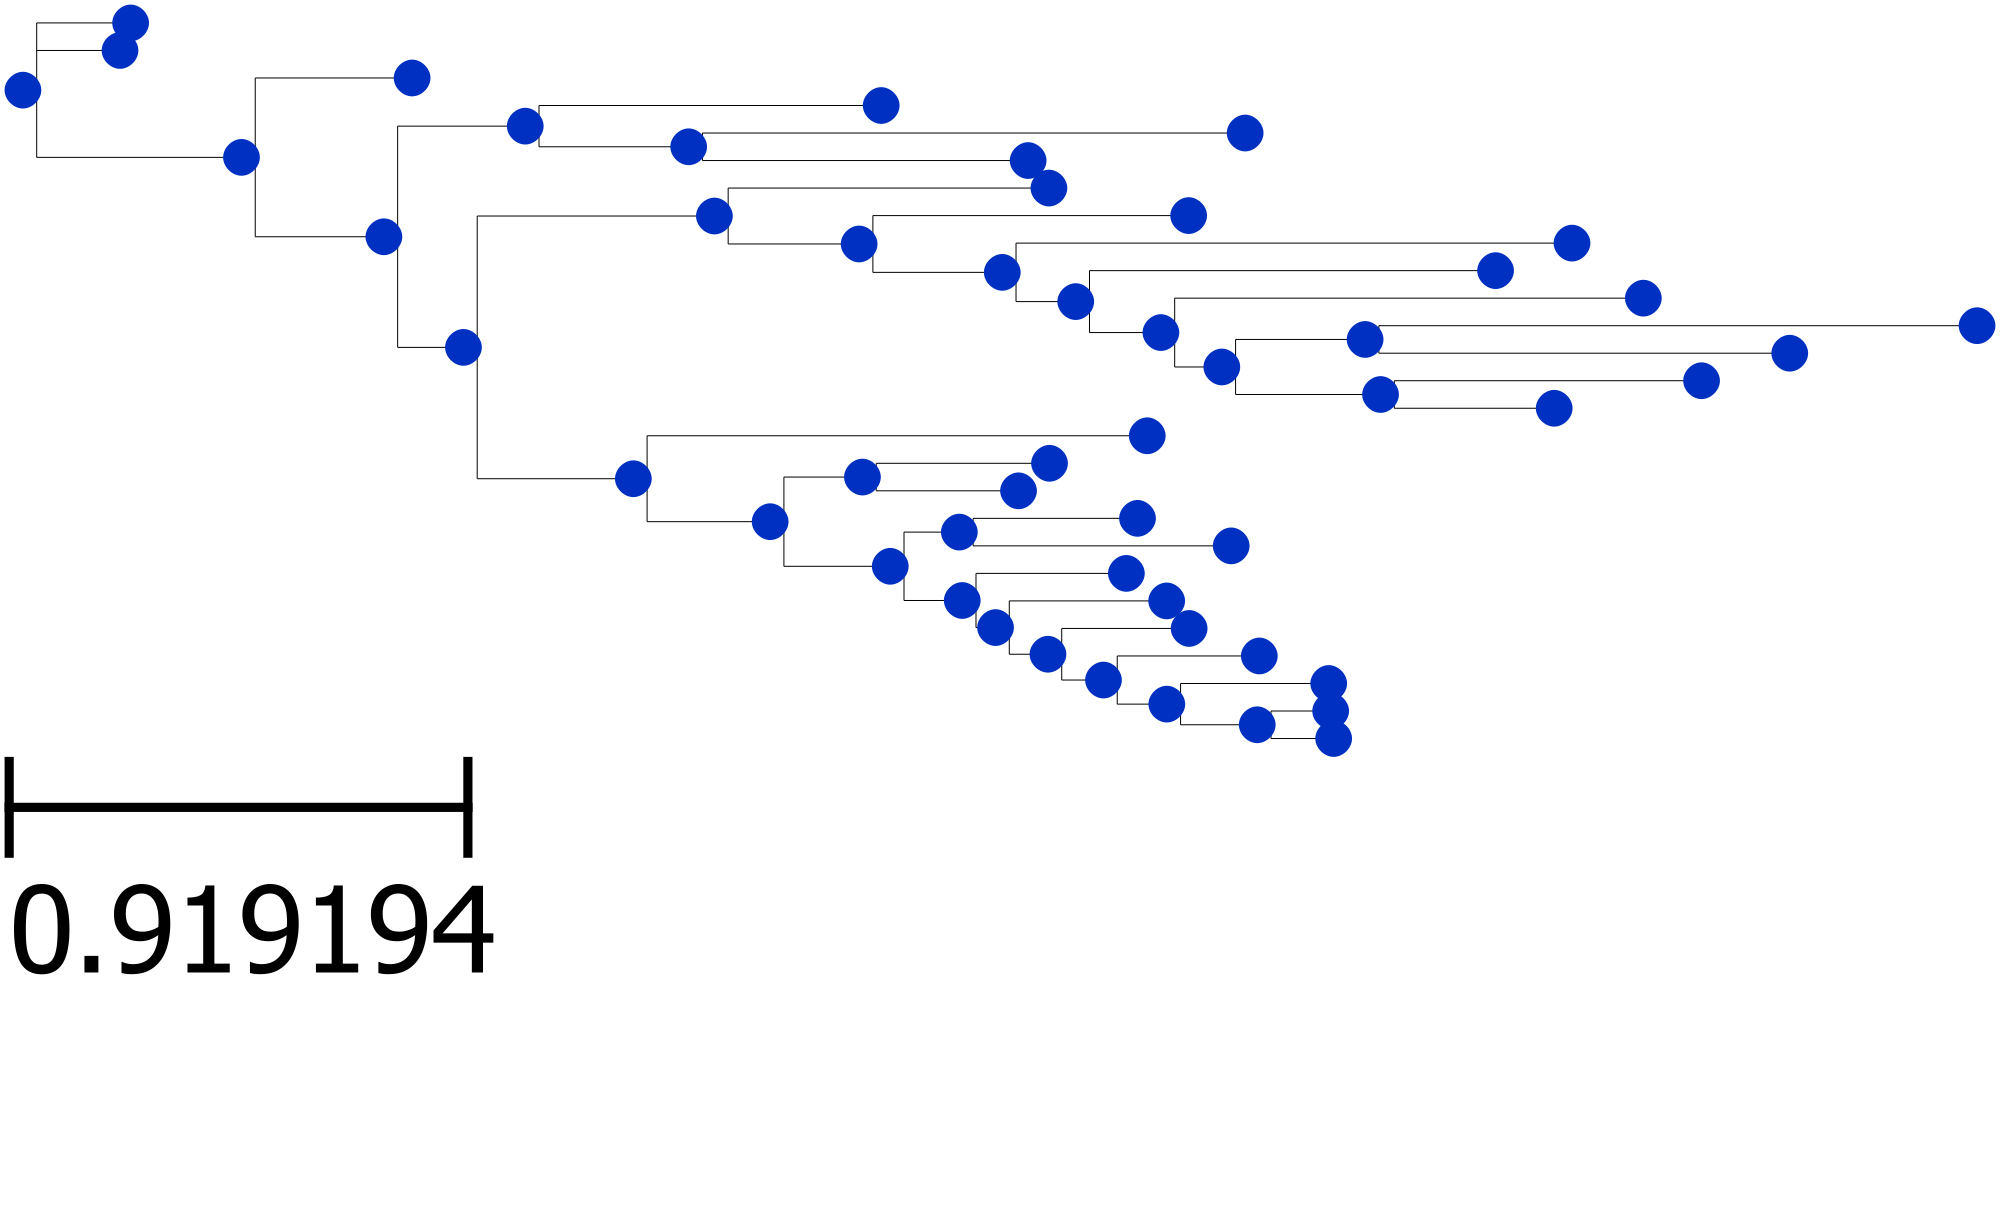

In [10]:
# For QCR2 Make tree to help with alignment visualization. 

tree_fname_base = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
og_ref = 'OG2006_REF_Scer_AF-P07257-F1-model_v2'

fname_tree = tree_fname_base + os.sep + og_ref + '.tm.fasta.clipkit.treefile'

t = Tree(fname_tree, format=1)  
t.ladderize()
ts = TreeStyle()
ts.show_leaf_name = False
#ts.mode = "c"
# ts.arc_start = -90
# ts.arc_span = 180

# #Get sequence lists and color mapping given sets of ancestors

# ancestor_pairs = {'Scer': ['REF_Scer_AF-P13711-F1-model_v2.pdb','wickerhamomyces_anomalus__OG1122__139_4015.pdb'], 
#                   'Ylip': ['lipomyces_starkeyi__OG1122__66_2599.pdb','yarrowia_lipolytica__OG1122__144_365.pdb'], 
#                   'Ptan': ['pachysolen_tannophilus__OG1122__106_418.pdb', 'ogataea_parapolymorpha__OG1122__104_568.pdb']
#                  }

# set_lists = {}

# for spec_set_abbrev, anc_pair in ancestor_pairs.items(): 
#     t_sub = t.get_common_ancestor(anc_pair)
#     set_lists[spec_set_abbrev] = t_sub.get_leaf_names()
    
# set_lists['Calb'] = ['Calb_AF-Q5AJD9-F1-model_v2.pdb', 'candida_tropicalis__OG1122__30_22.pdb','debaryomyces_hansenii__OG1122__36_1303.pdb',
#                       'candida_tropicalis__OG1122__30_2842.pdb','debaryomyces_hansenii__OG1122__36_5580.pdb','candida_tropicalis__OG1122__30_1826.pdb']
# set_lists['Arub'] = ['ascoidea_rubescens__OG1122__6_2243.pdb']


tab20_cmap = cm.tab20

# set_colors = {'Scer': colors.to_hex(tab20_cmap(17)), #''#cfc438',
#               'Arub': colors.to_hex(tab20_cmap(19)), #'#f5c425', 
#               'Ylip': colors.to_hex(tab20_cmap(14)), #'#86cdf0', 
#               'Ptan': colors.to_hex(tab20_cmap(2)), #'#b49ed9', 
#               'Calb': colors.to_hex(tab20_cmap(7)), # '#f28fb0'
#              }

              
# set_lookup = {}

# for spec_set_abbrev, protein_set in set_lists.items(): 
#     for protein_id in protein_set: 
#         set_lookup[protein_id] = spec_set_abbrev

clade_color_lookup = {'Outgroup': colors.to_hex(tab20_cmap(15)), 
                      'Lipomycetaceae': colors.to_hex(tab20_cmap(14)),
                      'Trigonopsidaceae': colors.to_hex(tab20_cmap(11)),
                      'Dipodascaceae/Trichomonascaceae': colors.to_hex(tab20_cmap(10)),
                      'Alloascoideaceae': colors.to_hex(tab20_cmap(13)),
                      'Sporopachydermia clade': colors.to_hex(tab20_cmap(12)),
                      'CUG-Ala': colors.to_hex(tab20_cmap(3)),
                      'Pichiaceae': colors.to_hex(tab20_cmap(2)),
                      'CUG-Ser1': colors.to_hex(tab20_cmap(7)),
                      'CUG-Ser2': colors.to_hex(tab20_cmap(19)),
                      'Phaffomycetaceae': colors.to_hex(tab20_cmap(18)),
                      'Saccharomycodaceae': colors.to_hex(tab20_cmap(8)),
                      'Saccharomycetaceae, KLE': colors.to_hex(tab20_cmap(9)),
                      'Saccharomycetaceae, ZT': colors.to_hex(tab20_cmap(5)),
                      'Saccharomycetaceae, post WGH': colors.to_hex(tab20_cmap(17))
                     }




for n in t.get_leaves(): 
    name = n.name
    spec, prot_id = dyt.species_from_fasta_id(name.split('.')[0])
    new_name = dyt.protein_id_shorten(name)
    # #n.name = new_name
    # set_id = set_lookup[n.name]
    # nstyle = NodeStyle()
    nstyle['bgcolor'] = clade_color_lookup[major_clade]
    # n.set_style(nstyle)
    # new_name_face = TextFace(new_name, ftype='Verdana', fsize=20, fgcolor='black',  penwidth=1, fstyle='normal', tight_text=False, bold=False)
    # n.add_face(new_name_face, column = 0, position='branch-right')
    
t.render('%%inline', w=2000, tree_style=ts)
# t.render(base_dir + os.sep + os.path.normpath('examples/pox1/protein_tree.svg'), tree_style = ts)



## Pox1 Visualization

In [2]:
#Prep Fasta file so that Pox1 can be easily visualized in Jalview
#Headers from fasta: >Calb_AF-Q5AJD9-F1-model_v2.pdb	L=709	d0=9.18	seqID=0.457	TM-score=0.91221
#Names in tree: 
#Treefile: "G:\My Drive\Crick_LMS\projects\diverse_yeasts\alphafold\msas\structural\tm_align\trees\OG1022_REF_Scer_AF-P38715-F1-model_v2.tm.fasta.clipkit.treefile"
#Calb_AF-A0A1D8PNK3-F1-model_v2.pdb

#Read in Fasta and remove everything after the tab: 

### To Load Tree in Jalview, the name needs to match the alignment.  The alignment has all these other items in it

og_ref = 'OG1122_REF_Scer_AF-P13711-F1-model_v2'
orig_aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed/' + og_ref + '.tm.fasta')
jalview_aln_fname = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/fasta_renamed_jalview/' + og_ref + '.tm.fasta')

orig_aln = SeqIO.parse(orig_aln_fname, 'fasta')

with open(jalview_aln_fname,'w') as f_out:
    for record in orig_aln: 
        f_out.write('>' + record.id + '\n')
        f_out.write(str(record.seq) + '\n')



In [27]:
tree_fname_base = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
og_ref = 'OG1122_REF_Scer_AF-P13711-F1-model_v2'

fname_tree = tree_fname_base + os.sep + og_ref + '.tm.fasta.clipkit.treefile'

t = Tree(fname_tree, format=1)  
t.ladderize()
ts = TreeStyle()
ts.show_leaf_name = False
#ts.mode = "c"
#ts.arc_start = -90
#ts.arc_span = 180

#Get sequence lists and color mapping given sets of ancestors

ancestor_pairs = {'Scer': ['REF_Scer_AF-P13711-F1-model_v2.pdb','wickerhamomyces_anomalus__OG1122__139_4015.pdb'], 
                  'Ylip': ['lipomyces_starkeyi__OG1122__66_2599.pdb','yarrowia_lipolytica__OG1122__144_365.pdb'], 
                  'Ptan': ['pachysolen_tannophilus__OG1122__106_418.pdb', 'ogataea_parapolymorpha__OG1122__104_568.pdb']
                 }

set_lists = {}

for spec_set_abbrev, anc_pair in ancestor_pairs.items(): 
    t_sub = t.get_common_ancestor(anc_pair)
    set_lists[spec_set_abbrev] = t_sub.get_leaf_names()
    
set_lists['Calb'] = ['Calb_AF-Q5AJD9-F1-model_v2.pdb', 'candida_tropicalis__OG1122__30_22.pdb','debaryomyces_hansenii__OG1122__36_1303.pdb',
                      'candida_tropicalis__OG1122__30_2842.pdb','debaryomyces_hansenii__OG1122__36_5580.pdb','candida_tropicalis__OG1122__30_1826.pdb']
set_lists['Arub'] = ['ascoidea_rubescens__OG1122__6_2243.pdb']


tab20_cmap = cm.tab20

set_colors = {'Scer': colors.to_hex(tab20_cmap(17)), #''#cfc438',
              'Arub': colors.to_hex(tab20_cmap(19)), #'#f5c425', 
              'Ylip': colors.to_hex(tab20_cmap(14)), #'#86cdf0', 
              'Ptan': colors.to_hex(tab20_cmap(2)), #'#b49ed9', 
              'Calb': colors.to_hex(tab20_cmap(7)), # '#f28fb0'
             }

              
set_lookup = {}

for spec_set_abbrev, protein_set in set_lists.items(): 
    for protein_id in protein_set: 
        set_lookup[protein_id] = spec_set_abbrev

# clade_color_lookup = {'Outgroup': colors.to_hex(tab20_cmap(15)), 
#                       'Lipomycetaceae': colors.to_hex(tab20_cmap(14)),
#                       'Trigonopsidaceae': colors.to_hex(tab20_cmap(11)),
#                       'Dipodascaceae/Trichomonascaceae': colors.to_hex(tab20_cmap(10)),
#                       'Alloascoideaceae': colors.to_hex(tab20_cmap(13)),
#                       'Sporopachydermia clade': colors.to_hex(tab20_cmap(12)),
#                       'CUG-Ala': colors.to_hex(tab20_cmap(3)),
#                       'Pichiaceae': colors.to_hex(tab20_cmap(2)),
#                       'CUG-Ser1': colors.to_hex(tab20_cmap(7)),
#                       'CUG-Ser2': colors.to_hex(tab20_cmap(19)),
#                       'Phaffomycetaceae': colors.to_hex(tab20_cmap(18)),
#                       'Saccharomycodaceae': colors.to_hex(tab20_cmap(8)),
#                       'Saccharomycetaceae, KLE': colors.to_hex(tab20_cmap(9)),
#                       'Saccharomycetaceae, ZT': colors.to_hex(tab20_cmap(5)),
#                       'Saccharomycetaceae, post WGH': colors.to_hex(tab20_cmap(17))
#                      }




for n in t.get_leaves(): 
    new_name = dyt.protein_id_shorten(n.name) # may need to remove the .pdb
    #n.name = new_name
    set_id = set_lookup[n.name]
    nstyle = NodeStyle()
    nstyle['bgcolor'] = set_colors[set_id]
    n.set_style(nstyle)
    new_name_face = TextFace(new_name, ftype='Verdana', fsize=20, fgcolor='black',  penwidth=1, fstyle='normal', tight_text=False, bold=False)
    n.add_face(new_name_face, column = 0, position='branch-right')
    
#t.render('%%inline', w=2000, tree_style=ts)
t.render(base_dir + os.sep + os.path.normpath('examples/pox1/protein_tree.svg'), tree_style = ts)

{'nodes': [[0.5, 104.9130859375, 4.5, 108.9130859375, 0, None],
  [8.215600813656124, 19.0, 12.215600813656124, 23.0, 1, None],
  [8.67713946044887, 59.0, 12.67713946044887, 63.0, 2, None],
  [17.74960894001872,
   190.826171875,
   21.74960894001872,
   194.826171875,
   3,
   None],
  [36.87517711952607, 99.0, 40.87517711952607, 103.0, 4, None],
  [27.00999388367915, 282.65234375, 31.00999388367915, 286.65234375, 5, None],
  [34.55431162683077, 159.0, 38.55431162683077, 163.0, 6, None],
  [78.56536096274975, 139.0, 82.56536096274975, 143.0, 7, None],
  [63.67595946561197, 179.0, 67.67595946561197, 183.0, 8, None],
  [39.51833358775552, 406.3046875, 43.51833358775552, 410.3046875, 9, None],
  [95.92703109988729, 219.0, 99.92703109988729, 223.0, 10, None],
  [54.09046091531169, 593.609375, 58.09046091531169, 597.609375, 11, None],
  [70.40826439298777, 317.671875, 74.40826439298777, 321.671875, 12, None],
  [130.61774351633832, 259.0, 134.61774351633832, 263.0, 13, None],
  [93.0258081

## HSU1 Branch Site analysis

In [23]:
#Load branch site analysis data
bs_analysis_data_fname = base_dir + os.sep + os.path.normpath('selection_calculations/branch_site/bs_analysis_hsu1.json')

with open(bs_analysis_data_fname, 'r') as f:
    bs_analysis_data = json.load(f)

In [24]:
bs_analysis_data['HSU1']

{'1': {'branch_label': '33..34',
  'branch_site_stats': {'bs_stat': 19.354352000009385,
   'm1_dn': 0.0629,
   'm1_dnds': 62.4467,
   'm1_ds': 0.001,
   'mlA': -39058.525998,
   'mlA_check_convergence': False,
   'mlAfix1': -39068.203174,
   'mlAfix1_check_convergence': False,
   'p_adj': 3.0761931995693104e-05,
   'p_val': 5.428576234534077e-06,
   'sig_flag_chi2': True,
   'sig_flag_p_adj': True},
  'labelled_node': '34',
  'leaf_data': {'leaves_long': ['REF_Scer_AF-P47164-F1-model_v2.pdb',
    'REF_Scer_AF-Q04533-F1-model_v2.pdb',
    'REF_Scer_AF-Q12198-F1-model_v2.pdb',
    'Spom_AF-O74314-F1-model_v2.pdb',
    'alloascoidea_hylecoeti__OG1390__0_1527.pdb',
    'ascoidea_rubescens__OG1390__6_1513.pdb',
    'candida_apicola__OG1390__13_4027.pdb',
    'cyberlindnera_jadinii__OG1390__35_1323.pdb',
    'cyberlindnera_jadinii__OG1390__35_2446.pdb',
    'eremothecium_gossypii__OG1390__40_1574.pdb',
    'geotrichum_candidum__OG1390__43_3823.pdb',
    'kazachstania_naganishii__OG1390__49_2

In [ ]:


Branch 4 is false and contains str2 and hsu1
Branch 5 is false and contains STR2 paralog and K nag and V pol 
14 is false and contains hsu1 and t del 4235

#Branch 3 is the STR2 proteins
Two residues selected: 

  "site_data": {
                "beb_score": [
                    0.96567,
                    0.98552
                ],
                "pos_sel_res_aln": [
                    "N1495",
                    "G1540"
                ],
                "pos_sel_res_paml": [
                    "G227",
                    "P269"
                ],
                "pos_sel_res_ref": [
                    "N358",
                    "G400"




Branch 6 contains STR2 and all but E. goi_list_sorted
   "site_data": {
                "beb_score": [
                    0.95224,
                    0.9799
                ],
                "pos_sel_res_aln": [
                    "S522",
                    "I680"
                ],
                "pos_sel_res_paml": [
                    "P9",
                    "E123"
                ],
                "pos_sel_res_ref": [
                    "S9",
                    "I132"

Branch 11 is true and contains str2 and all but e gos and l the

 "site_data": {
                "beb_score": [
                    0.97856
                ],
                "pos_sel_res_aln": [
                    "S1506"
                ],
                "pos_sel_res_paml": [
                    "D237"
                ],
                "pos_sel_res_ref": [
                    "S368"
                ]

        
16 is true and contains str2 and 4 others (no KLE)

   "site_data": {
                "beb_score": [
                    0.99603,
                    0.98388,
                    0.99698
                ],
                "pos_sel_res_aln": [
                    "C602",
                    "D677",
                    "G1602"
                ],
                "pos_sel_res_paml": [
                    "C75",
                    "P120",
                    "S331"
                ],
                "pos_sel_res_ref": [
                    "C75",
                    "D129",
                    "G462"

### Recycle Bin

In [31]:
chain_seq = ''.join(chain_seq_list)
gene_name, chain_id = chain.split('_')

if gene_name in pos_sel_res.keys():     
    gene_name_ogs = gene_name
else: 
    gene_name_ogs = pdb_name_differences[gene_name]

sel_res_orig = pos_sel_res[gene_name_ogs]['selected_residues'] 

if gene_name_ogs in paralog_ref_seq.keys(): 
    gene_name_unique = paralog_ref_seq[gene_name_ogs]
else:
    gene_name_unique = gene_name_ogs
    
gene_id = etc_id_lookup[gene_name_unique]
scer_seq = scer_protein_lookup[gene_id].strip('*') # remove stop codon annotation

if chain_seq==scer_seq: 
    print( chain + ' is identical to ' + gene_name + ' gene sequence')

#Choosing global alignment with a high gap penalty for the first sequence (the reference) and a lower gap penalty for the second species)
alns = pairwise2.align.globalxd(scer_seq, chain_seq, extendA = -2, openA =-1, extendB=-0.5, openB=-1 )

(seq_out, seq_squeeze_reindex, pair_mapping) = dyt.seq_squeeze(alns[0].seqB)
#The seq_squeeze_reindex is 0-based


sel_res_chain = [] 

for res_ind in sel_res_orig: 
    res = res_ind[0]
    ind = int(res_ind[1:])

    #Chain ind is 0 based and res_ind is 1-based
    chain_ind_0 = seq_squeeze_reindex[ind-1]

    if chain_ind_0==None:
        print('Selected Residue not mapped to chain: ' + chain + ' ' + res_ind)
    else: 
        sel_res_chain.append(res + str(chain_ind_0 + 1))
        assert chain_seq[chain_ind_0]==res, 'Selected Residue mismatch: ' + res_ind + ' Residue different from chain in chain' + chain

pos_sel_res_chains[chain] = sel_res_chain

In [66]:
#Visualize Trees for a list 


#species_table = pd.read_csv(base_dir + os.sep + 'species_selection.csv')
#species_table_short = species_table.loc[species_table['Load']=='Y', ['original_genome_id', 'jacobs_name']]
#spec_time_tree_2_orig = dict(zip(species_table_short['jacobs_name'], species_table_short['original_genome_id']))

#out_image_dir = base_dir + os.sep + 'og_sequences' + os.sep + 'cluster_trees' + os.sep


tree_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
out_image_dir = base_dir + os.sep + os.path.normpath('selection_calculations/tree_images')

for set_name, og_ref_list in og_refs.items():
    for og_ref in og_ref_list: #og = 'OG1004'

        fname_tree = tree_dir + os.sep + og_ref + '.tm.fasta.clipkit.treefile'
        t = Tree(fname_tree, format=1)  
        # ts = TreeStyle()
        # ts.show_leaf_name = False
        # ts.show_branch_length = True

        #     red_node = NodeStyle()
        #     red_node['bgcolor'] = 'red'

        #     blue_node = NodeStyle()
        #     blue_node['bgcolor']= 'LightSteelBlue'


        #     for node in t.traverse(): 
        #         if node.is_leaf():
        #             (spec_time_tree, y1000_id) = node.name.split('|')
        #             spec_orig = spec_time_tree_2_orig[spec_time_tree]
        #             if spec_orig in ['saccharomyces_cerevisiae', 'candida_albicans', 'schizosaccaromyces_pombe']:  #probably none in Pombe
        #                 print(node.name)
        #             else:
        #                 new_name = spec_orig + '__' + og + '__' + y1000_id

        #                 if new_name in cluster_names_og['C1']:
        #                     node.set_style(blue_node)
        #                 elif new_name in cluster_names_og['C2']: 
        #                     node.set_style(red_node)

        #                 node.name = new_name
        #                 name_face = AttrFace("name",fsize=20)
        #                 node.add_face(name_face, column=0, position="branch-right") 
        #                 #convert name to primary id

        t.ladderize()
        #t.render('%%inline') #, tree_style=ts)
        t.render(out_image_dir + os.sep + set_name + os.sep + og_ref + '.pdf')  #, tree_style=ts)

In [69]:

#Visualize omega for different trees

tree = '(OG4552_0 #0.033234 , (((((((OG4552_1 #1.19967 , OG4552_11 #0.00897308 ) #999 , OG4552_8 #0.0324229 ) #0.0411581 , (OG4552_9 #0.0304342 , OG4552_14 #2.49748 ) #0.0499443 ) #999 , OG4552_16 #0.216552 ) #1.89263 , (OG4552_10 #1.28001 , OG4552_12 #0.149252 ) #0.0694185 ) #999 , (((OG4552_2 #0.00914513 , OG4552_3 #0.212349 ) #999 , OG4552_13 #0.29135 ) #0.326615 , (OG4552_6 #0.203667 , OG4552_15 #0.36552 ) #1.42919 ) #999 ) #999 , (OG4552_4 #0.354171 , OG4552_7 #0.117535 ) #0.472012 ) #0.383123 , OG4552_5 #0.240703 );'
t = Tree(tree, format=1)

In [22]:
etc_orf_list

['YDR529C',
 'Q0045',
 'YOR065W',
 'YMR118C',
 'YPR191W',
 'YLR395C',
 'YLL041C',
 'YMR256C',
 'YJL166W',
 'YEL024W',
 'YDL067C',
 'YNL052W',
 'YGL187C',
 'YHR001W-A',
 'Q0250',
 'YBL045C',
 'Q0275',
 'YGL191W',
 'Q0105',
 'YIL111W',
 'YFR033C',
 'YKL141W',
 'YGR183C',
 'YLR038C',
 'YJL045W',
 'YLR164W',
 'YDR178W',
 'YML120C',
 'YKL148C',
 'YHR051W']

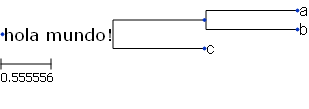

In [4]:
t = Tree( "((a,b),c);" )

# Basic tree style
ts = TreeStyle()
ts.show_leaf_name = True

# Add two text faces to different columns
t.add_face(TextFace("hola "), column=0, position = "branch-right")
t.add_face(TextFace("mundo!"), column=1, position = "branch-right")
t.render('%%inline')

## Visualise Omega from M1 tree for several examples

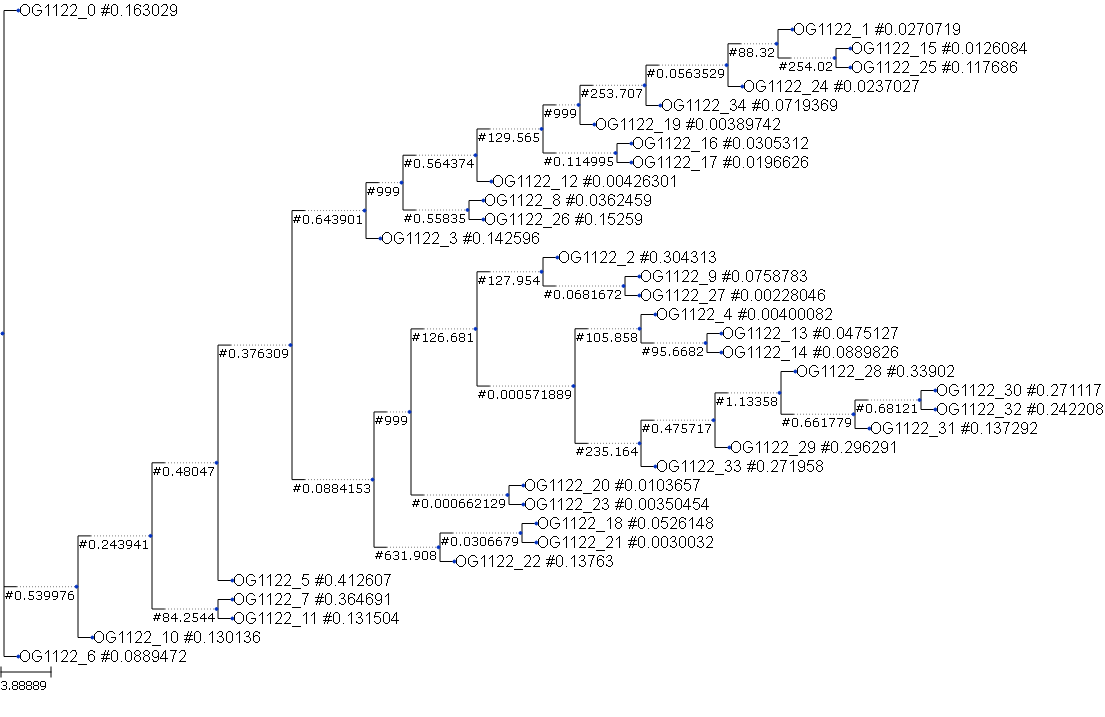

In [4]:
#Visualize Omega for several trees
tree = '(OG1122_0 #0.163029 , ((((((((((((OG1122_1 #0.0270719 , (OG1122_15 #0.0126084 , OG1122_25 #0.117686 ) #254.02 ) #88.32 , OG1122_24 #0.0237027 ) #0.0563529 , OG1122_34 #0.0719369 ) #253.707 , OG1122_19 #0.00389742 ) #999 , (OG1122_16 #0.0305312 , OG1122_17 #0.0196626 ) #0.114995 ) #129.565 , OG1122_12 #0.00426301 ) #0.564374 , (OG1122_8 #0.0362459 , OG1122_26 #0.15259 ) #0.55835 ) #999 , OG1122_3 #0.142596 ) #0.643901 , ((((OG1122_2 #0.304313 , (OG1122_9 #0.0758783 , OG1122_27 #0.00228046 ) #0.0681672 ) #127.954 , ((OG1122_4 #0.00400082 , (OG1122_13 #0.0475127 , OG1122_14 #0.0889826 ) #95.6682 ) #105.858 , (((OG1122_28 #0.33902 , ((OG1122_30 #0.271117 , OG1122_32 #0.242208 ) #0.68121 , OG1122_31 #0.137292 ) #0.661779 ) #1.13358 , OG1122_29 #0.296291 ) #0.475717 , OG1122_33 #0.271958 ) #235.164 ) #0.000571889 ) #126.681 , (OG1122_20 #0.0103657 , OG1122_23 #0.00350454 ) #0.000662129 ) #999 , ((OG1122_18 #0.0526148 , OG1122_21 #0.0030032 ) #0.0306679 , OG1122_22 #0.13763 ) #631.908 ) #0.0884153 ) #0.376309 , OG1122_5 #0.412607 ) #0.48047 , (OG1122_7 #0.364691 , OG1122_11 #0.131504 ) #84.2544 ) #0.243941 , OG1122_10 #0.130136 ) #0.539976 , OG1122_6 #0.0889472 );' 
#'(OG4552_0 #0.033234 , (((((((OG4552_1 #1.19967 , OG4552_11 #0.00897308 ) #999 , OG4552_8 #0.0324229 ) #0.0411581 , (OG4552_9 #0.0304342 , OG4552_14 #2.49748 ) #0.0499443 ) #999 , OG4552_16 #0.216552 ) #1.89263 , (OG4552_10 #1.28001 , OG4552_12 #0.149252 ) #0.0694185 ) #999 , (((OG4552_2 #0.00914513 , OG4552_3 #0.212349 ) #999 , OG4552_13 #0.29135 ) #0.326615 , (OG4552_6 #0.203667 , OG4552_15 #0.36552 ) #1.42919 ) #999 ) #999 , (OG4552_4 #0.354171 , OG4552_7 #0.117535 ) #0.472012 ) #0.383123 , OG4552_5 #0.240703 );'
#'(OG4555_0 #0.371144 , (((((((OG4555_1 #0.0401007 , OG4555_14 #193.338 ) #0.0206283 , OG4555_9 #0.278729 ) #0.308471 , OG4555_15 #0.133923 ) #0.39652 , (((OG4555_2 #0.0396629 , OG4555_13 #0.00242407 ) #0.0216605 , (((OG4555_3 #0.0430765 , OG4555_11 #0.0430739 ) #0.170912 , OG4555_8 #0.416276 ) #388.26 , OG4555_4 #0.782766 ) #499.349 ) #1.62161 , (OG4555_16 #0.0438976 , OG4555_17 #0.538332 ) #329.962 ) #0.0414763 ) #339.207 , OG4555_7 #0.0748496 ) #0.148236 , (OG4555_10 #0.111478 , OG4555_12 #0.162628 ) #1.00136 ) #0.548781 , OG4555_6 #0.441593 ) #0.198348 , OG4555_5 #0.0503427 );'
t = Tree(tree, format=1)
for node in t.traverse():
    if not(node.is_leaf()):
        node.add_face(TextFace(node.name, fsize=8), column=0, position='branch-bottom')
t.ladderize
t.render('%%inline')

In [5]:
t.write(format=9)

'(OG1122_0 #0.163029,((((((((((((OG1122_1 #0.0270719,(OG1122_15 #0.0126084,OG1122_25 #0.117686)),OG1122_24 #0.0237027),OG1122_34 #0.0719369),OG1122_19 #0.00389742),(OG1122_16 #0.0305312,OG1122_17 #0.0196626)),OG1122_12 #0.00426301),(OG1122_8 #0.0362459,OG1122_26 #0.15259)),OG1122_3 #0.142596),((((OG1122_2 #0.304313,(OG1122_9 #0.0758783,OG1122_27 #0.00228046)),((OG1122_4 #0.00400082,(OG1122_13 #0.0475127,OG1122_14 #0.0889826)),(((OG1122_28 #0.33902,((OG1122_30 #0.271117,OG1122_32 #0.242208),OG1122_31 #0.137292)),OG1122_29 #0.296291),OG1122_33 #0.271958))),(OG1122_20 #0.0103657,OG1122_23 #0.00350454)),((OG1122_18 #0.0526148,OG1122_21 #0.0030032),OG1122_22 #0.13763))),OG1122_5 #0.412607),(OG1122_7 #0.364691,OG1122_11 #0.131504)),OG1122_10 #0.130136),OG1122_6 #0.0889472);'

In [ ]:
tree_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/trees')
out_image_dir = base_dir + os.sep + os.path.normpath('selection_calculations/tree_images')

tree_spec = 'OG4555_REF_Scer_AF-P32799-F1-model_v2.tm.fasta.clipkit.treefile'

In [6]:
tree = '(OG1122_0:0.08390,((((((((((((OG1122_1:0.22175,(OG1122_15:0.38094,OG1122_25:0.29127)95.3/97:0.07751)89.9/92:0.06258,OG1122_24:0.19383)6.7/59:0.02964,OG1122_34:0.31840)98.7/99:0.11658,OG1122_19:0.44397)88.9/93:0.05919,(OG1122_16:0.13907,OG1122_17:0.15364)100/100:0.28783)94.8/95:0.15396,OG1122_12:0.44500)100/100:0.54075,(OG1122_8:0.26859,OG1122_26:0.36227)100/100:0.49154)99.8/100:0.34900,OG1122_3:1.01773)96.6/97:0.23697,((((OG1122_2:0.62253,(OG1122_9:1.16411,OG1122_27:0.53277)91.5/81:0.14776)76.5/33:0.08702,((OG1122_4:1.11254,(OG1122_13:0.61855,OG1122_14:0.29524)99.1/100:0.18734)28.9/59:0.09258,(((OG1122_28:0.78338,((OG1122_30:0.24625,OG1122_32:0.41652)90.7/98:0.07659,OG1122_31:0.46336)96.8/98:0.11894)90.9/74:0.08752,OG1122_29:0.29594)85.9/73:0.06952,OG1122_33:0.57181)98/98:0.12384)95/83:0.10720)33.3/30:0.08133,(OG1122_20:0.45962,OG1122_23:0.96559)95.7/89:0.16852)100/100:0.89360,((OG1122_18:0.49362,OG1122_21:0.76395)81/94:0.09814,OG1122_22:0.55986)86.7/94:0.08239)63.3/60:0.08833)98.8/100:0.20573,OG1122_5:0.95026)99.1/100:0.16919,(OG1122_7:0.72969,OG1122_11:0.46483)73.1/65:0.08079)97.6/71:0.11136,OG1122_10:0.28690)100/100:0.25355,OG1122_6:0.09211):0.00000;' 
#'(OG4552_0:0.01146,(((((((OG4552_1:1.18774,OG4552_11:0.10278)54.3/37:0.03944,OG4552_8:0.37053)90.4/52:0.11541,(OG4552_9:0.48833,OG4552_14:0.31995)0/24:0.02204)74.4/41:0.08321,OG4552_16:0.14439)92.8/54:0.17278,(OG4552_10:0.44168,OG4552_12:0.32420)55.3/45:0.17703)50.5/28:0.10870,(((OG4552_2:1.16055,OG4552_3:0.48197)84.2/58:0.42301,OG4552_13:0.18740)91.7/44:0.24718,(OG4552_6:0.31351,OG4552_15:0.16489)42.5/67:0.09350)67.5/33:0.13000)92.9/39:0.18686,(OG4552_4:0.54684,OG4552_7:0.10904)71.2/58:0.07545)97.3/92:0.22923,OG4552_5:0.05663):0.00000;'
#5441: '(OG5441_0:0.61252,((((((OG5441_1:1.56251,OG5441_2:1.99194)24.5/53:0.24381,OG5441_10:1.64470)99.2/98:0.49906,((OG5441_3:0.66598,(OG5441_15:1.32214,OG5441_16:0.27522)98.9/100:0.53414)58/57:0.13056,OG5441_4:0.61813)85.1/75:0.12582)99.6/99:0.32387,(OG5441_9:0.57583,OG5441_12:0.57562)95.6/97:0.15332)97.2/88:0.15321,(OG5441_5:0.68807,OG5441_11:0.80087)65.4/40:0.08622)86.5/41:0.05874,(OG5441_6:0.43659,(OG5441_13:0.35573,OG5441_14:0.21207)100/100:0.37612)98.9/99:0.20436)45.7/44:0.06259,(OG5441_7:0.42592,OG5441_8:0.42647)100/100:0.40933):0.00000;'
#tree = '(1, (((((((2, 15), 10), 16), (((3, 14), (((4, 12), 9), 5)), (17, 18))), 8), (11, 13)), 7), 6);'

t = Tree(tree, format=1)
t.write(format=9)
#t_no_branch = EvolTree(t.write(format=9))
t.mark_tree(['2','15','10','16'], ['#1','#1','#1','#1'])

'(OG1122_0,((((((((((((OG1122_1,(OG1122_15,OG1122_25)),OG1122_24),OG1122_34),OG1122_19),(OG1122_16,OG1122_17)),OG1122_12),(OG1122_8,OG1122_26)),OG1122_3),((((OG1122_2,(OG1122_9,OG1122_27)),((OG1122_4,(OG1122_13,OG1122_14)),(((OG1122_28,((OG1122_30,OG1122_32),OG1122_31)),OG1122_29),OG1122_33))),(OG1122_20,OG1122_23)),((OG1122_18,OG1122_21),OG1122_22))),OG1122_5),(OG1122_7,OG1122_11)),OG1122_10),OG1122_6);'

In [44]:
print(t_no_branch)


   /-OG4552_0
  |
  |                     /-OG4552_1
  |                  /-|
  |               /-|   \-OG4552_11
  |              |  |
  |            /-|   \-OG4552_8
  |           |  |
  |           |  |   /-OG4552_9
  |         /-|   \-|
  |        |  |      \-OG4552_14
  |        |  |
  |      /-|   \-OG4552_16
  |     |  |
  |     |  |   /-OG4552_10
  |     |   \-|
--|     |      \-OG4552_12
  |   /-|
  |  |  |         /-OG4552_2
  |  |  |      /-|
  |  |  |   /-|   \-OG4552_3
  |  |  |  |  |
  |  |   \-|   \-OG4552_13
  |--|     |
  |  |     |   /-OG4552_6
  |  |      \-|
  |  |         \-OG4552_15
  |  |
  |  |   /-OG4552_4
  |   \-|
  |      \-OG4552_7
  |
   \-OG4552_5


## Site Model Runs

    

In [ ]:
# Sandbox to filter out previously calculated ogs and ogs which had issues (high dS and convergence flag) for m0

##base_dir = "/home/heineike/alphafold"
selection_calc_dir = base_dir + os.sep + os.path.normpath('selection_calculations/site_model')

cds_list_raw = os.listdir(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/cds_trim_strict'))

og_list = []

for fname in cds_list_raw: 
    fname_split = fname.split('.')
    if len(fname_split)==8:
        if (fname_split[6]=='codeML') & (fname_split[7]=='phy'):
            og_list.append(fname_split[0])


#Select only OGs that don't have dS>3 and that have no convergence issues
dnds_m0 = pd.read_csv(base_dir + os.sep + os.path.normpath('selection_calculations/m0/m0_dS_filter_20231128.csv'), index_col = 0 )

dnds_m0_alignments_present = dnds_m0.loc[list(set(dnds_m0.index) & set(og_list) ),]
dnds_m0_filt =  dnds_m0_alignments_present.loc[((dnds_m0['dS>3']==False) & (dnds_m0['convergence_issue'])==False),]  

print("Calculating site tests for {} orthogroups without a convergence issue and with dS<=3 for M0".format(len(dnds_m0_filt)))

#Get list of OGs that have already been calculated
already_calc = []

for fname in os.listdir(selection_calc_dir):
    if fname[0:2]=='OG':
        already_calc.append(fname)

uncalculated = list(set(dnds_m0_filt.index)-set(already_calc))

print("There are {} uncalculated OGs.".format(len(uncalculated)))




403 orthogroups without a convergence issue and with dS<=3 for M0
There are 391 uncalculated OGs.


In [19]:
len(og_list)

437

In [ ]:
dnds_m0['dS>3']
dnds_m0['convergence_issue']

    #[(~(dnds_m0['convergence_issue'])) & (~(dnds_m0['dS>3'])),]



,og,tree_length,kappa,dN_dS_struct,tree_length_dN,tree_length_dS,convergence_issue,dN_dS_found,dN_mean,dN_std,...,dS>5,dS>7.5,Mean(Conservation Rate) [ALL],CV(Type Conservation Rate) [ALL],Mean(Type Conservation Rate) [ALL],CV(Conservation Rate) [ALL],Mean(log2(Abundances)) 10 Sp [EXP],Median(log2(Abundances)) 10 Sp [EXP],Std(log2(Abundances)) 10 Sp [EXP],1k_Mean_log2_Abundances [EXP]
OG1667_REF_Scer_AF-P15019-F1-model_v2,OG1667,41.454465,1.16965,0.06303,2.9025,46.0532,False,True,0.052775,0.047391,...,False,False,0.727305,0.031314,0.819163,0.050771,17.809232,18.325427,1.916320,11.951115
OG2182_REF_Scer_AF-P20485-F1-model_v2,OG2182,97.655270,1.40604,0.04551,5.7243,125.7899,False,True,0.116820,0.094307,...,False,False,0.494589,0.126844,0.645686,0.176264,13.861921,14.144021,0.908777,7.477279
OG3416_REF_Scer_AF-P40099-F1-model_v2,OG3416,734.855314,1.34971,0.00795,7.6805,966.0577,False,True,0.150598,0.109352,...,True,True,0.396225,0.116864,0.594839,0.194815,NaN,NaN,NaN,NaN
OG1603_REF_Scer_AF-P16120-F1-model_v2,OG1603,58.943362,1.20295,0.04853,3.4562,71.2191,False,True,0.067771,0.059855,...,False,False,0.699328,0.062561,0.806953,0.105945,15.640956,15.846621,1.068788,10.695452
OG5404_REF_Scer_AF-P06115-F1-model_v2,OG5404,26.879982,1.16007,0.06587,2.2665,34.4073,False,True,0.090656,0.066362,...,False,False,0.624438,0.082486,0.737623,0.128271,13.509042,13.741165,1.616523,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OG2684_REF_Scer_AF-P41735-F1-model_v2,OG2684,75.625526,1.31585,0.03341,3.1843,95.3205,False,True,0.064986,0.053370,...,False,False,0.657728,0.176677,0.767168,0.181335,12.805596,12.838081,0.789155,NaN
OG1502_REF_Scer_AF-P33300-F1-model_v2,OG1502,151.830724,1.37043,0.02195,4.3996,200.4151,False,True,0.089790,0.079909,...,False,False,0.631723,0.097693,0.760636,0.144870,14.124283,14.124283,NaN,NaN
OG4552_REF_Scer_AF-P37299-F1-model_v2,OG4552,24.663009,1.46351,0.25202,4.7162,18.7136,False,True,0.152132,0.161684,...,False,False,0.483461,0.199415,0.635634,0.251050,14.821259,14.821259,0.287443,NaN
OG3069_REF_Scer_AF-P49017-F1-model_v2,OG3069,88.642907,1.32719,0.02299,2.7087,117.8250,False,True,0.053114,0.047289,...,False,False,0.702776,0.081578,0.818035,0.137387,13.680191,13.834960,0.940249,7.638848
